In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from covesTools import read_sampled_mut_key
from scipy.sparse.linalg import lsmr

from copy import deepcopy


import sys
sys.path.append('../')
import importlib
import myTools
importlib.reload(myTools)
from myTools import create_oh_mut, seq_to_oh, d_aa_to_oh_pos, get_var_explain, get_mse, hamming, alphabet, AA_ALPHABET_STOP

import tensorflow as tf
print(tf.__version__)
import keras


2.7.0


In [2]:
# to use gpu for training
import tensorflow as tf
device_name = tf.test.gpu_device_name()
#if device_name != '/device:GPU:0':
#  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.device(device_name)

Found GPU at: 
Num GPUs Available:  0


2023-06-02 16:03:21.823296: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-02 16:03:21.824992: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /n/app/gcc/6.2.0/lib64:/n/app/gcc/6.2.0/lib
2023-06-02 16:03:21.825017: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-06-02 16:03:21.825049: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (compute-a-16-52.o2.rc.hms.harvard.edu): /proc/driver/nvidia/version does not exist


In [3]:
dout ='./res/out/'

### get the right plt style
plt.style.use('/n/groups/marks/users/david/github/pareSingleLibrary2/codebase/src/paper_style1.mplstyle')

## adding the arial font that had to be downloaded
# following this: https://betterdatascience.com/python-matplotlib-fonts/
import matplotlib.font_manager as font_manager

# Add every font at the specified location
font_dir = ['/n/groups/marks/users/david/github/pareSingleLibrary2/codebase/src/fonts/']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)

font_manager.findfont('arial') # font_manager.findfont('Arial') doesn't work
from matplotlib import rcParams
rcParams['font.family'] = 'arial'


In [4]:
from covesTools import log_layer_scale_shift, fit_log_model
from myTools import plot_roc


# AT 10 position: plot sampled sequences in terms of precicted functionality

# sampling from res model

In [44]:
# boltzmann sampling at one position

def get_norm_prob(scores,t=1):
    # takes some scores and returns probabilities using boltzman relative probabilities
    p = np.exp(-np.abs(scores)/t)
    # normalize probabilities to sum to one
    p_norm = p/np.sum(p)
    return p_norm

def sample_aa_gvp_pos_boltz(aas, scores, t=1, n_sample = 1, rand_seed=41):
    np.random.seed(rand_seed)
    # takes a 20 list score, and outputs a nmber of samples
    # doing this by assuming probability is proportional to the energy pi prop. exp(e/t)
    
    p_norm = get_norm_prob(scores, t=t)
    #sample amino acids based on these probabilities
    samples = np.random.choice(aas, n_sample, p=p_norm)
    
    return samples

# for a range of temperatures, sample for the 10 positions
# generate seqs for only the 10 positions: L47, D51, I52, R54, L55, F73, R77, E79, A80, R81 # M0 indexed.
mut_pos = ['L47', 'D51', 'I52', 'R54', 'L55', 'F73', 'R77', 'E79', 'A80', 'R81']
# convert this to m1 indexed positions
mut_pos_m1 = [m[0] + str(int(m[1:])+1) for m in mut_pos]

def sample_gvp_pos_no_w(mut_pos_m1, n_sample = 10, t=1):
    # unweighted sampling of different positions based on RES model
    
    samples_per_pos = [] # create a list of list of mutation per position
    for wt_aa_pos in mut_pos_m1:
        p = int(wt_aa_pos[1:])
        df_gvp_pred_pos = df_gvp_pred.loc[df_gvp_pred.pos == p]
        muts = df_gvp_pred_pos.mut.values

        # sanity check that I'm getting the right positions and indexing
        assert muts[0][:-1] == wt_aa_pos

        # sample mutations for this position and append to a list
        sampled_aas = sample_aa_gvp_pos_boltz(df_gvp_pred_pos.mut_aa, df_gvp_pred_pos.mean_x, t=t, n_sample = n_sample)
        sampled_muts = [wt_aa_pos + mut_aa for mut_aa in sampled_aas]
        samples_per_pos.append(sampled_muts)

    #convert these to sampled mut_str like 'L48R:D52D:I53L:R55L:L56M:F74Y:R78R:E80E:A81A:R82K'
    sampled_mutkeys = []
    for s in range(n_sample):
        samples_muts = []
        for i in range(len(mut_pos)):
            samples_muts.append(samples_per_pos[i][s])
        sample_mutkey = ':'.join(samples_muts)
        sampled_mutkeys.append(sample_mutkey)
    return sampled_mutkeys


In [59]:
mut_pos_m1

['L48', 'D52', 'I53', 'R55', 'L56', 'F74', 'R78', 'E80', 'A81', 'R82']

In [91]:
# reading the res model predictions
pred_gvp_real = '/n/groups/marks/users/david/res/out/gvp_100_m_RES_1646945484.3030427_8_220711.csv'
df_gvp_pred = pd.read_csv(pred_gvp_real)

df_gvp_pred['pos'] = df_gvp_pred.mut.str[1:-1].astype(int)
df_gvp_pred['mut_aa'] = df_gvp_pred.mut.str[-1].astype(str)

# sampling 10 position sequences
n_sample = 500
for t in [0.1, 0.5,0.7,1,1.5,2,2.25,2.5,2.75,3,4,5]:
    sampled_mutkeys = sample_gvp_pos_no_w(mut_pos_m1, n_sample = n_sample, t=t)
    #print(sampled_mutkeys)
    with open(f'./gvp_samples/gvp_100_m_RES_1646945484_3030427_8_220711_samples_t{t}_n{n_sample}.csv', 'w') as fout:
        for m in sampled_mutkeys:
            fout.write(m + '\n')

# sampling 4 position sequences


## plotting the sequence logos of generated sequences


In [13]:
from collections import Counter

,K,M,V,R,A,Q,H,N,T,G,I,S,L,W,E,C,D,Y,F,P
1,20.0,17.0,3.0,20.0,6.0,8.0,2.0,1.0,4,1.0,3.0,2.0,1.0,1.0,1.0,1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,1,0.0,0.0,2.0,0.0,0.0,0.0,1,79.0,0.0,0.0,0.0
3,1.0,4.0,27.0,7.0,1.0,3.0,1.0,4.0,4,1.0,14.0,1.0,7.0,1.0,4.0,3,1.0,3.0,3.0,1.0
4,20.0,3.0,4.0,26.0,4.0,6.0,1.0,1.0,6,1.0,1.0,1.0,3.0,0.0,2.0,1,2.0,6.0,3.0,0.0
5,1.0,12.0,1.0,2.0,1.0,2.0,1.0,2.0,1,0.0,0.0,1.0,58.0,2.0,0.0,3,0.0,2.0,2.0,0.0
6,1.0,1.0,5.0,1.0,0.0,1.0,1.0,1.0,2,0.0,8.0,1.0,4.0,2.0,3.0,2,0.0,20.0,38.0,0.0
7,24.0,3.0,1.0,49.0,0.0,4.0,0.0,0.0,3,0.0,1.0,1.0,1.0,0.0,1.0,2,1.0,0.0,0.0,0.0
8,6.0,5.0,5.0,6.0,8.0,14.0,2.0,1.0,3,0.0,2.0,1.0,2.0,1.0,28.0,1,3.0,2.0,1.0,0.0
9,0.0,0.0,0.0,0.0,72.0,0.0,0.0,0.0,2,1.0,0.0,12.0,0.0,0.0,0.0,4,0.0,0.0,0.0,0.0
10,40.0,4.0,3.0,32.0,0.0,3.0,0.0,0.0,1,0.0,2.0,0.0,2.0,0.0,1.0,3,0.0,0.0,0.0,0.0


/tmp/ipykernel_20377/1132155836.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  lm.ax.set_yticklabels([0,25,50,75],size=7)


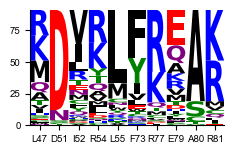

In [57]:
df_t15 = pd.read_csv(f'./gvp_samples/gvp_100_m_RES_1646945484_3030427_8_220711_samples_t1.5_n500.csv', header=None)
all_gen_muts = set(df_t15[0])
# creating a position by amino acid df
list_of_dics=[]
for p in range(10):
    muts = [mut.split(':')[p][-1] for mut in all_gen_muts]
    list_of_dics.append(Counter(muts))
df_counts = pd.DataFrame(list_of_dics)
df_counts.index = range(1,11)
df_counts = df_counts.fillna(0)

display(df_counts)
lm = logomaker.Logo(df_counts, color_scheme='chemistry', 
                    figsize= (2.5,1.5))
lm.ax.set_xticks(range(1,11))
lm.ax.set_xticklabels([m[:-1] for m in wt_muts_10x.split(':')], size=7)
lm.ax.set_yticklabels([0,25,50,75],size=7)

plt.savefig(dout + 'logo_gen_seq_n500_t15.svg', format='svg')

In [6]:
wt_muts_10x

NameError: name 'wt_muts_10x' is not defined

# show how many of their sampled sequences work

In [48]:
create_oh_mut('A').shape

(21,)

In [51]:
#700: L48, D52, I53, R55,L56
wt_muts_700 = 'L47L:D51D:I52I:R54R:L55L'

# 704: F74, R78, E80, A81, R82
wt_muts_704 = 'F73F:R77R:E79E:A80A:R81R'

wt_muts_10x = wt_muts_700 +':' + wt_muts_704

wt_mut_aas_10p = ''.join([m[-1] for m in wt_muts_10x.split(':')])


def read_sampled_mut_key(fin):
    # just reads a 
    muts = []
    for l in open(fin, 'r'):
        # some ESM sequences have <eos> in them
        if '<' not in l: 
            muts.append(l.rstrip())
        else:
            print('''found '<' in file: ''', fin)
    return muts

#def get_sampled_oh(muts):
def get_sampled_oh(muts, use_stop=False):

    # expects a list amino acid mutations like ['A', 'T', ...], and generates a one hot encoded array
    ohs = [create_oh_mut(m, use_stop=use_stop) for m in muts]
    x_sampled = np.stack(ohs, axis=0)
    return x_sampled


def get_muts_from_mutkeys(mutkeys):
    # get mutations from a given list of mutkeys ['L48K:E59D']
    muts = [''.join([m[-1] for m in mutkey.split(':')]) for mutkey in mutkeys]
    return muts

import itertools

def get_pairwise_hammings(muts, ref_seq = None):
    #take a list of mutations as string, like ['ACADK', 'ACADD']
    # and either return all pairwise hamming distances, or hamming distances to a ref_seq if given
    if ref_seq == None:
        pair_order_list = list(itertools.combinations(muts, 2))
        hamming_dists = [hamming(s1, s2) for (s1,s2) in pair_order_list]

    else:
        hamming_dists = [hamming(s, ref_seq) for s in muts]

    return hamming_dists


def plot_fit_and_hammings(yhat, y_compare, muts,
                         alpha =0.5,
                            figsize=(4,1), 
                          fout=None, 
                          max_hamm_dist = 10, 
                          c_hist = 'black',
                          axis_tick_size = 8,
                          ):
    ## expected arguments: 
    # yhat is the predicted fitness, 
    # y_compare is the distribution to compare to, and 
    # muts is a list of the aa mutations
    
    # plotting together for comparisons
    fig = plt.figure(figsize=figsize)  
    gs = gridspec.GridSpec(1,3)#, width_ratios=[4, 1], height_ratios=[1, 4])
    plt.subplots_adjust(hspace=0.5, wspace=0.3)

    # plot 
    ax1 = fig.add_subplot(gs[0])
    n, bins, patches = ax1.hist(y_compare, color='orange', alpha = 0.5,histtype='step', density=True, bins=15)
    ax1.hist(yhat, color=c_hist, alpha=alpha, density=True, bins=bins)
    ax1.set_xlim([-0.3, 1.3])
    ax1.title.set_text('fit, {:.0f}%>0.5'.format(100*np.sum([f>0.5 for f in yhat])/len(yhat)))
    ax1.tick_params(axis='both', which='major', labelsize=axis_tick_size)
    
    ax2 = fig.add_subplot(gs[1])
    pw_hamming = get_pairwise_hammings(muts)
    ax2.hist(pw_hamming, color=c_hist, alpha=alpha, density=True, bins=8)
    ax2.title.set_text('pw, m:{:.1f}'.format(np.mean(pw_hamming)))
    ax2.set_xlim([0, max_hamm_dist])
    ax2.tick_params(axis='both', which='major', labelsize=axis_tick_size)

    ax3= fig.add_subplot(gs[2])

    wt_hamming = get_pairwise_hammings(muts, ref_seq = wt_mut_aas_10p)
    ax3.hist(wt_hamming, color=c_hist, alpha=alpha, density=True, bins=8)
    ax3.title.set_text('wt, m:{:.1f}'.format(np.mean(wt_hamming)))
    ax3.set_xlim([0, max_hamm_dist])
    ax3.tick_params(axis='both', which='major', labelsize=axis_tick_size)

    fig.patch.set_visible(False)
    ax1.patch.set_visible(False)
    ax2.patch.set_visible(False)
    ax3.patch.set_visible(False)
    
    if fout != None:
        plt.savefig(fout + '.svg', format='svg')
        plt.savefig(fout + '.pdf', format='pdf')

    plt.show()

    
### for esm reading generated sequences
#esm_t0.001_pos10_n100_gen_seq.csv

#'ANVEKMSVAVTPQQAAVMREAVEAGEYATASEIVREAVRDWLAKREERHDDERRRRQLWDEGKASGRPEPVDYDALRKKAKQKLT'


mut_pos_10x_n0 = [int(k[1:-1])-2 for k in wt_muts_10x.split(':')] # maNVE where N is indexed as 0
mut_pos_10x_a0 = [int(k[1:-1])-1 for k in wt_muts_10x.split(':')] # mANVE where A is indexed as 0

wt_chain_a = 'NVEKMSVAVTPQQAAVMREAVEAGEYATASEIVREAVRDWLAKRELRHDDIRRLRQLWDEGKASGRPEPVDFDALRKEARQKLTE'
wt_chain_c = 'ANVEKMSVAVTPQQAAVMREAVEAGEYATASEIVREAVRDWLAKRELRHDDIRRLRQLWDEGKASGRPEPVDFDALRKEARQKLT'

def get_muts_from_chc_seq(seq,m0_pos_to_extract, 
                          wt_chain_c = wt_chain_c):
    a0_pos = [m-1 for m in m0_pos_to_extract] # mANVE where A is indexed as 0
    muts = [seq[p] for p in a0_pos]
    
    # sanity check that if extracting the right position
    if len(m0_pos_to_extract) == 10:
        muts_wt = [wt_chain_c[p] for p in a0_pos]
        assert muts_wt == ['L', 'D', 'I', 'R', 'L', 'F', 'R', 'E', 'A', 'R']
    return muts

def get_muts_from_cha_seq(seq,m0_pos_to_extract, 
                          wt_chain_a = wt_chain_a):
    n0_pos = [m-2 for m in m0_pos_to_extract] # maNVE where N is indexed as 0
    muts = [seq[p] for p in n0_pos]
    
    # sanity check that if extracting the right position
    if len(m0_pos_to_extract) == 10:
        muts_wt = [wt_chain_a[p] for p in n0_pos]
        assert muts_wt == ['L', 'D', 'I', 'R', 'L', 'F', 'R', 'E', 'A', 'R']
    return muts

m0_pos_10x = [int(m[1:-1]) for m in wt_muts_10x.split(':')]
m0_pos_10x

get_muts_from_chc_seq(wt_chain_c,m0_pos_10x)

get_muts_from_cha_seq(wt_chain_a,m0_pos_10x)
    

['L', 'D', 'I', 'R', 'L', 'F', 'R', 'E', 'A', 'R']

## RES model

In [ ]:
2 0.768 6.598396793587175 5.352

2 0.5535714285714286 7.459298584298584 6.142857142857143

RES, 10pos,t 0.1
deduplicating from 500 orgiinal muts to 5 unique muts
5


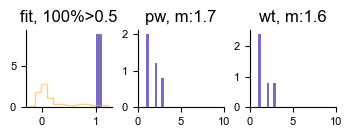

RES, 10pos,t 0.5
deduplicating from 500 orgiinal muts to 23 unique muts
23


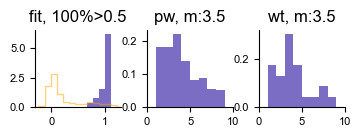

RES, 10pos,t 0.7
deduplicating from 500 orgiinal muts to 36 unique muts
36


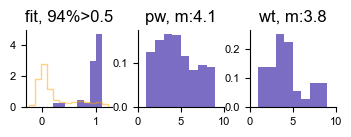

RES, 10pos,t 1
deduplicating from 500 orgiinal muts to 54 unique muts
54


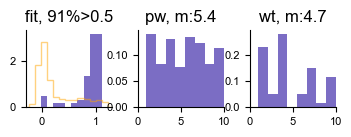

RES, 10pos,t 1.5
deduplicating from 500 orgiinal muts to 91 unique muts
91


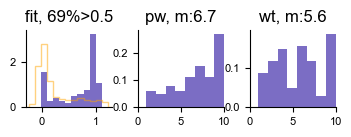

RES, 10pos,t 2
deduplicating from 500 orgiinal muts to 112 unique muts
112


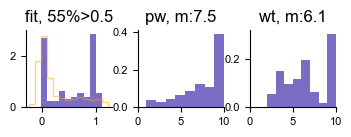

RES, 10pos,t 2.25
deduplicating from 500 orgiinal muts to 124 unique muts
124


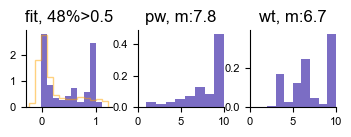

RES, 10pos,t 2.5
deduplicating from 500 orgiinal muts to 128 unique muts
128


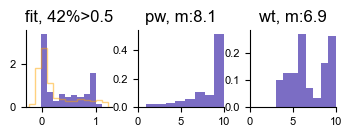

RES, 10pos,t 2.75
deduplicating from 500 orgiinal muts to 129 unique muts
129


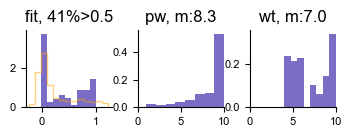

RES, 10pos,t 3
deduplicating from 500 orgiinal muts to 130 unique muts
130


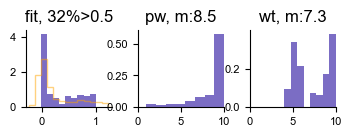

RES, 10pos,t 4
deduplicating from 500 orgiinal muts to 136 unique muts
136


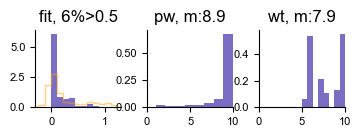

RES, 10pos,t 5
deduplicating from 500 orgiinal muts to 135 unique muts
135


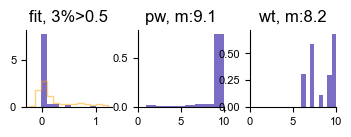

In [67]:
# using model_10p_no_stop
dedup = True

# for RES model with deduplication of generated sequences
for t in [0.1, 0.5,0.7,1,1.5,2,2.25,2.5,2.75,3,4,5]:
    fin = '/n/groups/marks/users/david/github/pareSingleLibrary2/codebase/pairedEnd/ex62_gvp/gvp_samples/gvp_100_m_RES_1646945484_3030427_8_220711_samples_t{}_n500.csv'.format(t)
    print('RES, 10pos,t', t)
    mutkeys = read_sampled_mut_key(fin) # getting the mutkeys
    if dedup:
        n_seq_all = len(mutkeys)
        mutkeys = list(set(mutkeys))
        n_seq_unique = len(mutkeys)
        print('deduplicating from {} orgiinal muts to {} unique muts'.format(n_seq_all, n_seq_unique))

    x_sample = get_sampled_oh(mutkeys) # getting the oh encoded X
    yhat = model_10p_no_stop.predict(x_sample) # getting model predictions
    print(len(yhat))
    muts = get_muts_from_mutkeys(mutkeys)
    plot_fit_and_hammings(yhat, Y_10pos_rc3_no_stop, muts,
                         fout = dout + 'res_gen_10p_t{}_renorm_dedup'.format(t),
                          alpha=0.8,
                         c_hist = '#5B49B6')

RES, 10pos,t 0.1
deduplicating from 500 orgiinal muts to 5 unique muts


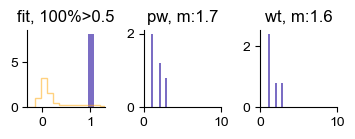

RES, 10pos,t 0.5
deduplicating from 500 orgiinal muts to 23 unique muts


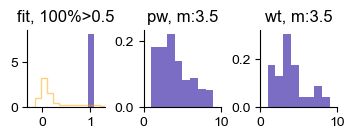

RES, 10pos,t 0.7
deduplicating from 500 orgiinal muts to 36 unique muts


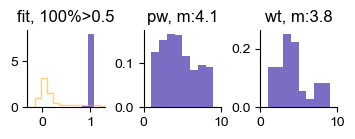

RES, 10pos,t 1
deduplicating from 500 orgiinal muts to 54 unique muts


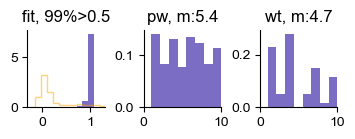

RES, 10pos,t 1.5
deduplicating from 500 orgiinal muts to 91 unique muts


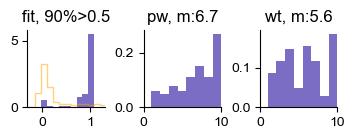

RES, 10pos,t 2
deduplicating from 500 orgiinal muts to 112 unique muts


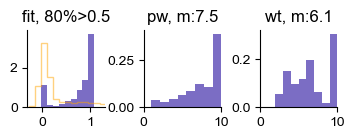

RES, 10pos,t 2.25
deduplicating from 500 orgiinal muts to 124 unique muts


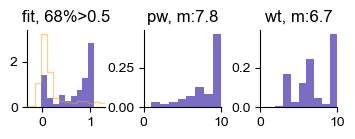

RES, 10pos,t 2.5
deduplicating from 500 orgiinal muts to 128 unique muts


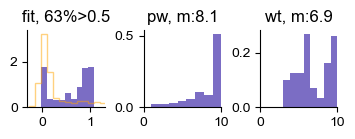

RES, 10pos,t 2.75
deduplicating from 500 orgiinal muts to 129 unique muts


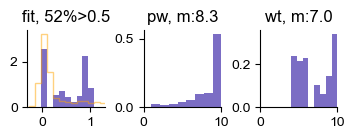

RES, 10pos,t 3
deduplicating from 500 orgiinal muts to 130 unique muts


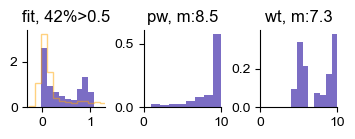

RES, 10pos,t 4
deduplicating from 500 orgiinal muts to 136 unique muts


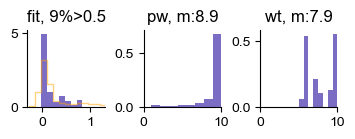

RES, 10pos,t 5
deduplicating from 500 orgiinal muts to 135 unique muts


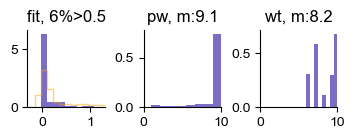

In [92]:
# for RES model without deduplication of generated sequences
for t in [0.1, 0.5,0.7,1,1.5,2,2.25,2.5,2.75,3,4,5]:
    fin = '/n/groups/marks/users/david/github/pareSingleLibrary2/codebase/pairedEnd/ex62_gvp/gvp_samples/gvp_100_m_RES_1646945484_3030427_8_220711_samples_t{}_n500.csv'.format(t)
    print('RES, 10pos,t', t)
    mutkeys = read_sampled_mut_key(fin) # getting the mutkeys
    x_sample = get_sampled_oh(mutkeys) # getting the oh encoded X
    yhat = model_10p.predict(x_sample) # getting model predictions

    muts = get_muts_from_mutkeys(mutkeys)
    plot_fit_and_hammings(yhat, Y_10pos, muts,
                         fout = dout + 'res_gen_10p_t{}'.format(t),
                          alpha=0.8,
                         c_hist = '#5B49B6')


RES, 10pos,t 0.1
deduplicating from 500 orgiinal muts to 5 unique muts


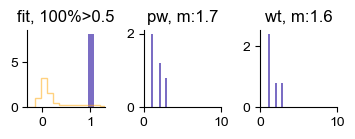

RES, 10pos,t 0.5
deduplicating from 500 orgiinal muts to 23 unique muts


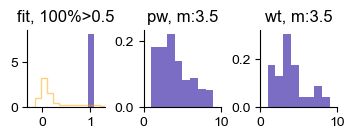

RES, 10pos,t 0.7
deduplicating from 500 orgiinal muts to 36 unique muts


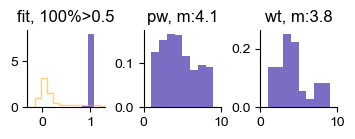

RES, 10pos,t 1
deduplicating from 500 orgiinal muts to 54 unique muts


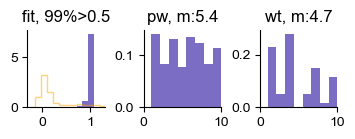

RES, 10pos,t 1.5
deduplicating from 500 orgiinal muts to 91 unique muts


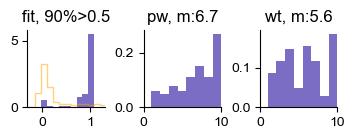

RES, 10pos,t 2
deduplicating from 500 orgiinal muts to 112 unique muts


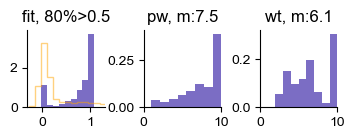

RES, 10pos,t 2.25
deduplicating from 500 orgiinal muts to 124 unique muts


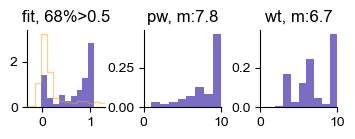

RES, 10pos,t 2.5
deduplicating from 500 orgiinal muts to 128 unique muts


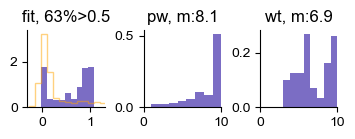

RES, 10pos,t 2.75
deduplicating from 500 orgiinal muts to 129 unique muts


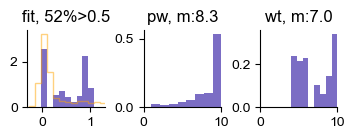

RES, 10pos,t 3
deduplicating from 500 orgiinal muts to 130 unique muts


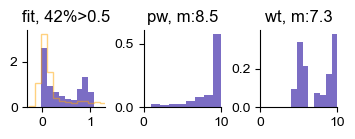

RES, 10pos,t 4
deduplicating from 500 orgiinal muts to 136 unique muts


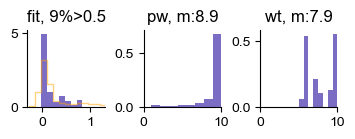

RES, 10pos,t 5
deduplicating from 500 orgiinal muts to 135 unique muts


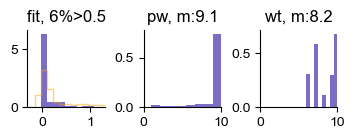

In [93]:
# for RES model without deduplication of generated sequences
for t in [0.1, 0.5,0.7,1,1.5,2,2.25,2.5,2.75,3,4,5]:
    fin = '/n/groups/marks/users/david/github/pareSingleLibrary2/codebase/pairedEnd/ex62_gvp/gvp_samples/gvp_100_m_RES_1646945484_3030427_8_220711_samples_t{}_n500.csv'.format(t)
    print('RES, 10pos,t', t)
    mutkeys = read_sampled_mut_key(fin) # getting the mutkeys
    x_sample = get_sampled_oh(mutkeys) # getting the oh encoded X
    yhat = model_10p.predict(x_sample) # getting model predictions

    muts = get_muts_from_mutkeys(mutkeys)
    plot_fit_and_hammings(yhat, Y_10pos, muts,
                         fout = dout + 'res_gen_deduplicate_10p_t{}'.format(t),
                          alpha=0.8,
                         c_hist = '#5B49B6', 
                         deduplicate_gen = True)

In [ ]:
# for 10 position generated samples
m
fin = '/n/groups/marks/users/david/github/pareSingleLibrary2/codebase/pairedEnd/ex62_gvp/gvp_samples/gvp_100_m_RES_1646945484_3030427_8_220711_samples_t2_n100.csv'

mutkeys = read_sampled_mut_key(fin) # getting the mutkeys
x_sample = get_sampled_oh(mutkeys) # getting the oh encoded X
yhat = model_10p.predict(x_sample)

# plotting independently
alpha =0.5
fig = plt.figure(figsize=(2,2))
n, bins, patches = plt.hist(Y_10pos, color='orange', alpha = 0.5,histtype='step', density=True, bins=15)
plt.hist(yhat, color='black', alpha=alpha, density=True, bins=bins)
plt.xlim([-0.3, 1.35])
plt.title('fitness, fraction >0.5: {:.1f}'.format(np.sum([f>0.5 for f in yhat])/len(yhat)))
fig.patch.set_visible(False)
plt.show()

fig = plt.figure(figsize=(2,2))
muts = get_muts_from_mutkeys(mutkeys)
pw_hamming = get_pairwise_hammings(muts)
plt.hist(pw_hamming, color='black', alpha=alpha, density=True, bins=8)
plt.title('intra-hamming distance of generated seqs, mean: {:.1f}'.format(np.mean(pw_hamming)))
fig.patch.set_visible(False)
plt.show()


fig = plt.figure(figsize=(2,2))
muts = get_muts_from_mutkeys(mutkeys)
pw_hamming = get_pairwise_hammings(muts, ref_seq = wt_mut_aas_10p)
plt.hist(pw_hamming, color='black', alpha=alpha, density=True, bins=8)
plt.title('wt-hamming distance of generated seqs, mean: {:.1f}'.format(np.mean(pw_hamming)))
fig.patch.set_visible(False)
plt.show()


## esm_if

In [12]:
wt_muts_10x

'L47L:D51D:I52I:R54R:L55L:F73F:R77R:E79E:A80A:R81R'

In [125]:
esm_gen_dir = '/n/groups/marks/users/david/esm_if/data/gen_seqs/'


['L', 'D', 'I', 'R', 'L', 'F', 'R', 'E', 'A', 'R']

In [11]:
from os import listdir
listdir(esm_gen_dir)

['esm_t1.75_pos4_n100_gen_seq.csv',
 'esm_t0.75_pos10_n100_gen_seq.csv',
 'esm_t3.0_pos10_n100_gen_seq.csv',
 'esm_t5.0_pos4_n100_gen_seq.csv',
 'esm_t0.75_pos3_n100_gen_seq.csv',
 'esm_t4.0_pos4_n100_gen_seq.csv',
 'esm_t1.5_pos10_n100_gen_seq.csv',
 'esm_t5.0_pos10_n100_gen_seq.csv',
 'esm_t1.5_pos3_n100_gen_seq.csv',
 'esm_t1.5_pos4_n100_gen_seq.csv',
 'esm_t0.75_pos4_n100_gen_seq.csv',
 'esm_t2.0_pos10_n100_gen_seq.csv',
 'esm_t1.75_pos3_n100_gen_seq.csv',
 'esm_t4.0_pos10_n100_gen_seq.csv',
 'esm_t1.75_pos10_n100_gen_seq.csv',
 'esm_t1.25_pos4_n100_gen_seq.csv',
 'esm_t1.25_pos3_n100_gen_seq.csv',
 'esm_t2.0_pos3_n100_gen_seq.csv',
 'esm_t3.0_pos4_n100_gen_seq.csv',
 'esm_t3.0_pos3_n100_gen_seq.csv',
 'esm_t2.0_pos4_n100_gen_seq.csv',
 'esm_t4.0_pos3_n100_gen_seq.csv',
 'esm_t5.0_pos3_n100_gen_seq.csv',
 'esm_t1.25_pos10_n100_gen_seq.csv']

ESM, pos10, t:0.001


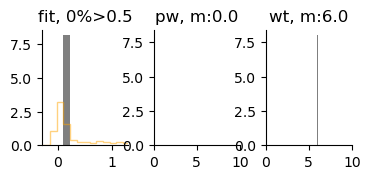

ESM, pos10, t:0.01


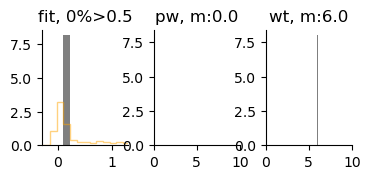

ESM, pos10, t:0.1


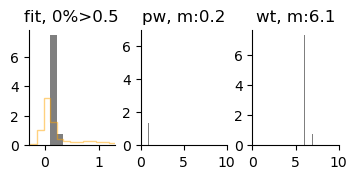

ESM, pos10, t:0.5


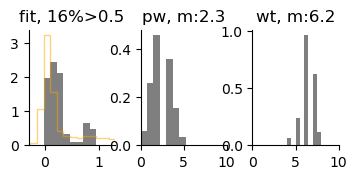

ESM, pos10, t:0.75


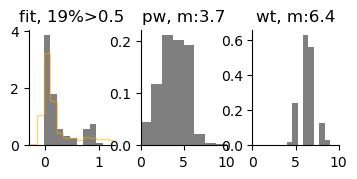

ESM, pos10, t:1.0


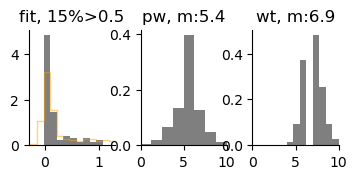

ESM, pos10, t:1.25


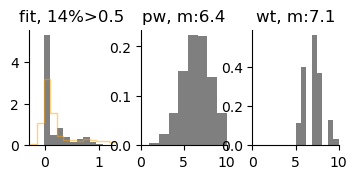

ESM, pos10, t:1.5


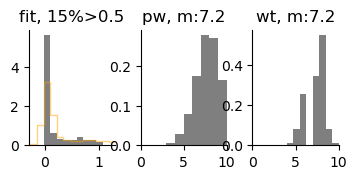

ESM, pos10, t:1.75


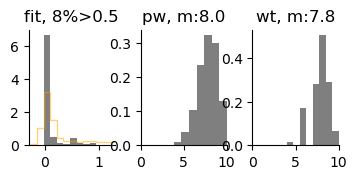

ESM, pos10, t:2.0


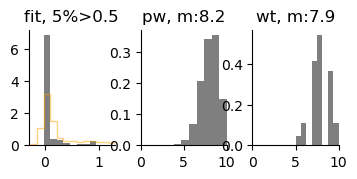

ESM, pos10, t:3.0


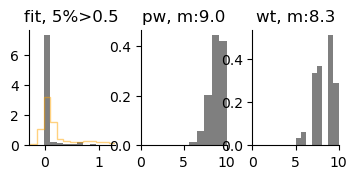

ESM, pos10, t:4.0


KeyError: '<'

In [20]:
# for ESM gen seqs

t_esm = [0.001, 0.01, 0.1, 0.5,0.75, 1.0,1.25,  1.5, 1.75, 2.0, 3.0, 4.0, 5.0,10.0]

 
#pos_esm = [3,4,10]

p = 10
for t in t_esm:
    print('ESM, pos{}, t:{}'.format(p, t))
    df_esm_gen = pd.read_csv(esm_gen_dir + 'esm_t{}_pos{}_n100_gen_seq.csv'.format(t, p), header=None)
    df_esm_gen = df_esm_gen.rename(columns={0:'seq'})
    df_esm_gen['muts_sep'] = df_esm_gen.apply(lambda r: ':'.join(get_muts_from_chc_seq(r.seq, m0_pos_10x)), axis=1)
    df_esm_gen['muts'] = df_esm_gen.apply(lambda r: ''.join(get_muts_from_chc_seq(r.seq, m0_pos_10x)), axis=1)

    # assert that only valid characters generated
    all_valid = True
    for seq in df_esm_gen['muts'].values:
        for c in seq:
            if c not in aa_alphabet:
                all_valid == False
    
    if all_valid:
        muts = list(df_esm_gen['muts_sep'].values) # returning a list of mutations ['E:E:R:K', ]
        x_sample = get_sampled_oh(muts) # getting the oh encoded X
        yhat = model_10p.predict(x_sample) # getting model predictions

        muts_concat = list(df_esm_gen['muts'].values)
        plot_fit_and_hammings(yhat, Y_10pos, muts_concat,
                             fout = dout + 'esm_gen_10p_t{}'.format(t))
    else:
        print('generated sequences contain some error, cannot plot')



## proteinMPNN

In [49]:
pmpnn_dir = '/n/groups/marks/users/david/github/pareSingleLibrary2/codebase/pairedEnd/ex62_gvp/protein_mpnn_samples_from_colab/'



In [54]:
#testing extracting mutations
hamm_dists = []
for r in fasta_iter_py3(pmpnn_dir + 't1.5_ta_n30_10x.fa'):
    gen_seq = r.sequence
    muts = get_muts_from_cha_seq(gen_seq,m0_pos_10x)
    print(muts)
    print(gen_seq)
    hamm = hamming(gen_seq, wt_chain_a)
    hamm_dists.append(hamm)
print(hamm_dists)
print(np.mean(hamm_dists))


['E', 'D', 'V', 'Y', 'L', 'A', 'R', 'E', 'A', 'F']
NVEKMSVAVTPQQAAVMREAVEAGEYATASEIVREAVRDWLAKREERHDDVRYLRQLWDEGKASGRPEPVDADALRKEAFQKLTE
['T', 'D', 'I', 'R', 'N', 'Y', 'I', 'E', 'N', 'L']
NVEKMSVAVTPQQAAVMREAVEAGEYATASEIVREAVRDWLAKRETRHDDIRRNRQLWDEGKASGRPEPVDYDALIKENLQKLTE
['R', 'D', 'W', 'T', 'L', 'S', 'K', 'Q', 'A', 'I']
NVEKMSVAVTPQQAAVMREAVEAGEYATASEIVREAVRDWLAKRERRHDDWRTLRQLWDEGKASGRPEPVDSDALKKQAIQKLTE
['L', 'D', 'D', 'A', 'Y', 'Y', 'R', 'S', 'D', 'K']
NVEKMSVAVTPQQAAVMREAVEAGEYATASEIVREAVRDWLAKRELRHDDDRAYRQLWDEGKASGRPEPVDYDALRKSDKQKLTE
['M', 'D', 'I', 'V', 'N', 'F', 'A', 'Q', 'A', 'E']
NVEKMSVAVTPQQAAVMREAVEAGEYATASEIVREAVRDWLAKREMRHDDIRVNRQLWDEGKASGRPEPVDFDALAKQAEQKLTE
['N', 'D', 'M', 'W', 'L', 'Y', 'R', 'I', 'A', 'L']
NVEKMSVAVTPQQAAVMREAVEAGEYATASEIVREAVRDWLAKRENRHDDMRWLRQLWDEGKASGRPEPVDYDALRKIALQKLTE
['L', 'V', 'L', 'H', 'L', 'F', 'H', 'E', 'A', 'T']
NVEKMSVAVTPQQAAVMREAVEAGEYATASEIVREAVRDWLAKRELRHDVLRHLRQLWDEGKASGRPEPVDFDALHKEATQKLTE
['A', 'D', 'I', 'T', 'A', 'R', 'M', 'E', 

In [23]:
listdir(pmpnn_dir)

['t1.4_ta_n30_10x_take2.fa',
 't1.0_ta_n30_10x.fa',
 't0.9_ta_n30_10x.fa',
 't1.5_ta_n30_10x.fa',
 't0.1_ta_n10_10x.fa',
 't1.3_ta_n30_10x.fa',
 't0.3_ta_n10_10x.fa',
 't0.7_ta_n10_10x.fa',
 't0.1_ta_n30_10x.fa',
 't1.0_ta_n30_10x_take2.fa',
 't1.4_ta_n30_10x.fa',
 't0.8_ta_n30_10x.fa',
 't0.5_ta_n10_10x.fa',
 't1.2_ta_n30_10x.fa',
 't0.5_ta_n30_10x.fa',
 't0.7_ta_n30_10x.fa',
 't1.2_ta_n30_10x_take2.fa',
 't1.1_ta_n30_10x.fa',
 't0.3_ta_n30_10x.fa']

pmpnn, t0.1_ta_n10_10x.fa


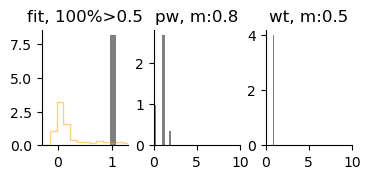

pmpnn, t0.1_ta_n30_10x.fa


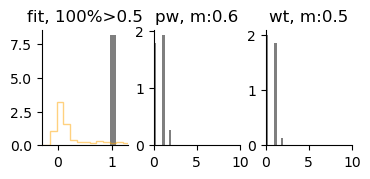

pmpnn, t0.3_ta_n10_10x.fa


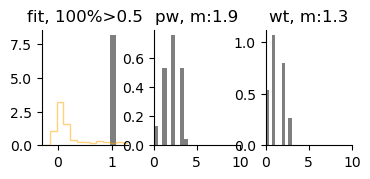

pmpnn, t0.3_ta_n30_10x.fa


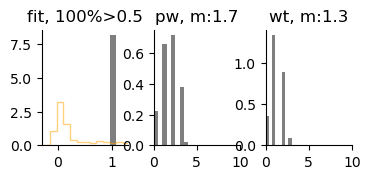

pmpnn, t0.5_ta_n10_10x.fa


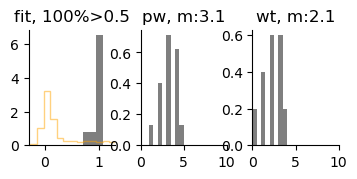

pmpnn, t0.5_ta_n30_10x.fa


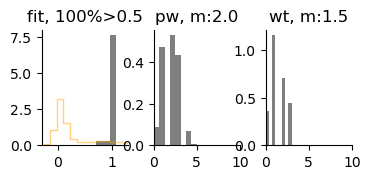

pmpnn, t0.7_ta_n10_10x.fa


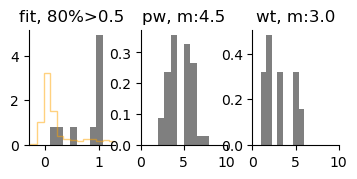

pmpnn, t0.7_ta_n30_10x.fa


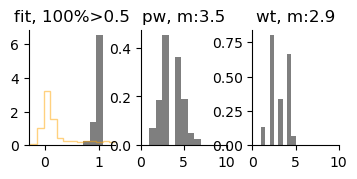

pmpnn, t0.8_ta_n30_10x.fa


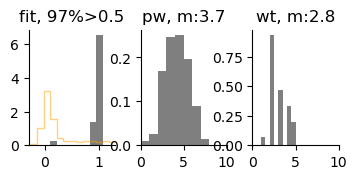

pmpnn, t0.9_ta_n30_10x.fa


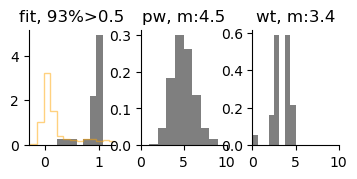

pmpnn, t1.0_ta_n30_10x.fa


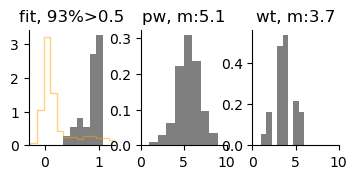

pmpnn, t1.0_ta_n30_10x_take2.fa


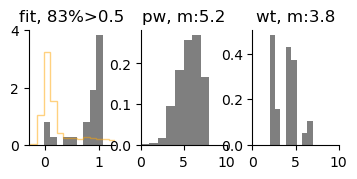

pmpnn, t1.1_ta_n30_10x.fa


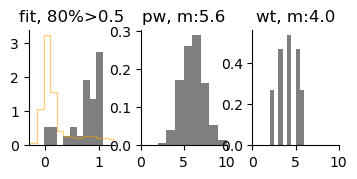

pmpnn, t1.2_ta_n30_10x.fa


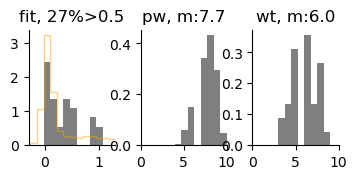

pmpnn, t1.2_ta_n30_10x_take2.fa


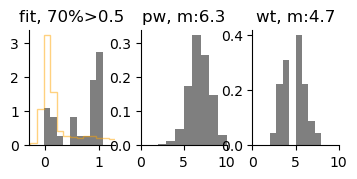

pmpnn, t1.3_ta_n30_10x.fa


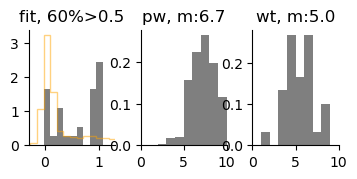

pmpnn, t1.4_ta_n30_10x.fa


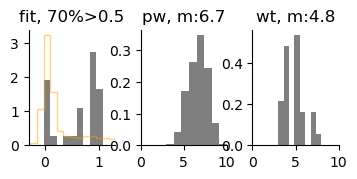

pmpnn, t1.4_ta_n30_10x_take2.fa


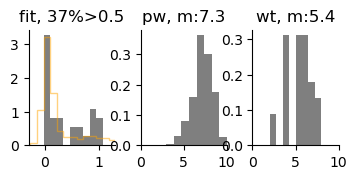

pmpnn, t1.5_ta_n30_10x.fa


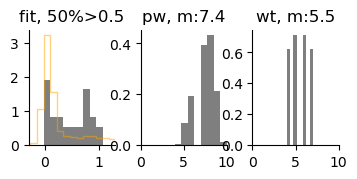

In [24]:
# for protein_mpnn gen seqs

for f in sorted(listdir(pmpnn_dir)):
    print('pmpnn, {}'.format(f))
    
    # collect all mutants for a file
    list_all_seq_muts = [] # list of mutations ['EERK', ] per sequence
    list_all_seq_muts_sep = [] # list of mutations ['E:E:R:K', ] per sequence

    for r in fasta_iter_py3(pmpnn_dir + f):
        gen_seq = r.sequence
        one_seq_muts = get_muts_from_cha_seq(gen_seq,m0_pos_10x) # get the right positions
        list_all_seq_muts.append(''.join(one_seq_muts))
        list_all_seq_muts_sep.append(':'.join(one_seq_muts))
        

    x_sample = get_sampled_oh(list_all_seq_muts_sep) # getting the oh encoded X
    yhat = model_10p.predict(x_sample) # getting model predictions

    muts_concat = list_all_seq_muts
    
    t= f.split('_')[0][1:]
    plot_fit_and_hammings(yhat, Y_10pos, muts_concat,
                         fout = dout + 'pmpnn_gen_10p_t{}'.format(t))


In [ ]:
# generate more sequences with pmpnn temperatures at 0.8, 0.9, 1.0, 1.1, 1.3, 1.4, 1.5

## plot a single scatter graph for all generated sequences

In [80]:
random.choices(mutkeys, k=30)

['L48Q:D52D:I53I:R55R:L56L:F74F:R78R:E80E:A81A:R82R',
 'L48K:D52D:I53I:R55R:L56L:F74F:R78R:E80E:A81A:R82R',
 'L48K:D52D:I53I:R55R:L56L:F74F:R78R:E80E:A81A:R82R',
 'L48Q:D52D:I53I:R55R:L56L:F74F:R78R:E80E:A81A:R82R',
 'L48R:D52D:I53I:R55R:L56L:F74F:R78R:E80E:A81A:R82R',
 'L48K:D52D:I53I:R55R:L56L:F74F:R78R:E80E:A81A:R82R',
 'L48Q:D52D:I53I:R55R:L56L:F74F:R78R:E80E:A81A:R82R',
 'L48R:D52D:I53I:R55R:L56L:F74F:R78R:E80E:A81A:R82R',
 'L48R:D52D:I53I:R55R:L56L:F74F:R78R:E80E:A81A:R82R',
 'L48K:D52D:I53I:R55R:L56L:F74F:R78R:E80E:A81A:R82K',
 'L48K:D52D:I53I:R55R:L56L:F74F:R78R:E80E:A81A:R82R',
 'L48K:D52D:I53I:R55R:L56L:F74F:R78R:E80E:A81A:R82R',
 'L48Q:D52D:I53I:R55R:L56L:F74F:R78R:E80E:A81A:R82R',
 'L48K:D52D:I53I:R55R:L56L:F74F:R78R:E80E:A81A:R82R',
 'L48K:D52D:I53I:R55R:L56L:F74F:R78R:E80E:A81A:R82K',
 'L48R:D52D:I53I:R55R:L56L:F74F:R78R:E80E:A81A:R82R',
 'L48R:D52D:I53I:R55R:L56L:F74F:R78R:E80E:A81A:R82R',
 'L48K:D52D:I53I:R55R:L56L:F74F:R78R:E80E:A81A:R82K',
 'L48K:D52D:I53I:R55R:L56L:F

In [49]:
# plot a single scatter graph
random.seed(42)

from os import listdir

live_thresh = 0.5

model = model_10p_no_stop

deduplicate = True
n_unique_seq_sample = 30
# for the RES model
mean_hamming_pw_res = []
mean_hamming_wt_res = []
frac_alive_res = []
for t in [0.1, 0.5,0.7,1,1.5,2,2.25,2.5,2.75,3,4,5]:
    fin = '/n/groups/marks/users/david/github/pareSingleLibrary2/codebase/pairedEnd/ex62_gvp/gvp_samples/gvp_100_m_RES_1646945484_3030427_8_220711_samples_t{}_n500.csv'.format(t)
    #print('RES, 10pos,t', t)
    mutkeys = read_sampled_mut_key(fin) # getting the mutkeys
    if deduplicate:
        mutkeys = list(set(mutkeys))
        #sample down to match the number of sequences generated by proteinMPNN
        mutkeys = random.choices(mutkeys, k=n_unique_seq_sample)
    print('res samples considered:',len(mutkeys))

    x_sample = get_sampled_oh(mutkeys) # getting the oh encoded X
    #print('muts shape',x_sample.shape)

    yhat = model.predict(x_sample) # getting model predictions

    frac_alive = np.sum([f>live_thresh for f in yhat])/len(yhat)
    frac_alive_res.append(frac_alive)
    
    muts = get_muts_from_mutkeys(mutkeys) # getting the 
    pw_hamming = get_pairwise_hammings(muts)
    mean_pw_hamming = np.mean(pw_hamming)
    wt_hamming = get_pairwise_hammings(muts, ref_seq = wt_mut_aas_10p)
    mean_wt_hamming = np.mean(wt_hamming)
    mean_hamming_pw_res.append(mean_pw_hamming)
    mean_hamming_wt_res.append(mean_wt_hamming)
    print(t, frac_alive, mean_pw_hamming, mean_wt_hamming)
    
# for proteinMPNN
pmpnn_dir = '/n/groups/marks/users/david/github/pareSingleLibrary2/codebase/pairedEnd/ex62_gvp/protein_mpnn_samples_from_colab/'

mean_hamming_pw_pmpnn = []
mean_hamming_wt_pmpnn = []
frac_alive_pmpnn = []

# filtering out files that are only ten samples
pmpnn_files_consider = [f for f in listdir(pmpnn_dir) if f.split('_')[2]=='n30']
for f in sorted(pmpnn_files_consider):
    
    # collect all mutants for a file
    list_all_seq_muts = [] # list of mutations ['EERK', ] per sequence
    list_all_seq_muts_sep = [] # list of mutations ['E:E:R:K', ] per sequence

    for r in fasta_iter_py3(pmpnn_dir + f):
        gen_seq = r.sequence
        one_seq_muts = get_muts_from_cha_seq(gen_seq,m0_pos_10x) # get the right positions
        list_all_seq_muts.append(''.join(one_seq_muts))
        list_all_seq_muts_sep.append(':'.join(one_seq_muts))
        
    if deduplicate:
        n_before_dedup = len(list_all_seq_muts_sep)
        list_all_seq_muts_sep = list(set(list_all_seq_muts_sep))
        n_after_dedup = len(list_all_seq_muts_sep)
        muts_concat = get_muts_from_mutkeys(list_all_seq_muts_sep)
        # muts_concat =list(set(list_all_seq_muts))
        
    else:
        muts_concat = list_all_seq_muts
    print('pMPNN samples considered:',len(list_all_seq_muts_sep))

    x_sample = get_sampled_oh(list_all_seq_muts_sep) # getting the oh encoded X
    yhat = model.predict(x_sample) # getting model predictions
    
    pw_hamming = get_pairwise_hammings(muts_concat)
    mean_hamming_pw = np.mean(pw_hamming)
    wt_hamming = get_pairwise_hammings(muts_concat, ref_seq = wt_mut_aas_10p)
    mean_hamming_wt = np.mean(wt_hamming)
    
    frac_alive = np.sum([f>live_thresh for f in yhat])/len(yhat)
    print(f)
    print(f'deduplicate:{deduplicate}, num_unique_seqs:{n_after_dedup} from n_samples:{n_before_dedup}, frac_alive:{frac_alive}, mean_pw_hamming:{mean_hamming_pw}')
    frac_alive_pmpnn.append(frac_alive)
    mean_hamming_pw_pmpnn.append(np.mean(pw_hamming))
    mean_hamming_wt_pmpnn.append(np.mean(wt_hamming))

# for ESM gen seqs
esm_gen_dir = '/n/groups/marks/users/david/esm_if/data/gen_seqs/'
frac_alive_esm =[]
mean_hamming_pw_esm = []
mean_hamming_wt_esm = []


#t_esm = [0.001, 0.01, 0.1, 0.5,0.75, 1.0,1.25, 1.5, 1.75, 2.0, 3.0]#, #4.0, 5.0,10.0]

t_esm = [0.75, 1.25, 1.5, 1.75, 2.0, 3.0, 4.0, 5.0]

p = 10
for t in t_esm:
    df_esm_gen = pd.read_csv(esm_gen_dir + 'esm_t{}_pos{}_n100_gen_seq.csv'.format(t, p), header=None)
    df_esm_gen = df_esm_gen.rename(columns={0:'seq'})
    df_esm_gen['muts_sep'] = df_esm_gen.apply(lambda r: ':'.join(get_muts_from_chc_seq(r.seq, m0_pos_10x)), axis=1)
    df_esm_gen['muts'] = df_esm_gen.apply(lambda r: ''.join(get_muts_from_chc_seq(r.seq, m0_pos_10x)), axis=1)

    muts = list(df_esm_gen['muts_sep'].values) # returning a list of mutations ['E:E:R:K', ]
    if deduplicate:
        muts = list(set(muts))
        # downsample to match proteinMPNN numbers approximately
        muts = random.choices(muts, k=n_unique_seq_sample)
        muts_concat = get_muts_from_mutkeys(muts)
        #print(muts, muts_concat)
    else:
        muts_concat = list(df_esm_gen['muts'].values)
    print('Esm samples considered:',len(muts))
    x_sample = get_sampled_oh(muts) # getting the oh encoded X
    yhat = model.predict(x_sample) # getting model predictions

    pw_hamming = get_pairwise_hammings(muts_concat)
    mean_hamming_pw = np.mean(pw_hamming)
    wt_hamming = get_pairwise_hammings(muts_concat, ref_seq = wt_mut_aas_10p)
    mean_hamming_wt = np.mean(wt_hamming)
    
    frac_alive = np.sum([f>live_thresh for f in yhat])/len(yhat)

    frac_alive_esm.append(frac_alive)
    mean_hamming_pw_esm.append(np.mean(pw_hamming))
    mean_hamming_wt_esm.append(np.mean(wt_hamming))
    
    

res samples considered: 30
muts shape (30, 201)
0.1 1.0 1.4183908045977012 1.6
res samples considered: 30
muts shape (30, 201)
0.5 1.0 3.659770114942529 4.133333333333334
res samples considered: 30
muts shape (30, 201)
0.7 0.9666666666666667 4.480459770114942 4.2
res samples considered: 30
muts shape (30, 201)
1 0.9333333333333333 5.328735632183908 4.633333333333334
res samples considered: 30
muts shape (30, 201)
1.5 0.7333333333333333 7.296551724137931 6.133333333333334
res samples considered: 30
muts shape (30, 201)
2 0.5333333333333333 7.475862068965517 6.366666666666666
res samples considered: 30
muts shape (30, 201)
2.25 0.5 7.795402298850575 6.933333333333334
res samples considered: 30
muts shape (30, 201)
2.5 0.4666666666666667 8.232183908045977 7.2
res samples considered: 30
muts shape (30, 201)
2.75 0.3 8.335632183908046 7.333333333333333
res samples considered: 30
muts shape (30, 201)
3 0.4 8.482758620689655 7.266666666666667
res samples considered: 30
muts shape (30, 201)
4 

NameError: name 'get_muts_from_cha_seq' is not defined

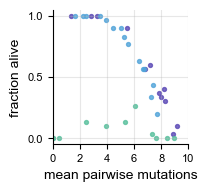

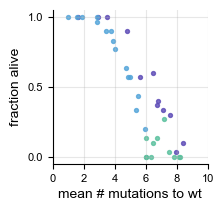

In [114]:

alpha=0.8
ms = 8

fig= plt.figure(figsize=(1.75,1.75))
plt.scatter(mean_hamming_pw_res, frac_alive_res, label='RES', alpha=alpha, s=ms)
plt.scatter(mean_hamming_pw_pmpnn, frac_alive_pmpnn, label ='pMPNN', alpha=alpha, s=ms)
plt.scatter(mean_hamming_pw_esm, frac_alive_esm, label ='esm IF', alpha=alpha, s=ms)
plt.xlim([0,10])
#plt.legend(loc='center left', fontsize=8)
plt.xticks(list(range(11)))
plt.xticks([0,2,4,6,8,10], size=8)
plt.yticks([0,0.5,1], size=8)

plt.xlabel('mean pairwise mutations')
plt.ylabel('fraction alive')
#plt.title('pairwise hamming vs. fraction alive')
plt.grid(alpha=0.3)
fig.patch.set_visible(False)
plt.savefig(dout + 'frac_alive_vs_hamm_pw_renorm_dedup_res_sample_down.svg', format='svg')
plt.show()

fig= plt.figure(figsize=(2,2))
plt.scatter(mean_hamming_wt_res, frac_alive_res, label='RES', alpha=alpha, s=ms)
plt.scatter(mean_hamming_wt_pmpnn, frac_alive_pmpnn, label ='pMPNN', alpha=alpha, s=ms)
plt.scatter(mean_hamming_wt_esm, frac_alive_esm, label ='esm IF', alpha=alpha, s=ms)
#plt.legend(loc='center left', fontsize = 8)
plt.xlim([0,10])
plt.xticks([0,2,4,6,8,10], size=8)
plt.yticks([0,0.5,1], size=8)

plt.xlabel('mean # mutations to wt')
plt.ylabel('fraction alive')
#plt.title('hamming to wt vs. fraction alive')
plt.grid(alpha=0.3)
fig.patch.set_visible(False)
plt.savefig(dout + 'frac_alive_vs_hamm_wt_renorm_dedup_res_sample_down.svg', format='svg')
plt.show()

# read in and calculate plotting statistics for generated sequences


In [126]:
# read in and calculate plotting statistics for generated sequences
random.seed(42)

from os import listdir

live_thresh = 0.5

model = model_10p_no_stop

deduplicate = True
n_unique_seq_sample = 30
n_downsampling = 10
# for the RES model
mean_hamming_pw_res = []
mean_hamming_wt_res = []
frac_alive_res = []
for t in [0.1, 0.5,0.7,1,1.5,2,2.25,2.5,2.75,3,4,5]:
    fin = '/n/groups/marks/users/david/github/pareSingleLibrary2/codebase/pairedEnd/ex62_gvp/gvp_samples/gvp_100_m_RES_1646945484_3030427_8_220711_samples_t{}_n500.csv'.format(t)
    #print('RES, 10pos,t', t)
    for i in range(n_downsampling):
        mutkeys = read_sampled_mut_key(fin) # getting the mutkeys
        if deduplicate:
            mutkeys = list(set(mutkeys))
            #sample down to match the number of sequences generated by proteinMPNN
            mutkeys = random.choices(mutkeys, k=n_unique_seq_sample)
        #print('res samples considered:',len(mutkeys))

        x_sample = get_sampled_oh(mutkeys) # getting the oh encoded X
        yhat = model.predict(x_sample) # getting model predictions

        frac_alive = np.sum([f>live_thresh for f in yhat])/len(yhat)
        frac_alive_res.append(frac_alive)

        muts = get_muts_from_mutkeys(mutkeys) # getting the 
        pw_hamming = get_pairwise_hammings(muts)
        mean_pw_hamming = np.mean(pw_hamming)
        wt_hamming = get_pairwise_hammings(muts, ref_seq = wt_mut_aas_10p)
        mean_wt_hamming = np.mean(wt_hamming)
        mean_hamming_pw_res.append(mean_pw_hamming)
        mean_hamming_wt_res.append(mean_wt_hamming)
        #print(t, frac_alive, mean_pw_hamming, mean_wt_hamming)
    
# for proteinMPNN
pmpnn_dir = '/n/groups/marks/users/david/github/pareSingleLibrary2/codebase/pairedEnd/ex62_gvp/protein_mpnn_samples_from_colab/'

mean_hamming_pw_pmpnn = []
mean_hamming_wt_pmpnn = []
frac_alive_pmpnn = []

# filtering out files that are only ten samples
pmpnn_files_consider = [f for f in listdir(pmpnn_dir) if f.split('_')[2]=='n30']
for f in sorted(pmpnn_files_consider):
    
    # collect all mutants for a file
    list_all_seq_muts = [] # list of mutations ['EERK', ] per sequence
    list_all_seq_muts_sep = [] # list of mutations ['E:E:R:K', ] per sequence

    for r in fasta_iter_py3(pmpnn_dir + f):
        gen_seq = r.sequence
        one_seq_muts = get_muts_from_cha_seq(gen_seq,m0_pos_10x) # get the right positions
        list_all_seq_muts.append(''.join(one_seq_muts))
        list_all_seq_muts_sep.append(':'.join(one_seq_muts))
        
    if deduplicate:
        n_before_dedup = len(list_all_seq_muts_sep)
        list_all_seq_muts_sep = list(set(list_all_seq_muts_sep))
        n_after_dedup = len(list_all_seq_muts_sep)
        muts_concat = get_muts_from_mutkeys(list_all_seq_muts_sep)
        # muts_concat =list(set(list_all_seq_muts))
        
    else:
        muts_concat = list_all_seq_muts
    print('pMPNN samples considered:',len(list_all_seq_muts_sep))

    x_sample = get_sampled_oh(list_all_seq_muts_sep) # getting the oh encoded X
    yhat = model.predict(x_sample) # getting model predictions
    
    pw_hamming = get_pairwise_hammings(muts_concat)
    mean_hamming_pw = np.mean(pw_hamming)
    wt_hamming = get_pairwise_hammings(muts_concat, ref_seq = wt_mut_aas_10p)
    mean_hamming_wt = np.mean(wt_hamming)
    
    frac_alive = np.sum([f>live_thresh for f in yhat])/len(yhat)
    print(f)
    print(f'deduplicate:{deduplicate}, num_unique_seqs:{n_after_dedup} from n_samples:{n_before_dedup}, frac_alive:{frac_alive}, mean_pw_hamming:{mean_hamming_pw}')
    frac_alive_pmpnn.append(frac_alive)
    mean_hamming_pw_pmpnn.append(np.mean(pw_hamming))
    mean_hamming_wt_pmpnn.append(np.mean(wt_hamming))

# for ESM gen seqs
esm_gen_dir = '/n/groups/marks/users/david/esm_if/data/gen_seqs/'
frac_alive_esm =[]
mean_hamming_pw_esm = []
mean_hamming_wt_esm = []
#t_esm = [0.001, 0.01, 0.1, 0.5,0.75, 1.0,1.25, 1.5, 1.75, 2.0, 3.0]#, #4.0, 5.0,10.0]
t_esm = [0.75, 1.25, 1.5, 1.75, 2.0, 3.0, 4.0, 5.0]

p = 10
for t in t_esm:
    for i in range(n_downsampling):
        df_esm_gen = pd.read_csv(esm_gen_dir + 'esm_t{}_pos{}_n100_gen_seq.csv'.format(t, p), header=None)
        df_esm_gen = df_esm_gen.rename(columns={0:'seq'})
        df_esm_gen['has_weird_chars'] = df_esm_gen.apply(lambda r: ('<' in r.seq) or ('B' in r.seq), axis=1)
        df_esm_gen_clean = df_esm_gen.loc[~df_esm_gen.has_weird_chars]
        df_esm_gen_clean['muts_sep'] = df_esm_gen_clean.apply(lambda r: ':'.join(get_muts_from_chc_seq(r.seq, m0_pos_10x)), axis=1)
        df_esm_gen_clean['muts'] = df_esm_gen_clean.apply(lambda r: ''.join(get_muts_from_chc_seq(r.seq, m0_pos_10x)), axis=1)

        muts = list(df_esm_gen_clean['muts_sep'].values) # returning a list of mutations ['E:E:R:K', ]
        if deduplicate:
            muts = list(set(muts))
            # downsample to match proteinMPNN numbers approximately
            muts = random.choices(muts, k=n_unique_seq_sample)
            muts_concat = get_muts_from_mutkeys(muts)
            #print(muts, muts_concat)
        else:
            muts_concat = list(df_esm_gen['muts'].values)
        #print('Esm samples considered:',len(muts))
        x_sample = get_sampled_oh(muts) # getting the oh encoded X
        yhat = model.predict(x_sample) # getting model predictions

        pw_hamming = get_pairwise_hammings(muts_concat)
        mean_hamming_pw = np.mean(pw_hamming)
        wt_hamming = get_pairwise_hammings(muts_concat, ref_seq = wt_mut_aas_10p)
        mean_hamming_wt = np.mean(wt_hamming)

        frac_alive = np.sum([f>live_thresh for f in yhat])/len(yhat)

        frac_alive_esm.append(frac_alive)
        mean_hamming_pw_esm.append(np.mean(pw_hamming))
        mean_hamming_wt_esm.append(np.mean(wt_hamming))

# for evcouplings gen seqs
evc_gen_dir = '/n/groups/marks/users/david/github/pareSingleLibrary2/codebase/pairedEnd/ex62_gvp/annealer_example_v2/out/t_screen/'
frac_alive_evc =[]
mean_hamming_pw_evc = []
mean_hamming_wt_evc = []
#t_esm = [0.001, 0.01, 0.1, 0.5,0.75, 1.0,1.25, 1.5, 1.75, 2.0, 3.0]#, #4.0, 5.0,10.0]
#t_evc = [0.75, 1.25, 1.5, 1.75, 2.0, 3.0, 4.0, 5.0]

p = 10
for f in listdir(evc_gen_dir):
    for i in range(n_downsampling):
        df_evc_gen = pd.read_csv(evc_gen_dir + f, index_col=0)
        df_evc_gen.loc[:,'muts_only'] = df_evc_gen.apply(lambda r: ':'.join([v[-1] for v in r.full_mut.split(':')]), axis=1)
        muts = list(df_evc_gen['muts_only'])
        #display(df_evc_gen)
        
        if deduplicate:
            muts = list(set(muts))
            # downsample to match proteinMPNN numbers approximately
            muts = random.choices(muts, k=n_unique_seq_sample)
            muts_concat = get_muts_from_mutkeys(muts)
            #print(muts, muts_concat)
        else:
            muts_concat = list(df_esm_gen['muts'].values)
        #print('Esm samples considered:',len(muts))
        x_sample = get_sampled_oh(muts) # getting the oh encoded X
        yhat = model.predict(x_sample) # getting model predictions

        pw_hamming = get_pairwise_hammings(muts_concat)
        mean_hamming_pw = np.mean(pw_hamming)
        wt_hamming = get_pairwise_hammings(muts_concat, ref_seq = wt_mut_aas_10p)
        mean_hamming_wt = np.mean(wt_hamming)

        frac_alive = np.sum([f>live_thresh for f in yhat])/len(yhat)

        frac_alive_evc.append(frac_alive)
        mean_hamming_pw_evc.append(np.mean(pw_hamming))
        mean_hamming_wt_evc.append(np.mean(wt_hamming))


pMPNN samples considered: 3
t0.1_ta_n30_10x.fa
deduplicate:True, num_unique_seqs:3 from n_samples:30, frac_alive:1.0, mean_pw_hamming:1.6666666666666667
pMPNN samples considered: 12
t0.3_ta_n30_10x.fa
deduplicate:True, num_unique_seqs:12 from n_samples:30, frac_alive:1.0, mean_pw_hamming:2.227272727272727
pMPNN samples considered: 15
t0.5_ta_n30_10x.fa
deduplicate:True, num_unique_seqs:15 from n_samples:30, frac_alive:1.0, mean_pw_hamming:2.4857142857142858
pMPNN samples considered: 30
t0.7_ta_n30_10x.fa
deduplicate:True, num_unique_seqs:30 from n_samples:30, frac_alive:1.0, mean_pw_hamming:3.4942528735632186
pMPNN samples considered: 27
t0.8_ta_n30_10x.fa
deduplicate:True, num_unique_seqs:27 from n_samples:30, frac_alive:0.9629629629629629, mean_pw_hamming:3.905982905982906
pMPNN samples considered: 30
t0.9_ta_n30_10x.fa
deduplicate:True, num_unique_seqs:30 from n_samples:30, frac_alive:0.9, mean_pw_hamming:4.4574712643678165
pMPNN samples considered: 30
t1.0_ta_n30_10x.fa
deduplicate

/tmp/ipykernel_17037/4240139808.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_esm_gen_clean['muts_sep'] = df_esm_gen_clean.apply(lambda r: ':'.join(get_muts_from_chc_seq(r.seq, m0_pos_10x)), axis=1)
/tmp/ipykernel_17037/4240139808.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_esm_gen_clean['muts'] = df_esm_gen_clean.apply(lambda r: ''.join(get_muts_from_chc_seq(r.seq, m0_pos_10x)), axis=1)
/tmp/ipykernel_17037/4240139808.py:105: SettingWithCopyWarning: 
A value is trying to be set on a

# supervised generation of good sequences.

In [209]:
from myTools import AA_ALPHABET
model_w_10p = model_10p_no_stop.get_weights()[0]
model_10_p_aa_pref = model_w_10p[:200,:]
model_10_p_aa_pref= model_10_p_aa_pref.reshape(20,-1,order='F') # reshape in fortran order, this is important here, otherwise they get mixed up weird.
model_10_p_aa_pref.shape
best_oh_pos= np.argmax(model_10_p_aa_pref, axis=0)
print(best_oh_pos)
best_aas = [AA_ALPHABET[i] for i in best_oh_pos]
best_aas

random.seed(3)
# boltzmann sampling at one position

def get_norm_prob(scores,t=1):
    # takes some scores and returns probabilities using boltzman relative probabilities
    p = np.exp(-np.abs(scores)/t)
    # normalize probabilities to sum to one
    p_norm = p/np.sum(p)
    return p_norm

def sample_aa_gvp_pos_boltz(aas, scores, t=1, n_sample = 1, rand_seed=41):
    # need to rename, since also used for logistic regression
    np.random.seed(rand_seed)
    # takes a 20 list score, and outputs a nmber of samples
    # doing this by assuming probability is proportional to the energy pi prop. exp(e/t)
    
    p_norm = get_norm_prob(scores, t=t)
    #sample amino acids based on these probabilities
    samples = np.random.choice(aas, n_sample, p=p_norm)
    
    return samples

# generate sequences using learned log regression weights
n_sample = n_downsampling
t_sample = [0.5, 0.7, 0.8, 0.9, 1, 1.5, 2, 3,5]
t_to_sampled_muts = {}

for t in t_sample:
    list_combi_mutkeys = []
    for i in range(n_sample):
        list_one_combi_muts = []
        for p in range(10):
            scores = model_10_p_aa_pref[:,p]
            scores_shift = scores - np.max(scores) # need to shift these, since the scores can be below and above 0, and that does not work for get_norm_prob
            sampled_aa = sample_aa_gvp_pos_boltz(AA_ALPHABET, scores_shift, t=t, n_sample = 1, rand_seed=random.randint(0, 100))
            list_one_combi_muts.append(sampled_aa[0])
            #print(p, samples)
            #norm_prob_scores = get_norm_prob(scores_shift)
        list_combi_mutkeys.append(':'.join(list_one_combi_muts))
    t_to_sampled_muts[t] = list_combi_mutkeys
t_to_sampled_muts

# calculate the right statistics
frac_alive_lr =[]
mean_hamming_pw_lr = []
mean_hamming_wt_lr = []

p = 10
for t in t_sample:
    for i in range(n_sample):
        muts = t_to_sampled_muts[t]
        
        if deduplicate:
            muts = list(set(muts))
            # downsample to match proteinMPNN numbers approximately
            muts = random.choices(muts, k=n_unique_seq_sample)
            muts_concat = get_muts_from_mutkeys(muts)
            #print(muts, muts_concat)
        else:
            muts_concat = muts
        x_sample = get_sampled_oh(muts) # getting the oh encoded X
        yhat = model.predict(x_sample) # getting model predictions

        pw_hamming = get_pairwise_hammings(muts_concat)
        mean_hamming_pw = np.mean(pw_hamming)
        
        wt_hamming = get_pairwise_hammings(muts_concat, ref_seq = wt_mut_aas_10p)
        mean_hamming_wt = np.mean(wt_hamming)

        frac_alive = np.sum([f>live_thresh for f in yhat])/len(yhat)

        frac_alive_lr.append(frac_alive)
        mean_hamming_pw_lr.append(np.mean(pw_hamming))
        mean_hamming_wt_lr.append(np.mean(wt_hamming))


[10  3  2 18 18  4 14  3  0 14]


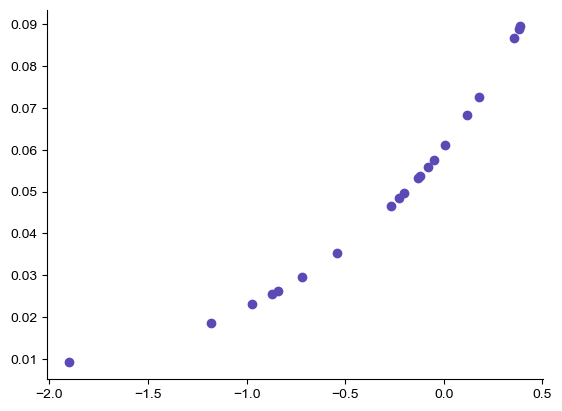

[[-0.22477467]
 [ 0.11789748]
 [-0.12960464]
 [ 0.1802015 ]
 [-1.179919  ]
 [-0.7206546 ]
 [-0.26781955]
 [-0.2015425 ]
 [-0.1212813 ]
 [-0.8384382 ]
 [ 0.38796234]
 [-0.08118628]
 [-1.898427  ]
 [ 0.38117862]
 [ 0.0076661 ]
 [-0.87027955]
 [-0.54063827]
 [-0.05210485]
 [ 0.35798597]
 [-0.9705439 ]]
[[0.04848983]
 [0.06830795]
 [0.05333133]
 [0.07269919]
 [0.01865678]
 [0.02953199]
 [0.04644687]
 [0.04962954]
 [0.05377709]
 [0.02625064]
 [0.08948679]
 [0.05597708]
 [0.00909479]
 [0.08888179]
 [0.06117844]
 [0.02542796]
 [0.03535679]
 [0.05762888]
 [0.08684411]
 [0.02300208]]


In [133]:
# convert this to an energy based model, and sample, like RES
scores = model_w_10p[:20,:]
scores_shift = scores - np.max(scores)
norm_prob_scores = get_norm_prob(scores_shift) # there is a shift in these probabilities

plt.figure()
plt.scatter(scores, norm_prob_scores)
plt.show()
print(scores)
print(norm_prob_scores)



In [134]:
sorted_tuples = sorted(list(zip(mean_hamming_pw_pmpnn, frac_alive_pmpnn)), key=lambda x: x[0]))
x_pmpnn = [k[0] for k in sorted_tuples]
y_pmpnn = [k[1] for k in sorted_tuples]

SyntaxError: unmatched ')' (2482743032.py, line 1)

# final graph of all sampling schemes together

In [135]:
# sample random sequences with penalty for higher hamming distance samples

def sample_biased_df_penalized_hamming(df, bias_scale=1, rand_seed = 42):
    np.random.seed(rand_seed)
    # higher more bias towards low hamming distance sequences
    # df needs a column 'hamming' to weight by
    idx_to_sample = list(range(len(df)))
    f_samples = [10**(-int(v)*bias_scale) for v in df.hamming]
    p_samples = np.array(f_samples)/math.fsum(f_samples)
    #print(p_samples)

    random_row_idxs = np.random.choice(idx_to_sample, n_unique_seq_sample, p=p_samples)
    random_row_idxs
    df_sample = df.iloc[random_row_idxs]
    return df_sample

In [43]:
np.random.randint(100)

50

In [50]:
# make random samples from the observed df
rand_seed = 42
np.random.seed(rand_seed)


df_10pos_rc3_no_stop['muts_only'] = df_10pos_rc3_no_stop.apply(lambda r: ':'.join([v[-1] for v in r.muts.split(':')]), axis=1)

frac_alive_pw_random =[]
mean_hamming_pw_random = []
for i in range(n_downsampling):
    for bias_scale in [-0.5,0,0.3,0.5, 0.7, 1, 1.5]:
        df_sample = sample_biased_df_penalized_hamming(df_10pos_rc3_no_stop, bias_scale=bias_scale, rand_seed = np.random.randint(100))
        #df_sample = df_10pos_rc3_no_stop.sample(n_unique_seq_sample)
        #df_sample

        muts = list(df_sample['muts_only'])
        muts_concat = get_muts_from_mutkeys(muts)

        x_sample = get_sampled_oh(muts) # getting the oh encoded X
        yhat = model.predict(x_sample) # getting model predictions

        pw_hamming = get_pairwise_hammings(muts_concat)
        mean_hamming_pw = np.mean(pw_hamming)


        frac_alive = np.sum([f>live_thresh for f in yhat])/len(yhat)

        frac_alive_pw_random.append(frac_alive)
        mean_hamming_pw_random.append(mean_hamming_pw)
print(len(frac_alive_pw_random))

70


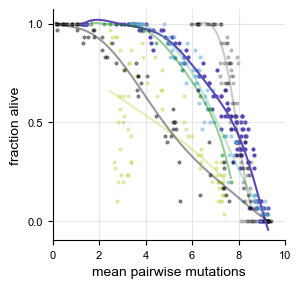

18
128
88
621
2177
3252
32
60
244
653
765


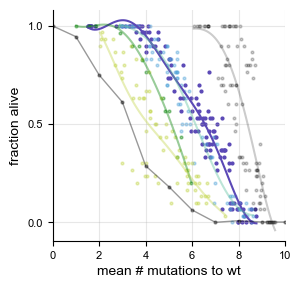

In [210]:
#['5B49B6', '52A4D9', '59C09D', 'B3EBAD', 'C3D64C', '9B9B9D']

def plot_polyline(x_in, y_in, 
                  order=8, 
                  fixed_points=([0,1, 10],[1,1, 0]),
                    color = 'black', 
                  alpha=1
                 ):

    x,y = fixed_points[0]+x_in, fixed_points[1]+y_in
    polyf = np.poly1d(np.polyfit(x,y, order))
    xp = np.linspace(min(x_in),max(x_in), 100)
    plt.plot(xp, polyf(xp), color=color, alpha=alpha)
#    plt.scatter(x_in, y_in)
#    plt.show()


alpha=0.4
ms = 4
plot_lw = 1
fig= plt.figure(figsize=(3,3))

#res
plt.scatter(mean_hamming_pw_res, frac_alive_res, label='RES', alpha=1, s=ms)
plot_polyline(mean_hamming_pw_res, frac_alive_res, color = '#5B49B6', alpha=1)

#pmpnn
plt.scatter(mean_hamming_pw_pmpnn, frac_alive_pmpnn, label ='pMPNN', color = 'green',alpha=alpha, s=ms)
plot_polyline(mean_hamming_pw_pmpnn, frac_alive_pmpnn, color = 'green', alpha=alpha)

'''
sorted_tuples = sorted(
    list(
        zip(mean_hamming_pw_pmpnn, frac_alive_pmpnn)
    ), 
    key=lambda x: x[0])
x_pmpnn = [k[0] for k in sorted_tuples]
y_pmpnn = [k[1] for k in sorted_tuples]
plt.plot(x_pmpnn, y_pmpnn, label ='pMPNN', color = '#52A4D9',alpha=alpha, lw=plot_lw)
'''
# esm
plt.scatter(mean_hamming_pw_esm, frac_alive_esm, label ='esm IF', alpha=alpha, s=ms)
plot_polyline(mean_hamming_pw_esm, frac_alive_esm, color= '#59C09D', alpha=alpha)

# evc
plt.scatter(mean_hamming_pw_evc, frac_alive_evc, label ='evC', color = '#C3D64C', alpha=alpha, s=ms)
plot_polyline(mean_hamming_pw_evc, frac_alive_evc, order = 3, color= '#C3D64C', alpha=alpha)

# random
plt.scatter(mean_hamming_pw_random, frac_alive_pw_random, label ='random', color = 'black', alpha=alpha, s=ms)
plot_polyline(mean_hamming_pw_random, frac_alive_pw_random, color= 'black', alpha=alpha, order=6)

# supervised
plt.scatter(mean_hamming_pw_lr, frac_alive_lr, label ='supervised', color='black', alpha=0.2, s=ms)
plot_polyline(mean_hamming_pw_lr, frac_alive_lr, order = 10,color= 'black', alpha=0.2, 
              fixed_points = ([0,1,2,3,4,5, 10],[1,1,1,1,1,1,0]))

plt.xlim([0,10])
#plt.legend(loc='center left', fontsize=8)
plt.xticks(list(range(11)))
plt.xticks([0,2,4,6,8,10], size=8)
plt.yticks([0,0.5,1], size=8)

#plt.legend()
plt.xlabel('mean pairwise mutations')
plt.ylabel('fraction alive')
#plt.title('pairwise hamming vs. fraction alive')
plt.grid(alpha=0.3)
fig.patch.set_visible(False)
plt.savefig(dout + 'frac_alive_vs_hamm_pw_renorm_dedup_res_sample_down_n10down.svg', format='svg')
plt.show()
###############################################################################################
fig= plt.figure(figsize=(3,3))

# res
plt.scatter(mean_hamming_wt_res, frac_alive_res, label='RES', alpha=1, s=ms)
plot_polyline(mean_hamming_wt_res, frac_alive_res, color = '#5B49B6', alpha=1)
# pmpnn
plt.scatter(mean_hamming_wt_pmpnn, frac_alive_pmpnn, label ='pMPNN', color = 'green',  alpha=alpha, s=ms)
plot_polyline(mean_hamming_wt_pmpnn, frac_alive_pmpnn, color = 'green', alpha=alpha)

'''
sorted_tuples = sorted(
    list(
        zip(mean_hamming_wt_pmpnn, frac_alive_pmpnn)
    ), 
    key=lambda x: x[0])
x_pmpnn = [k[0] for k in sorted_tuples]
y_pmpnn = [k[1] for k in sorted_tuples]
plt.plot(x_pmpnn, y_pmpnn, label ='pMPNN', color = '#52A4D9',alpha=alpha, lw=plot_lw)
'''
# esm
plt.scatter(mean_hamming_wt_esm, frac_alive_esm, label ='esm IF', alpha=alpha, s=ms)
plot_polyline(mean_hamming_wt_esm, frac_alive_esm, color = '#59C09D', alpha=alpha)

#evc
plt.scatter(mean_hamming_wt_evc, frac_alive_evc, label ='evC',color = '#C3D64C', alpha=alpha, s=ms)
plot_polyline(mean_hamming_wt_evc, frac_alive_evc, color = '#C3D64C', alpha=alpha)

# random
# plotting the random distribution of alive ones for a given hammign distribution, that's all of them that are measured.
dic_frac_alive_random = {}
for n_muts in range(11):
    df_exp_hamming = df_10pos_rc3_no_stop.loc[df_10pos_rc3_no_stop.hamming == n_muts]
    print(len(df_exp_hamming))
    frac_alive = float(sum(df_exp_hamming.mean_lrr_norm.values >0.5)) / float(len(df_exp_hamming))
    dic_frac_alive_random[n_muts] = frac_alive
plt.scatter(dic_frac_alive_random.keys(), dic_frac_alive_random.values(), label ='random', color = 'black',alpha=alpha, s=ms)
plt.plot(dic_frac_alive_random.keys(), dic_frac_alive_random.values(), label ='random', color = 'black',alpha=alpha, lw=plot_lw)

# supervised
plt.scatter(mean_hamming_wt_lr, frac_alive_lr, label ='supervised', color='black', alpha=0.2, s=ms)
plot_polyline(mean_hamming_wt_lr, frac_alive_lr, order = 6,color = 'black', alpha=0.2,
              fixed_points = ([0,1,2,3,4,5, 10],[1,1,1,1,1,1,0])
             )



#plt.legend(loc='center left', fontsize = 8)
plt.xlim([0,10])
plt.xticks([0,2,4,6,8,10], size=8)
plt.yticks([0,0.5,1], size=8)

plt.xlabel('mean # mutations to wt')
plt.ylabel('fraction alive')
#plt.legend()
#plt.title('hamming to wt vs. fraction alive')
plt.grid(alpha=0.3)
fig.patch.set_visible(False)
plt.savefig(dout + 'frac_alive_vs_hamm_wt_renorm_dedup_res_sample_down_n10down.svg', format='svg')
plt.show()

In [38]:
len(mean_hamming_pw_random)

50

In [39]:
len(frac_alive_pw_random)

50

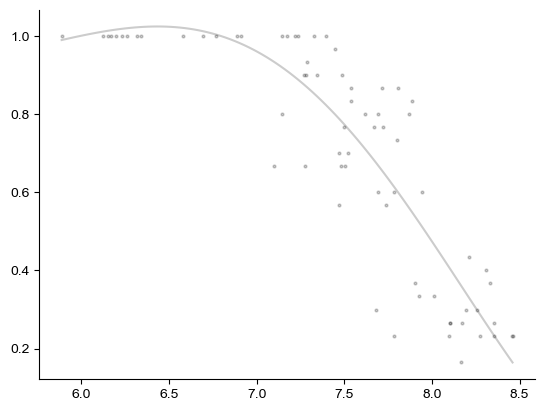

In [60]:
# supervised good
plt.figure()
plt.scatter(mean_hamming_pw_lr, frac_alive_lr, label ='supervised', color='black', alpha=0.2, s=ms)
plot_polyline(mean_hamming_pw_lr, frac_alive_lr, color= 'black', alpha=0.2, 
              fixed_points = ([0,1,2,3,4,5, 10],[1,1,1,1,1,1,0]))

plt.show()

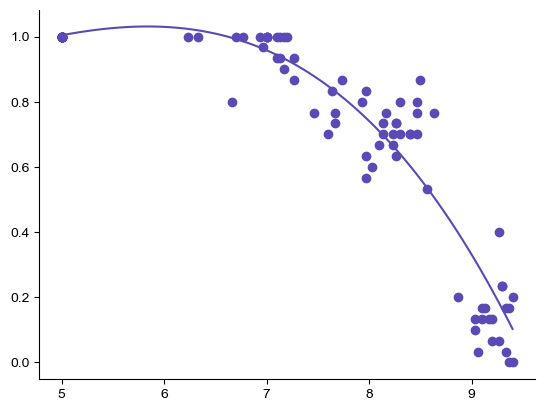

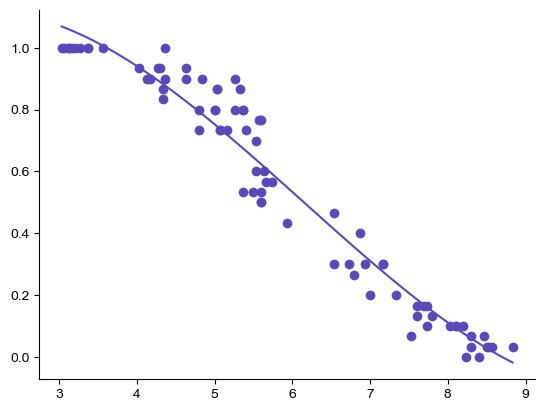

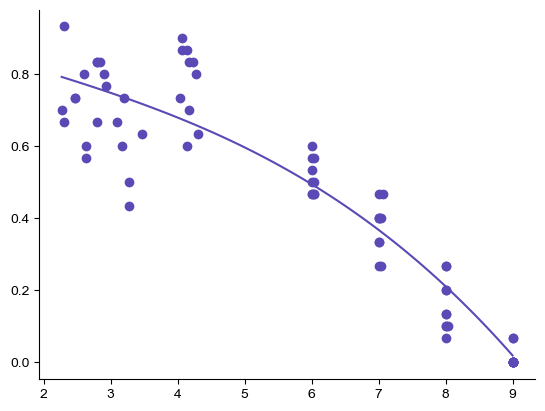

In [188]:


plot_polyline(mean_hamming_wt_lr, frac_alive_lr,order=3)#, #fixed_points = ([0,1,2,3,4, 10],[1,1,1,1,1,0]))

plot_polyline(mean_hamming_wt_esm, frac_alive_esm, 3,
             fixed_points = ([0,1,2,3, 10],[1,1,1,1,0])
             )
plot_polyline(mean_hamming_wt_evc, frac_alive_evc, 3)


In [59]:
mut_pos_m1

['L48', 'D52', 'I53', 'R55', 'L56', 'F74', 'R78', 'E80', 'A81', 'R82']

# get the best sequence from supervised model at a particular mutation distance

In [100]:
# go through different number of mutants from wt,find the best mutant with these combinations.

wt_mut_muts = [v[-1] for v in wt_muts_10x.split(':')]
print(wt_mut_muts)

dic_sampled_combi_mutants = {}

for num_muts in range(11):
    pos_to_mutate = sorted(random.sample(range(10), num_muts))
    
    list_mutant = []
    for p in range(10):
        if p not in pos_to_mutate:
            list_mutant.append(wt_mut_muts[p])
        else:
            idx_to_use = np.argmax(model_10_p_aa_pref[:,p], axis=0)
            sampled_mut_aa = AA_ALPHABET[idx_to_use]
            # if the max is the wt amino acid, choose the second best instead
            if sampled_mut_aa == wt_mut_muts[p]:
                idx_to_use = model_10_p_aa_pref[:,p].argsort()[-2]
                sampled_mut_aa = AA_ALPHABET[idx_to_use]
            list_mutant.append(sampled_mut_aa)    
    sampled_muts = ':'.join(list_mutant)
    x_sample = get_sampled_oh([sampled_muts])
    print(x_sample.shape)

    pred_fit = model_10p_no_stop.predict(x_sample)
    dic_sampled_combi_mutants[num_muts] = (sampled_muts, pred_fit)
    
dic_sampled_combi_mutants

['L', 'D', 'I', 'R', 'L', 'F', 'R', 'E', 'A', 'R']
(1, 201)
(1, 201)
(1, 201)
(1, 201)
(1, 201)
(1, 201)
(1, 201)
(1, 201)
(1, 201)
(1, 201)
(1, 201)


{0: ('L:D:I:R:L:F:R:E:A:R', array([[0.997455]], dtype=float32)),
 1: ('L:D:D:R:L:F:R:E:A:R', array([[0.99839526]], dtype=float32)),
 2: ('L:D:I:R:L:W:K:E:A:R', array([[0.9894376]], dtype=float32)),
 3: ('L:E:I:R:L:F:K:I:A:R', array([[0.9925603]], dtype=float32)),
 4: ('M:D:I:R:W:W:K:E:A:R', array([[0.9991404]], dtype=float32)),
 5: ('M:D:I:R:W:W:K:I:A:R', array([[0.99799675]], dtype=float32)),
 6: ('L:E:D:R:W:W:K:E:C:R', array([[0.9975767]], dtype=float32)),
 7: ('L:E:D:W:W:F:K:E:C:K', array([[0.99911225]], dtype=float32)),
 8: ('M:E:D:R:W:W:R:I:C:K', array([[0.9986343]], dtype=float32)),
 9: ('L:E:D:W:W:W:K:I:C:K', array([[0.9954267]], dtype=float32)),
 10: ('M:E:D:W:W:W:K:I:C:K', array([[0.9986541]], dtype=float32))}

In [75]:


model_w_10p[:20,:]

array([[-0.22477467],
       [ 0.11789748],
       [-0.12960464],
       [ 0.1802015 ],
       [-1.179919  ],
       [-0.7206546 ],
       [-0.26781955],
       [-0.2015425 ],
       [-0.1212813 ],
       [-0.8384382 ],
       [ 0.38796234],
       [-0.08118628],
       [-1.898427  ],
       [ 0.38117862],
       [ 0.0076661 ],
       [-0.87027955],
       [-0.54063827],
       [-0.05210485],
       [ 0.35798597],
       [-0.9705439 ]], dtype=float32)

In [76]:
model_10_p_aa_pref[:,0]

array([-0.22477467,  0.11789748, -0.12960464,  0.1802015 , -1.179919  ,
       -0.7206546 , -0.26781955, -0.2015425 , -0.1212813 , -0.8384382 ,
        0.38796234, -0.08118628, -1.898427  ,  0.38117862,  0.0076661 ,
       -0.87027955, -0.54063827, -0.05210485,  0.35798597, -0.9705439 ],
      dtype=float32)

In [78]:
np.argmax(model_10_p_aa_pref[:,0], axis=0)

10

In [81]:
model_10_p_aa_pref[:,0].argsort()[-3]

18

In [66]:
model_10_p_aa_pref[:,1]

array([ 0.11789748, -0.08118628, -0.9680575 , -1.4207143 , -0.9977526 ,
       -1.1882836 , -0.44383946, -1.3094938 , -0.2840725 , -3.2486832 ,
       -1.4559283 , -3.3546069 , -1.9658808 , -1.8484215 , -0.9458466 ,
       -0.95625806,  0.8031263 , -1.2416245 , -1.1336426 , -0.92530614],
      dtype=float32)

In [67]:
AA_ALPHABET[0]

'A'

In [68]:
for n_mut_dist,v in dic_sampled_combi_mutants.items():
    mut = v[0]
    full_mut = ','.join([v[:-1] + v2 for v, v2 in zip(wt_muts_10x.split(':'), mut.split(':'))])
    print(full_mut)

L47L,D51D,I52I,R54R,L55L,F73F,R77R,E79E,A80A,R81R
L47L,D51D,I52D,R54R,L55L,F73F,R77R,E79E,A80A,R81R
L47L,D51D,I52I,R54R,L55L,F73W,R77K,E79E,A80A,R81R
L47L,D51E,I52I,R54R,L55L,F73F,R77K,E79I,A80A,R81R
L47M,D51D,I52I,R54R,L55W,F73W,R77K,E79E,A80A,R81R
L47M,D51D,I52I,R54R,L55W,F73W,R77K,E79I,A80A,R81R
L47L,D51E,I52D,R54R,L55W,F73W,R77K,E79E,A80C,R81R
L47L,D51E,I52D,R54W,L55W,F73F,R77K,E79E,A80C,R81K
L47M,D51E,I52D,R54R,L55W,F73W,R77R,E79I,A80C,R81K
L47L,D51E,I52D,R54W,L55W,F73W,R77K,E79I,A80C,R81K
L47M,D51E,I52D,R54W,L55W,F73W,R77K,E79I,A80C,R81K


In [60]:
wt_muts_10x

'L47L:D51D:I52I:R54R:L55L:F73F:R77R:E79E:A80A:R81R'

In [95]:
x_sample = get_sampled_oh(['M:E:D:W:W:W:K:I:A:K'])
print(x_sample.shape)

model_10p_no_stop.predict(x_sample)

(1, 201)


array([[0.9993169]], dtype=float32)

In [ ]:
        muts = list(df_evc_gen['muts_only'])
        #display(df_evc_gen)
        
        if deduplicate:
            muts = list(set(muts))
            # downsample to match proteinMPNN numbers approximately
            muts = random.choices(muts, k=n_unique_seq_sample)
            muts_concat = get_muts_from_mutkeys(muts)
            #print(muts, muts_concat)
        else:
            muts_concat = list(df_esm_gen['muts'].values)
        #print('Esm samples considered:',len(muts))
        x_sample = get_sampled_oh(muts) # getting the oh encoded X
        yhat = model.predict(x_sample)

# GFP: plotting the sampled sequences in terms of predicted functionality

In [5]:
# train oracle function on gfp using mutkey as column

In [5]:
df_gfp = pd.read_csv('/n/groups/marks/users/david/ex62/final_data/DMS_data_from_ada/gfp_data_linear_lr.csv', 
                     index_col = 0)
# wt seq from pdb file
wt_gfp_seq = 'MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKRHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKTRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYN'

# df_gfp has an additional set of mutations as reference sequence
# convert this wt_gfp_seq to the one in the assay R80Q:T167I:N238K
list_wt_gfp_seq_dms = list(wt_gfp_seq)
for m in 'R80Q:T167I:N238K'.split(':'):
    wt_aa = m[0]
    pos = int(m[1:-1])-1
    mut_aa = m[-1]
    list_wt_gfp_seq_dms[pos] = mut_aa

# the wt seq made from df_dms
wt_gfp_seq_dms = ''.join(list_wt_gfp_seq_dms)

df_gfp.iloc[0].mutated_sequence




'MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRDEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK'

## train oracle function on gfp - column mutated sequence


In [7]:
# train oracle function on gfp

df_gfp = pd.read_csv('/n/groups/marks/users/david/ex62/final_data/DMS_data_from_ada/gfp_data_linear_lr.csv', 
                     index_col = 0)
df_gfp['oh_code'] = df_gfp.apply(lambda r: seq_to_oh(r.mutated_sequence, d_aa_to_oh_pos), axis=1)

X = np.stack(list(df_gfp['oh_code'].values), axis=0)
X= np.c_[X,np.ones(X.shape[0])]
print(X.shape)
Y = df_gfp.DMS_score.values


# find the half-maximal DMS score
threshold = (max(df_gfp.DMS_score) - min(df_gfp.DMS_score))/2 + min(df_gfp.DMS_score)
print(threshold)


(51714, 4999)
2.7032641513550004


(4999, 1)
layer0 weights set to:  [[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
beta_hat [0. 0. 0. 0. 0.]


2023-06-01 14:19:43.263607: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1034073144 exceeds 10% of free system memory.


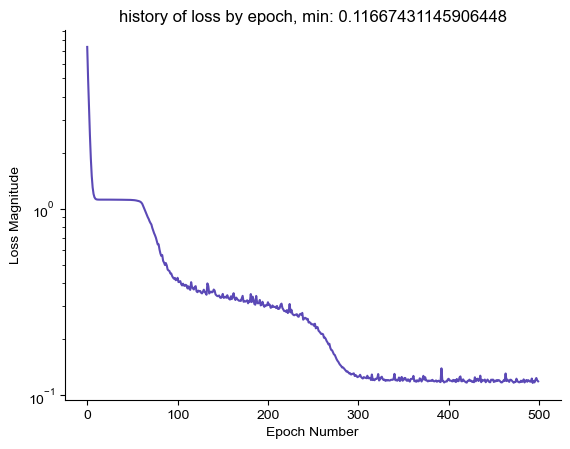

2023-06-01 14:23:22.550284: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1034073144 exceeds 10% of free system memory.


In [8]:
adam_lr = 0.005
model, history, callbacks =fit_log_model(X, Y, 
                                        my_layer=log_layer_scale_shift(1, reg_strength=0),
                                        adam_lr =adam_lr,
                                         epochs=500,
                                         batch_size=1000, 
                                         rand_seed=3)

Yhat_non= model.predict(X).flatten()
df_gfp['nonlinear_predict'] = Yhat_non


In [9]:
'''
# something in model weight saving and loading not working
gfp_model_checkpoint_dir = '/n/groups/marks/users/david/ex62/log_reg_w/gfp_chpt/'
# Save the weights
model.save_weights(gfp_model_checkpoint_dir)


# set up the model
my_log_layer = log_layer_scale_shift(1, reg_strength=0)
my_log_layer.build(X.shape)
model_from_save = tf.keras.Sequential([my_log_layer])
#print(model)
#print(model.layers[1#])
# Compile model
#adam_lr = 0.005

#model.compile(loss=tf.keras.losses.MeanSquaredError(),#tf.keras.losses.MeanAbsoluteError(),
#            optimizer=tf.keras.optimizers.Adam(learning_rate = adam_lr))

model_from_save.load_weights(gfp_model_checkpoint_dir)

yhat_non = model_from_save.predict(X).flatten()

plt.figure()
plt.scatter(Y, yhat_non, s=0.001)
plt.show()
'''

"\n# something in model weight saving and loading not working\ngfp_model_checkpoint_dir = '/n/groups/marks/users/david/ex62/log_reg_w/gfp_chpt/'\n# Save the weights\nmodel.save_weights(gfp_model_checkpoint_dir)\n\n\n# set up the model\nmy_log_layer = log_layer_scale_shift(1, reg_strength=0)\nmy_log_layer.build(X.shape)\nmodel_from_save = tf.keras.Sequential([my_log_layer])\n#print(model)\n#print(model.layers[1#])\n# Compile model\n#adam_lr = 0.005\n\n#model.compile(loss=tf.keras.losses.MeanSquaredError(),#tf.keras.losses.MeanAbsoluteError(),\n#            optimizer=tf.keras.optimizers.Adam(learning_rate = adam_lr))\n\nmodel_from_save.load_weights(gfp_model_checkpoint_dir)\n\nyhat_non = model_from_save.predict(X).flatten()\n\nplt.figure()\nplt.scatter(Y, yhat_non, s=0.001)\nplt.show()\n"

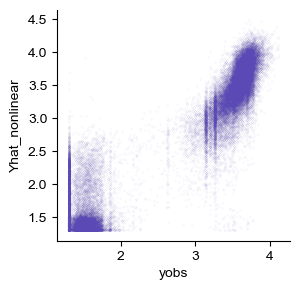

In [10]:
plt.figure(figsize=(3,3))
plt.scatter(Y, Yhat_non, s=0.001)
plt.xlabel('yobs')
plt.ylabel('Yhat_nonlinear')
plt.show()

In [ ]:
# maybe plot the learned function. using a different part of the sigmoid here, at low values.

# plotting sampled sequences

## calculate fraction alive given the observed data


In [11]:
df_gfp['hamming_wt'] = df_gfp.mutated_sequence.apply(lambda x: hamming(wt_gfp_seq_dms,x))
df_gfp

list_hamming_obs = []
list_fraction_alive_obs = []
for n_muts in sorted(list(set(df_gfp.hamming_wt))):
    df_gfp_n_hamm = df_gfp.loc[df_gfp.hamming_wt == n_muts]
    print(n_muts, len(df_gfp_n_hamm))
    f_alive = sum(df_gfp_n_hamm.DMS_score > threshold)/len(df_gfp_n_hamm)
    list_fraction_alive_obs.append(f_alive)
    list_hamming_obs.append(n_muts)

1 1084
2 12777
3 12336
4 9387
5 6825
6 4298
7 2526
8 1364
9 627
10 299
11 118
12 43
13 23
14 5
15 2


In [6]:
muts_seen_dms = set([ind_m for m in df_gfp.mutant for ind_m in m.split(':') ])
print(len(muts_seen_dms))
print(len(set([m[1:-1] for m in muts_seen_dms])))


1810
233


# reading COVES samples in

In [12]:
def get_mutseq_from_mutkey(mutkey, wt_seq, offset=0):
    if mutkey == '':
        return ''
    mutseq_list = list(wt_seq)
    for m in mutkey.split(':'):
        #print(m)
        wt_aa = m[0]
        pos = int(m[1:-1]) + offset
        mut_aa = m[-1]
        try:
            assert mutseq_list[pos] == wt_aa
        except AssertionError:
            print(pos, wt_aa, mutseq_list[pos])
        mutseq_list[pos] = mut_aa
    return ''.join(mutseq_list)

def read_sampling_file_res(fin):
    # takes a file with mutkeys and reconstrcuts the wt_sequence with wt_gfp_seq_dms
    
    # get the mutated keys
    mutkeys = read_sampled_mut_key(fin)
    print(len(mutkeys))
    unique_mutkeys_gen = list(set(mutkeys))

    # filter out wt mutkeys, worried they might affect prediction from LR model
    unique_mutkeys_gen_no_wt = [':'.join([m for m in mks.split(':') if m[0]!=m[-1]]) for mks in unique_mutkeys_gen]
    print(len(unique_mutkeys_gen_no_wt))

    # reconstruct the mutated sequence from these mutkeys
    unique_mutseq_gen = [get_mutseq_from_mutkey(mk, wt_gfp_seq_dms, offset=-1) for mk in unique_mutkeys_gen_no_wt]


    df_gen_seqs = pd.DataFrame({'gen_seq': unique_mutseq_gen, 'mutkey': unique_mutkeys_gen_no_wt})

    # filter out the gen seqs that don't have any mutants
    df_gen_seqs = df_gen_seqs.loc[df_gen_seqs.mutkey != '']
    df_gen_seqs['oh'] = df_gen_seqs.apply(lambda r: seq_to_oh(r.gen_seq, d_aa_to_oh_pos), axis=1)

    # filtered for seen mutants in generation script.
    #df_gen_seqs['all_muts_seen_in_exp'] = df_gen_seqs.apply(
    #    lambda r: not bool(sum([(m not in muts_seen_dms) for m in r.mutkey.split(':')])), axis=1)
    #display(df_gen_seqs)

    #df_gen_seqs_seen = df_gen_seqs.loc[df_gen_seqs.all_muts_seen_in_exp]
    #n_gen_seqs_seen = len(df_gen_seqs_seen)
    #print('n generated samples seen in exp:', n_gen_seqs_seen)

    return df_gen_seqs


def get_model_predictions(model, df_gen_seqs):
    X_gen = np.stack(list(df_gen_seqs['oh'].values), axis=0)
    X_gen= np.c_[X_gen,np.ones(X_gen.shape[0])]
    print(X_gen.shape)

    # evaluate sampled sequences
    # filtered for mutations that predictions can be made about

    yhat_non_gen = model.predict(X_gen).flatten()
    return X_gen, yhat_non_gen

def collate_sampling_results_coves(din, 
                                   model, 
                                   muts_seen_dms, 
                                   wt_gfp_seq_dms, 
                                   threshold,
                                   suffix_filter='230528.csv', 
                                   suffix_exclude = 'all_gvp_pred.csv'):
    # to collate the results of model samples across temperatures, n_pos_mutate and sample number
    
    
    df_coves = pd.DataFrame(columns=['t', 'max_mut', 'average_wt_hamming', 'frac_above_thresh', 'n_muts_seen', 'n_muts_sampled'])

    fs = [f for f in listdir(din) if f.endswith(suffix_filter) and not f.endswith(suffix_exclude)]
    for f in fs:
        # reading the params from the file name
        t = float(f.split('_')[10][1:])
        n_sample = int(f.split('_')[11][1:])
        n_pos_mutate = int(float(f.split('_')[12][10:]))
        print(f'reading f with t{t}, n_sample{n_sample}, n_pos_mutate{n_pos_mutate}')
        
        # read the res file
        df_gen_seqs = read_sampling_file_res(din + f)
        
        ##### filtering read in files for whether oracle can make predictions about.
        # filter generated sequences by whether they have less than 15 mutations (maximum of oracle trained data)
        df_gen_seqs['hamming'] = df_gen_seqs['gen_seq'].apply(lambda s: hamming(wt_gfp_seq_dms,s))
        df_gen_seqs = df_gen_seqs.loc[df_gen_seqs.hamming <15]
        
        # filter generated sequences by whether they have all been seen in experiment.
        df_gen_seqs['all_seen'] = df_gen_seqs.mutkey.apply(lambda mk: not bool(sum([1 for m in mk.split(':') if m not in muts_seen_dms])))
        df_gen_seqs = df_gen_seqs.loc[df_gen_seqs.all_seen]
        
        if len(df_gen_seqs) > 5:
            ###### make predicions 
            # get oracle predictions on the generated sequences.
            X_gen, yhat_non_gen = get_model_predictions(model, df_gen_seqs)

            # calculate summary statistics
            frac_above_thresh = sum(yhat_non_gen>threshold)/len(yhat_non_gen)
            ham_dists_wt = [hamming(wt_gfp_seq_dms,mutseq) for mutseq in df_gen_seqs['gen_seq']]
            average_wt_hamming = np.mean(ham_dists_wt)

            dic_row_result = {'t':t, 
                              'max_mut':n_pos_mutate, 
                              'average_wt_hamming':average_wt_hamming, 
                              'frac_above_thresh':frac_above_thresh, 
                             'n_muts_seen': len(df_gen_seqs),
                             'n_muts_sampled': n_sample}
            df_coves = df_coves.append(dic_row_result, ignore_index=True)
    return df_coves

In [15]:


sample_din = './gvp_samples/gfp_samples/'

df_coves_sampling_results_all = collate_sampling_results_coves(sample_din, 
                                                               model, 
                                                               muts_seen_dms, 
                                                               wt_gfp_seq_dms, 
                                                               threshold,
                                                               suffix_filter='230528.csv', 
                                                               suffix_exclude = 'all_gvp_pred.csv')

reading f with t1.0, n_sample300, n_pos_mutate8
286
286
(282, 4999)
reading f with t1.0, n_sample300, n_pos_mutate13
289
289


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(289, 4999)
reading f with t0.5, n_sample300, n_pos_mutate17
286
286


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(286, 4999)
reading f with t1.0, n_sample300, n_pos_mutate14
278
278


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(277, 4999)
reading f with t1.0, n_sample300, n_pos_mutate16
284
284


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(284, 4999)
reading f with t10.0, n_sample300, n_pos_mutate15
285
285


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(274, 4999)
reading f with t2.0, n_sample300, n_pos_mutate9
285
285


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(285, 4999)
reading f with t2.5, n_sample300, n_pos_mutate10
279
279


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(279, 4999)
reading f with t0.7, n_sample300, n_pos_mutate10
288
288


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(287, 4999)
reading f with t0.6, n_sample300, n_pos_mutate10
285
285


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(284, 4999)
reading f with t2.5, n_sample300, n_pos_mutate13
289
289


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(289, 4999)
reading f with t0.5, n_sample300, n_pos_mutate16
282
282


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(282, 4999)
reading f with t1.0, n_sample300, n_pos_mutate11
287
287


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(286, 4999)
reading f with t2.0, n_sample300, n_pos_mutate14
279
279


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(279, 4999)
reading f with t2.0, n_sample300, n_pos_mutate10
278
278


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(278, 4999)
reading f with t3.0, n_sample300, n_pos_mutate15
283
283


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(283, 4999)
reading f with t1.0, n_sample300, n_pos_mutate9
288
288


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(287, 4999)
reading f with t0.6, n_sample300, n_pos_mutate5
281
281


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(265, 4999)
reading f with t2.5, n_sample300, n_pos_mutate9
284
284


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(283, 4999)
reading f with t0.5, n_sample300, n_pos_mutate6
284
284


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(273, 4999)
reading f with t0.5, n_sample300, n_pos_mutate10
285
285


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(284, 4999)
reading f with t0.3, n_sample300, n_pos_mutate5
285
285


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(256, 4999)
reading f with t1.0, n_sample300, n_pos_mutate15
280
280


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(280, 4999)
reading f with t3.0, n_sample300, n_pos_mutate7
277
277


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(277, 4999)
reading f with t2.0, n_sample300, n_pos_mutate11
287
287


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(287, 4999)
reading f with t10.0, n_sample300, n_pos_mutate5
287
287


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(287, 4999)
reading f with t0.5, n_sample300, n_pos_mutate9
282
282


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(278, 4999)
reading f with t2.5, n_sample300, n_pos_mutate7
281
281


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(281, 4999)
reading f with t1.0, n_sample300, n_pos_mutate10
288
288


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(288, 4999)
reading f with t4.0, n_sample300, n_pos_mutate5
281
281


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(279, 4999)
reading f with t1.0, n_sample300, n_pos_mutate18
287
287


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(287, 4999)
reading f with t5.0, n_sample300, n_pos_mutate10
288
288


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(288, 4999)
reading f with t1.0, n_sample300, n_pos_mutate12
282
282


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(282, 4999)
reading f with t2.5, n_sample300, n_pos_mutate5
287
287


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(284, 4999)
reading f with t2.5, n_sample300, n_pos_mutate8
282
282


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(282, 4999)
reading f with t2.0, n_sample300, n_pos_mutate13
281
281


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(281, 4999)
reading f with t0.4, n_sample300, n_pos_mutate10
290
290


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(287, 4999)
reading f with t3.0, n_sample300, n_pos_mutate11
284
284


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(284, 4999)
reading f with t5.0, n_sample300, n_pos_mutate15
285
285


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(282, 4999)
reading f with t1.0, n_sample300, n_pos_mutate19
285
285


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(284, 4999)
reading f with t1.0, n_sample300, n_pos_mutate5
287
287


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(276, 4999)
reading f with t0.5, n_sample300, n_pos_mutate19
288
288


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(288, 4999)
reading f with t4.0, n_sample300, n_pos_mutate10
284
284


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(284, 4999)
reading f with t3.0, n_sample300, n_pos_mutate12


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


288
288
(288, 4999)
reading f with t3.0, n_sample300, n_pos_mutate8
286
286


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(285, 4999)
reading f with t3.0, n_sample300, n_pos_mutate13
288
288


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(288, 4999)
reading f with t3.0, n_sample300, n_pos_mutate5
282
282


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(282, 4999)
reading f with t2.5, n_sample300, n_pos_mutate11
289
289


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(289, 4999)
reading f with t4.0, n_sample300, n_pos_mutate15
284
284


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(282, 4999)
reading f with t2.5, n_sample300, n_pos_mutate15
291
291


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(291, 4999)
reading f with t0.5, n_sample300, n_pos_mutate15
280
280


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(280, 4999)
reading f with t0.5, n_sample300, n_pos_mutate8
280
280


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(274, 4999)
reading f with t2.5, n_sample300, n_pos_mutate14
289
289


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(289, 4999)
reading f with t0.1, n_sample300, n_pos_mutate5
282
282


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(264, 4999)
reading f with t20.0, n_sample300, n_pos_mutate15
278
278


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(251, 4999)
reading f with t0.1, n_sample300, n_pos_mutate15
280
280


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(280, 4999)
reading f with t2.0, n_sample300, n_pos_mutate12
281
281


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(281, 4999)
reading f with t0.5, n_sample300, n_pos_mutate7
285
285


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(278, 4999)
reading f with t2.0, n_sample300, n_pos_mutate7
284
284


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(284, 4999)
reading f with t20.0, n_sample300, n_pos_mutate10
288
288


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(288, 4999)
reading f with t0.5, n_sample300, n_pos_mutate5
284
284


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(267, 4999)
reading f with t2.0, n_sample300, n_pos_mutate5
284
284


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(281, 4999)
reading f with t10.0, n_sample300, n_pos_mutate10
282
282


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(282, 4999)
reading f with t0.7, n_sample300, n_pos_mutate15
282
282


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(282, 4999)
reading f with t0.5, n_sample300, n_pos_mutate20
284
284


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(284, 4999)
reading f with t0.5, n_sample300, n_pos_mutate18
283
283


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(283, 4999)
reading f with t8.0, n_sample300, n_pos_mutate15
278
278


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(272, 4999)
reading f with t2.5, n_sample300, n_pos_mutate6
286
286


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(285, 4999)
reading f with t20.0, n_sample300, n_pos_mutate5
287
287


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(287, 4999)
reading f with t5.0, n_sample300, n_pos_mutate5
291
291


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(291, 4999)
reading f with t3.0, n_sample300, n_pos_mutate9
282
282


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(282, 4999)
reading f with t0.5, n_sample300, n_pos_mutate13
271
271


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(271, 4999)
reading f with t0.5, n_sample300, n_pos_mutate11
286
286


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(284, 4999)
reading f with t8.0, n_sample300, n_pos_mutate5
288
288


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(288, 4999)
reading f with t3.0, n_sample300, n_pos_mutate10
285
285


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(285, 4999)
reading f with t0.4, n_sample300, n_pos_mutate5
284
284


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(263, 4999)
reading f with t0.3, n_sample300, n_pos_mutate15
289
289


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(288, 4999)
reading f with t0.6, n_sample300, n_pos_mutate15
277
277


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(277, 4999)
reading f with t3.0, n_sample300, n_pos_mutate14
284
284


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(284, 4999)
reading f with t0.5, n_sample300, n_pos_mutate14
283
283


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(283, 4999)
reading f with t3.0, n_sample300, n_pos_mutate6
289
289


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(289, 4999)
reading f with t0.7, n_sample300, n_pos_mutate5
287
287


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(271, 4999)
reading f with t2.0, n_sample300, n_pos_mutate6
289
289


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(287, 4999)
reading f with t2.5, n_sample300, n_pos_mutate12
285
285


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(285, 4999)
reading f with t1.0, n_sample300, n_pos_mutate7
283
283


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(280, 4999)
reading f with t0.3, n_sample300, n_pos_mutate10
277
277


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(276, 4999)
reading f with t1.0, n_sample300, n_pos_mutate20
287
287


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(284, 4999)
reading f with t0.1, n_sample300, n_pos_mutate10
292
292


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(291, 4999)
reading f with t1.0, n_sample300, n_pos_mutate6
287
287


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(279, 4999)
reading f with t0.4, n_sample300, n_pos_mutate15
281
281


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(281, 4999)
reading f with t1.0, n_sample300, n_pos_mutate17
285
285


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(285, 4999)
reading f with t0.5, n_sample300, n_pos_mutate12
283
283


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(282, 4999)
reading f with t2.0, n_sample300, n_pos_mutate8
287
287


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(286, 4999)
reading f with t2.0, n_sample300, n_pos_mutate15
282
282


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(282, 4999)
reading f with t8.0, n_sample300, n_pos_mutate10
288
288


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


(288, 4999)


/tmp/ipykernel_24667/2231313335.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_coves = df_coves.append(dic_row_result, ignore_index=True)


## read ESM generation files in:

In [16]:

def convert_to_dms_wt(mut_seq, list_to_change = ['R80Q','T167I','N238K']):
    # oracle is trained on the dms-wild-type sequence, rather than the PDB wt sequence.
    # used the wrong end of the wild type sequence to reconstruct the wt sequence in the sampling code.
    #wt_gfp_seq_dms  # has these mutations compared to the wt_pdb sequence: 'R80Q:T167I:N238K'
    #wt_gfp_seq      # has these mutations compared to wt_dms_seq: 'Q80R:I167T:K238N'

    #conv_seq_1 = convert_to_dms_wt(df_gen_seqs.iloc[0].gen_seq)
    #hamming(wt_gfp_seq_dms, conv_seq_1)
    # takes a sequence and converts any potential mutaitons that are PDB wild-type, rather than DMS wild-type reference
    list_mut_seq = list(mut_seq)
    for mk in list_to_change:
        true_ref_aa = mk[-1]
        pos = int(mk[1:-1])-1
        wrong_ref_aa = mk[0]
        if list_mut_seq[pos] == wrong_ref_aa:
            list_mut_seq[pos] = true_ref_aa
    return ''.join(list_mut_seq)

def seq_with_valid_alphabet(seq, alphabet):
    # takes a sequences and returns bool of whether all characters are seen in alphabet
    # required to filter esm samples that have weird characters
    #seq_with_valid_alphabet('ACD<', AA_ALPHABET_STOP)
    all_valid = sum([s in alphabet for s in seq])
    if all_valid == len(seq):
        return True
    else:
        return False

def read_sampling_file_esm(fin):
    df_esm = pd.read_csv(fin, header=None)
    
    # need to insert a 'SYG' at position 64 for ESM sampled sequences. it skips the 3 fluoropore residues
    unique_mutseq_gen = [s[:64] +'SYG'+s[64:] for s in list(set(df_esm[0].values))]
    
    # have to make sure the reconstructed sequence has the wt_gfp_seq_dms as background, before making oh
    unique_mutseq_gen = [convert_to_dms_wt(s) for s in unique_mutseq_gen]
    
    # get rid of sequence with funny symbols
    unique_mutseq_gen = [s for s in unique_mutseq_gen if seq_with_valid_alphabet(s, AA_ALPHABET_STOP)]

    df_gen_seqs = pd.DataFrame({'gen_seq': unique_mutseq_gen})
    
    df_gen_seqs['oh'] = df_gen_seqs.apply(lambda r: seq_to_oh(r.gen_seq, d_aa_to_oh_pos), axis=1)
    return df_gen_seqs

def get_mutkey_from_mutseq(mut_seq, wt_seq):
    return ':'.join([wt_aa +str(i+1)+mut_aa for i,(wt_aa,mut_aa) in enumerate(zip(wt_seq, mut_seq)) if wt_aa!=mut_aa])

def collate_sampling_results_esm(din, 
                                   model, 
                                   muts_seen_dms, 
                                   wt_gfp_seq_dms,
                                   list_muts_dms_exclude, # list of mutations
                                   threshold,
                                   suffix_filter='.csv'
                                ):
    # to collate the results of model samples across temperatures, n_pos_mutate and sample number
    
    
    df_esm = pd.DataFrame(columns=['t', 'max_mut', 'average_wt_hamming', 'frac_above_thresh', 'n_muts_seen', 'n_muts_sampled'])

    fs = [f for f in listdir(din) if f.endswith(suffix_filter)]
    for f in fs:
        # reading the params from the file name
        t = float(f.split('_')[1][1:])
        n_sample = int(f.split('_')[2][1:])
        n_pos_mutate = int(float(f.split('_')[5][6:-3]))
        print(f'reading f with t{t}, n_sample{n_sample}, n_pos_mutate{n_pos_mutate}')
        
        # read the res file
        df_gen_seqs = read_sampling_file_esm(din + f)
        
        df_gen_seqs['mutkey_wrt_dms'] = df_gen_seqs.gen_seq.apply(lambda s: get_mutkey_from_mutseq(s, wt_gfp_seq_dms))
        # these are only the mutants without the reference mutant changes.
        df_gen_seqs['mutkey'] = df_gen_seqs['mutkey_wrt_dms'].apply(lambda mks:':'.join([m for m in mks.split(':') if m not in list_muts_dms_exclude]))
        
        
        ##### filtering read in files for whether oracle can make predictions about.
        # filter generated sequences by whether they have less than 15 mutations (maximum of oracle trained data)
        df_gen_seqs['hamming'] = df_gen_seqs['gen_seq'].apply(lambda s: hamming(wt_gfp_seq_dms,s))
        df_gen_seqs = df_gen_seqs.loc[df_gen_seqs.hamming <15]
        
        # filter generated sequences by whether they have all been seen in experiment.
        df_gen_seqs['all_seen'] = df_gen_seqs.mutkey.apply(lambda mk: not bool(sum([1 for m in mk.split(':') if m not in muts_seen_dms])))
        df_gen_seqs = df_gen_seqs.loc[df_gen_seqs.all_seen]
        
        # filter for at least 5 generated sequences passing filters to not have too much noise in plotting
        if len(df_gen_seqs) > 5:
            ###### make predicions 
            # get oracle predictions on the generated sequences.
            X_gen, yhat_non_gen = get_model_predictions(model, df_gen_seqs)

            # calculate summary statistics
            frac_above_thresh = sum(yhat_non_gen>threshold)/len(yhat_non_gen)
            ham_dists_wt = [hamming(wt_gfp_seq_dms,mutseq) for mutseq in df_gen_seqs['gen_seq']]
            average_wt_hamming = np.mean(ham_dists_wt)

            dic_row_result = {'t':t, 
                              'max_mut':n_pos_mutate, 
                              'average_wt_hamming':average_wt_hamming, 
                              'frac_above_thresh':frac_above_thresh, 
                             'n_muts_seen': len(df_gen_seqs),
                             'n_muts_sampled': n_sample}
            df_esm = df_esm.append(dic_row_result, ignore_index=True)
    return df_esm



In [17]:
esm_dout_samples = "/n/groups/marks/users/david/esm_if/data/gen_seqs/gfp/"

list_muts_dms_exclude = ['R80Q','T167I','N238K']
df_result_esm_all = collate_sampling_results_esm(esm_dout_samples, 
                                               model, 
                                               muts_seen_dms, 
                                               wt_gfp_seq_dms,
                                               list_muts_dms_exclude, # list of mutations
                                               threshold,
                                               suffix_filter='.csv')

reading f with t3.0, n_sample400, n_pos_mutate5
(40, 4999)
reading f with t0.5, n_sample400, n_pos_mutate11


/tmp/ipykernel_24667/2175242219.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_esm = df_esm.append(dic_row_result, ignore_index=True)


(50, 4999)
reading f with t0.001, n_sample400, n_pos_mutate10


/tmp/ipykernel_24667/2175242219.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_esm = df_esm.append(dic_row_result, ignore_index=True)


(64, 4999)
reading f with t2.0, n_sample400, n_pos_mutate10


/tmp/ipykernel_24667/2175242219.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_esm = df_esm.append(dic_row_result, ignore_index=True)


(12, 4999)
reading f with t5.0, n_sample400, n_pos_mutate10


/tmp/ipykernel_24667/2175242219.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_esm = df_esm.append(dic_row_result, ignore_index=True)


reading f with t30.0, n_sample400, n_pos_mutate5
reading f with t0.1, n_sample400, n_pos_mutate5
(103, 4999)
reading f with t1.75, n_sample400, n_pos_mutate5


/tmp/ipykernel_24667/2175242219.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_esm = df_esm.append(dic_row_result, ignore_index=True)


(95, 4999)
reading f with t10.0, n_sample400, n_pos_mutate15
reading f with t1.75, n_sample400, n_pos_mutate10


/tmp/ipykernel_24667/2175242219.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_esm = df_esm.append(dic_row_result, ignore_index=True)


(15, 4999)
reading f with t1.25, n_sample400, n_pos_mutate15


/tmp/ipykernel_24667/2175242219.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_esm = df_esm.append(dic_row_result, ignore_index=True)


(9, 4999)
reading f with t4.0, n_sample400, n_pos_mutate10


/tmp/ipykernel_24667/2175242219.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_esm = df_esm.append(dic_row_result, ignore_index=True)


reading f with t5.0, n_sample400, n_pos_mutate5
(17, 4999)
reading f with t0.75, n_sample400, n_pos_mutate19


/tmp/ipykernel_24667/2175242219.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_esm = df_esm.append(dic_row_result, ignore_index=True)


reading f with t1000.0, n_sample400, n_pos_mutate10
reading f with t0.75, n_sample400, n_pos_mutate10
(53, 4999)
reading f with t1000.0, n_sample400, n_pos_mutate5
reading f with t1.0, n_sample400, n_pos_mutate17


/tmp/ipykernel_24667/2175242219.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_esm = df_esm.append(dic_row_result, ignore_index=True)


(7, 4999)
reading f with t1.0, n_sample400, n_pos_mutate11


/tmp/ipykernel_24667/2175242219.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_esm = df_esm.append(dic_row_result, ignore_index=True)


(34, 4999)
reading f with t80.0, n_sample400, n_pos_mutate5
reading f with t1.0, n_sample400, n_pos_mutate7


/tmp/ipykernel_24667/2175242219.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_esm = df_esm.append(dic_row_result, ignore_index=True)


(77, 4999)
reading f with t0.75, n_sample400, n_pos_mutate15


/tmp/ipykernel_24667/2175242219.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_esm = df_esm.append(dic_row_result, ignore_index=True)


(21, 4999)
reading f with t0.5, n_sample400, n_pos_mutate9


/tmp/ipykernel_24667/2175242219.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_esm = df_esm.append(dic_row_result, ignore_index=True)


(71, 4999)
reading f with t0.75, n_sample400, n_pos_mutate7


/tmp/ipykernel_24667/2175242219.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_esm = df_esm.append(dic_row_result, ignore_index=True)


(82, 4999)
reading f with t20.0, n_sample400, n_pos_mutate10
reading f with t3.0, n_sample400, n_pos_mutate15


/tmp/ipykernel_24667/2175242219.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_esm = df_esm.append(dic_row_result, ignore_index=True)


reading f with t0.75, n_sample400, n_pos_mutate17
(10, 4999)
reading f with t0.5, n_sample400, n_pos_mutate7


/tmp/ipykernel_24667/2175242219.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_esm = df_esm.append(dic_row_result, ignore_index=True)


(82, 4999)
reading f with t0.75, n_sample400, n_pos_mutate5


/tmp/ipykernel_24667/2175242219.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_esm = df_esm.append(dic_row_result, ignore_index=True)


(127, 4999)
reading f with t4.0, n_sample400, n_pos_mutate15


/tmp/ipykernel_24667/2175242219.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_esm = df_esm.append(dic_row_result, ignore_index=True)


reading f with t100.0, n_sample400, n_pos_mutate10
reading f with t200.0, n_sample400, n_pos_mutate10
reading f with t80.0, n_sample400, n_pos_mutate10
reading f with t0.1, n_sample400, n_pos_mutate15
(35, 4999)
reading f with t1.5, n_sample400, n_pos_mutate5


/tmp/ipykernel_24667/2175242219.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_esm = df_esm.append(dic_row_result, ignore_index=True)


(98, 4999)
reading f with t0.1, n_sample400, n_pos_mutate10


/tmp/ipykernel_24667/2175242219.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_esm = df_esm.append(dic_row_result, ignore_index=True)


(55, 4999)
reading f with t0.5, n_sample400, n_pos_mutate19


/tmp/ipykernel_24667/2175242219.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_esm = df_esm.append(dic_row_result, ignore_index=True)


(9, 4999)
reading f with t10.0, n_sample400, n_pos_mutate5


/tmp/ipykernel_24667/2175242219.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_esm = df_esm.append(dic_row_result, ignore_index=True)


(7, 4999)
reading f with t200.0, n_sample400, n_pos_mutate5
reading f with t100.0, n_sample400, n_pos_mutate5
reading f with t0.01, n_sample400, n_pos_mutate15


/tmp/ipykernel_24667/2175242219.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_esm = df_esm.append(dic_row_result, ignore_index=True)


(30, 4999)


/tmp/ipykernel_24667/2175242219.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_esm = df_esm.append(dic_row_result, ignore_index=True)


reading f with t0.75, n_sample400, n_pos_mutate9
(83, 4999)
reading f with t70.0, n_sample400, n_pos_mutate5
reading f with t1.75, n_sample400, n_pos_mutate15


/tmp/ipykernel_24667/2175242219.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_esm = df_esm.append(dic_row_result, ignore_index=True)


reading f with t1.0, n_sample400, n_pos_mutate15
(8, 4999)
reading f with t0.5, n_sample400, n_pos_mutate15


/tmp/ipykernel_24667/2175242219.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_esm = df_esm.append(dic_row_result, ignore_index=True)


(18, 4999)
reading f with t1.25, n_sample400, n_pos_mutate5


/tmp/ipykernel_24667/2175242219.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_esm = df_esm.append(dic_row_result, ignore_index=True)


(95, 4999)
reading f with t0.01, n_sample400, n_pos_mutate5


/tmp/ipykernel_24667/2175242219.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_esm = df_esm.append(dic_row_result, ignore_index=True)


(95, 4999)
reading f with t4.0, n_sample400, n_pos_mutate5


/tmp/ipykernel_24667/2175242219.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_esm = df_esm.append(dic_row_result, ignore_index=True)


(21, 4999)
reading f with t40.0, n_sample400, n_pos_mutate10
reading f with t0.75, n_sample400, n_pos_mutate13


/tmp/ipykernel_24667/2175242219.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_esm = df_esm.append(dic_row_result, ignore_index=True)


(28, 4999)
reading f with t1.0, n_sample400, n_pos_mutate10


/tmp/ipykernel_24667/2175242219.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_esm = df_esm.append(dic_row_result, ignore_index=True)


(43, 4999)
reading f with t2.0, n_sample400, n_pos_mutate15


/tmp/ipykernel_24667/2175242219.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_esm = df_esm.append(dic_row_result, ignore_index=True)


reading f with t0.5, n_sample400, n_pos_mutate13
(33, 4999)
reading f with t20.0, n_sample400, n_pos_mutate5


/tmp/ipykernel_24667/2175242219.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_esm = df_esm.append(dic_row_result, ignore_index=True)


reading f with t70.0, n_sample400, n_pos_mutate10
reading f with t0.001, n_sample400, n_pos_mutate5
(97, 4999)
reading f with t0.5, n_sample400, n_pos_mutate10


/tmp/ipykernel_24667/2175242219.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_esm = df_esm.append(dic_row_result, ignore_index=True)


(57, 4999)
reading f with t1.0, n_sample400, n_pos_mutate19


/tmp/ipykernel_24667/2175242219.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_esm = df_esm.append(dic_row_result, ignore_index=True)


reading f with t3.0, n_sample400, n_pos_mutate10
reading f with t0.01, n_sample400, n_pos_mutate10
(59, 4999)
reading f with t5.0, n_sample400, n_pos_mutate15


/tmp/ipykernel_24667/2175242219.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_esm = df_esm.append(dic_row_result, ignore_index=True)


reading f with t30.0, n_sample400, n_pos_mutate10
reading f with t2.0, n_sample400, n_pos_mutate5
(68, 4999)
reading f with t10.0, n_sample400, n_pos_mutate10


/tmp/ipykernel_24667/2175242219.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_esm = df_esm.append(dic_row_result, ignore_index=True)


reading f with t1.0, n_sample400, n_pos_mutate13
(22, 4999)
reading f with t1.0, n_sample400, n_pos_mutate9


/tmp/ipykernel_24667/2175242219.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_esm = df_esm.append(dic_row_result, ignore_index=True)


(49, 4999)
reading f with t1.5, n_sample400, n_pos_mutate10


/tmp/ipykernel_24667/2175242219.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_esm = df_esm.append(dic_row_result, ignore_index=True)


(18, 4999)
reading f with t0.5, n_sample400, n_pos_mutate5


/tmp/ipykernel_24667/2175242219.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_esm = df_esm.append(dic_row_result, ignore_index=True)


(115, 4999)
reading f with t0.75, n_sample400, n_pos_mutate11


/tmp/ipykernel_24667/2175242219.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_esm = df_esm.append(dic_row_result, ignore_index=True)


(41, 4999)
reading f with t1.25, n_sample400, n_pos_mutate10


/tmp/ipykernel_24667/2175242219.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_esm = df_esm.append(dic_row_result, ignore_index=True)


(38, 4999)
reading f with t1.5, n_sample400, n_pos_mutate15


/tmp/ipykernel_24667/2175242219.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_esm = df_esm.append(dic_row_result, ignore_index=True)


reading f with t0.5, n_sample400, n_pos_mutate17
(10, 4999)
reading f with t1.0, n_sample400, n_pos_mutate5


/tmp/ipykernel_24667/2175242219.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_esm = df_esm.append(dic_row_result, ignore_index=True)


(93, 4999)
reading f with t40.0, n_sample400, n_pos_mutate5


/tmp/ipykernel_24667/2175242219.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_esm = df_esm.append(dic_row_result, ignore_index=True)


# read proteinMPNN generated samples in

In [18]:
def read_sampling_file_mpnn(fin):
    df_gen = pd.read_csv(fin, header=None)
    # need to replace the 'XXX' a 'SYG' at position 64
    unique_mutseq_gen = [s[:64] +'SYG'+s[67:] for s in list(set(df_gen[0].values))]
    # have to make sure the reconstructed sequence has the wt_gfp_seq_dms as background, before making oh
    unique_mutseq_gen = [convert_to_dms_wt(s) for s in unique_mutseq_gen]
    df_gen_seqs = pd.DataFrame({'gen_seq': unique_mutseq_gen})
    df_gen_seqs['oh'] = df_gen_seqs.apply(lambda r: seq_to_oh(r.gen_seq, d_aa_to_oh_pos), axis=1)
    return df_gen_seqs

def collate_sampling_results_mpnn(din, 
                                   model, 
                                   muts_seen_dms, 
                                   wt_gfp_seq_dms,
                                   list_muts_dms_exclude, # list of mutations
                                   threshold,
                                   suffix_filter='.csv'
                                ):
    # to collate the results of model samples across temperatures, n_pos_mutate and sample number
    
    
    df_mpnn = pd.DataFrame(columns=['t', 'max_mut', 'average_wt_hamming', 'frac_above_thresh', 'n_muts_seen', 'n_muts_sampled'])

    fs = [f for f in listdir(din) if f.endswith(suffix_filter)]
    for f in fs:
        # reading the params from the file name
        t = float(f.split('_')[2][1:])
        n_pos_mutate = int(float(f.split('_')[5][7:]))
        n_sample = int(f.split('_')[6][1:-4])

        print(f'reading f with t{t}, n_sample{n_sample}, n_pos_mutate{n_pos_mutate}')
        
        # read the res file
        df_gen_seqs = read_sampling_file_mpnn(din + f)
        
        df_gen_seqs['mutkey_wrt_dms'] = df_gen_seqs.gen_seq.apply(lambda s: get_mutkey_from_mutseq(s, wt_gfp_seq_dms))
        # these are only the mutants without the reference mutant changes.
        df_gen_seqs['mutkey'] = df_gen_seqs['mutkey_wrt_dms'].apply(lambda mks:':'.join([m for m in mks.split(':') if m not in list_muts_dms_exclude]))
        
        ##### filtering read in files for whether oracle can make predictions about.
        # filter generated sequences by whether they have less than 15 mutations (maximum of oracle trained data)
        df_gen_seqs['hamming'] = df_gen_seqs['gen_seq'].apply(lambda s: hamming(wt_gfp_seq_dms,s))
        df_gen_seqs = df_gen_seqs.loc[df_gen_seqs.hamming <15]
        # filter generated sequences by whether they have all been seen in experiment.
        df_gen_seqs['all_seen'] = df_gen_seqs.mutkey.apply(lambda mk: not bool(sum([1 for m in mk.split(':') if m not in muts_seen_dms])))
        df_gen_seqs = df_gen_seqs.loc[df_gen_seqs.all_seen]

        if len(df_gen_seqs) > 5:
            ###### make predicions 
            # get oracle predictions on the generated sequences.
            X_gen, yhat_non_gen = get_model_predictions(model, df_gen_seqs)

            # calculate summary statistics
            frac_above_thresh = sum(yhat_non_gen>threshold)/len(yhat_non_gen)
            ham_dists_wt = [hamming(wt_gfp_seq_dms,mutseq) for mutseq in df_gen_seqs['gen_seq']]
            average_wt_hamming = np.mean(ham_dists_wt)

            dic_row_result = {'t':t, 
                              'max_mut':n_pos_mutate, 
                              'average_wt_hamming':average_wt_hamming, 
                              'frac_above_thresh':frac_above_thresh, 
                             'n_muts_seen': len(df_gen_seqs),
                             'n_muts_sampled': n_sample}
            df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)
    return df_mpnn

In [19]:
mpnn_dout_samples = '/n/groups/marks/users/david/ex62/proteinMPNN/samples/'

df_mpnn_all = collate_sampling_results_mpnn(mpnn_dout_samples, 
                                           model, 
                                           muts_seen_dms, 
                                           wt_gfp_seq_dms,
                                           list_muts_dms_exclude, # list of mutations
                                           threshold,
                                           suffix_filter='.csv'
                                            )

reading f with t4.0, n_sample1600, n_pos_mutate10
reading f with t0.25, n_sample1600, n_pos_mutate15
(133, 4999)
reading f with t1.0, n_sample1600, n_pos_mutate19


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


(71, 4999)
reading f with t0.2, n_sample1600, n_pos_mutate15


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


(105, 4999)
reading f with t0.5, n_sample1600, n_pos_mutate15


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


(219, 4999)
reading f with t0.15, n_sample400, n_pos_mutate10
(28, 4999)
reading f with t2.25, n_sample1600, n_pos_mutate5


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)
/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


(122, 4999)
reading f with t0.7, n_sample400, n_pos_mutate10


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


(78, 4999)
reading f with t1.75, n_sample1600, n_pos_mutate10


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


(32, 4999)
reading f with t1.0, n_sample1600, n_pos_mutate13


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


(187, 4999)
reading f with t0.1, n_sample400, n_pos_mutate5
(20, 4999)
reading f with t0.7, n_sample1600, n_pos_mutate13


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)
/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


(279, 4999)
reading f with t100.0, n_sample400, n_pos_mutate5


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


reading f with t1.5, n_sample1600, n_pos_mutate5
(243, 4999)
reading f with t70.0, n_sample400, n_pos_mutate5


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


reading f with t1.5, n_sample1600, n_pos_mutate11
(53, 4999)
reading f with t10.0, n_sample1600, n_pos_mutate15


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


reading f with t5.0, n_sample1600, n_pos_mutate10
reading f with t10.0, n_sample1600, n_pos_mutate5
(33, 4999)
reading f with t0.5, n_sample400, n_pos_mutate5


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


(58, 4999)
reading f with t2.5, n_sample1600, n_pos_mutate15


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


reading f with t0.7, n_sample1600, n_pos_mutate19
(206, 4999)
reading f with t0.2, n_sample400, n_pos_mutate5
(20, 4999)
reading f with t1.5, n_sample1600, n_pos_mutate13


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)
/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


(19, 4999)
reading f with t40.0, n_sample400, n_pos_mutate10


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


reading f with t2.0, n_sample1600, n_pos_mutate15
reading f with t40.0, n_sample1600, n_pos_mutate5
(25, 4999)
reading f with t5.0, n_sample1600, n_pos_mutate15


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


reading f with t2.25, n_sample1600, n_pos_mutate10
(19, 4999)
reading f with t0.15, n_sample400, n_pos_mutate5
(23, 4999)
reading f with t0.3, n_sample400, n_pos_mutate10


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)
/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


(44, 4999)
reading f with t1.5, n_sample1600, n_pos_mutate15


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


(9, 4999)
reading f with t3.0, n_sample400, n_pos_mutate10


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


reading f with t70.0, n_sample1600, n_pos_mutate5
(29, 4999)
reading f with t1.0, n_sample1600, n_pos_mutate11


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


(234, 4999)
reading f with t1.5, n_sample1600, n_pos_mutate10


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


(58, 4999)
reading f with t0.7, n_sample1600, n_pos_mutate11


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


(302, 4999)
reading f with t20.0, n_sample400, n_pos_mutate5


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


(7, 4999)
reading f with t2.0, n_sample1600, n_pos_mutate5


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


(127, 4999)
reading f with t0.0001, n_sample1600, n_pos_mutate15


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


(58, 4999)
reading f with t5.0, n_sample400, n_pos_mutate5


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


reading f with t0.25, n_sample400, n_pos_mutate5
(31, 4999)
reading f with t40.0, n_sample1600, n_pos_mutate10


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


reading f with t3.0, n_sample1600, n_pos_mutate10
reading f with t5.0, n_sample400, n_pos_mutate10
reading f with t1.0, n_sample1600, n_pos_mutate7
(321, 4999)
reading f with t1.75, n_sample1600, n_pos_mutate5


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


(198, 4999)
reading f with t0.15, n_sample1600, n_pos_mutate15


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


(92, 4999)
reading f with t0.7, n_sample1600, n_pos_mutate5


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


(249, 4999)
reading f with t1.0, n_sample1600, n_pos_mutate9


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


(261, 4999)
reading f with t1.0, n_sample400, n_pos_mutate10


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


(55, 4999)
reading f with t0.1, n_sample1600, n_pos_mutate15


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


(75, 4999)
reading f with t4.0, n_sample1600, n_pos_mutate5


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


(61, 4999)
reading f with t4.0, n_sample400, n_pos_mutate10


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


reading f with t20.0, n_sample1600, n_pos_mutate10
reading f with t1.5, n_sample1600, n_pos_mutate7
(143, 4999)
reading f with t0.7, n_sample1600, n_pos_mutate17


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


(203, 4999)
reading f with t40.0, n_sample400, n_pos_mutate5


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


reading f with t0.1, n_sample400, n_pos_mutate10
(23, 4999)
reading f with t1.0, n_sample1600, n_pos_mutate17


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


(95, 4999)
reading f with t1.5, n_sample1600, n_pos_mutate17


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


(8, 4999)
reading f with t0.3, n_sample400, n_pos_mutate5
(35, 4999)
reading f with t2.5, n_sample1600, n_pos_mutate10


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)
/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


(10, 4999)
reading f with t0.7, n_sample1600, n_pos_mutate9


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


(300, 4999)
reading f with t1.0, n_sample1600, n_pos_mutate15


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


(113, 4999)
reading f with t10.0, n_sample400, n_pos_mutate5


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


(10, 4999)
reading f with t0.3, n_sample1600, n_pos_mutate15


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


(145, 4999)
reading f with t2.5, n_sample1600, n_pos_mutate5


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


(125, 4999)
reading f with t0.25, n_sample400, n_pos_mutate10
(41, 4999)


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)
/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


reading f with t1.5, n_sample1600, n_pos_mutate19
reading f with t20.0, n_sample1600, n_pos_mutate5
(23, 4999)
reading f with t100.0, n_sample400, n_pos_mutate10


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


reading f with t100.0, n_sample1600, n_pos_mutate5
(27, 4999)
reading f with t1.5, n_sample1600, n_pos_mutate9


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


(88, 4999)
reading f with t1.0, n_sample1600, n_pos_mutate10


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


(254, 4999)
reading f with t0.7, n_sample400, n_pos_mutate5


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


(94, 4999)
reading f with t4.0, n_sample400, n_pos_mutate5


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


(9, 4999)
reading f with t1000.0, n_sample400, n_pos_mutate5


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


(7, 4999)
reading f with t0.7, n_sample1600, n_pos_mutate10


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


(291, 4999)
reading f with t10.0, n_sample400, n_pos_mutate10


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


reading f with t100.0, n_sample1600, n_pos_mutate10
reading f with t1.75, n_sample1600, n_pos_mutate15
(8, 4999)
reading f with t70.0, n_sample1600, n_pos_mutate10


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


reading f with t0.0001, n_sample400, n_pos_mutate10
(18, 4999)
reading f with t2.25, n_sample1600, n_pos_mutate15


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


reading f with t2.0, n_sample1600, n_pos_mutate10
(15, 4999)
reading f with t0.7, n_sample1600, n_pos_mutate7


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


(258, 4999)
reading f with t0.0001, n_sample400, n_pos_mutate5
(17, 4999)
reading f with t0.2, n_sample400, n_pos_mutate10


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)
/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


(31, 4999)
reading f with t3.0, n_sample400, n_pos_mutate5


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


(20, 4999)
reading f with t0.5, n_sample400, n_pos_mutate10


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


(74, 4999)
reading f with t0.7, n_sample1600, n_pos_mutate15


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


(232, 4999)
reading f with t1.0, n_sample400, n_pos_mutate5


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


(93, 4999)
reading f with t20.0, n_sample400, n_pos_mutate10


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


reading f with t2.0, n_sample400, n_pos_mutate5
(39, 4999)
reading f with t3.0, n_sample1600, n_pos_mutate5


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


(63, 4999)
reading f with t5.0, n_sample1600, n_pos_mutate5


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


(42, 4999)
reading f with t1.0, n_sample1600, n_pos_mutate5


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


(323, 4999)
reading f with t10.0, n_sample1600, n_pos_mutate10


/tmp/ipykernel_24667/3464359346.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_mpnn = df_mpnn.append(dic_row_result, ignore_index=True)


reading f with t70.0, n_sample400, n_pos_mutate10
reading f with t1000.0, n_sample400, n_pos_mutate10
reading f with t2.0, n_sample400, n_pos_mutate10


# plot all sampling results in one graph

## plotting sample evaluation using different scan of max_pos_mutate at low temperatures

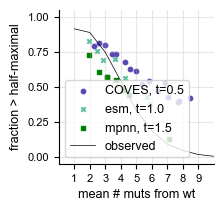

In [41]:
dot_size = 10
alpha_other = 0.5
plt.figure(figsize=(2,2))

t=0.5
df_plot = df_coves_sampling_results_all.loc[df_coves_sampling_results_all.t==t]
plt.scatter(df_plot.average_wt_hamming,
            df_plot.frac_above_thresh, 
            label=f'COVES, t={t}', s=dot_size, c= '#5B49B6')

t=1.0
df_plot = df_result_esm_all.loc[df_result_esm_all.t==t]
plt.scatter(df_plot.average_wt_hamming,
            df_plot.frac_above_thresh, 
            label=f'esm, t={t}', s=dot_size, c='#59C09D', marker='x')
t=1.5   
df_plot = df_mpnn_all.loc[df_mpnn_all.t==t]
plt.scatter(df_plot.average_wt_hamming,
            df_plot.frac_above_thresh, 
            label=f'mpnn, t={t}', s=dot_size, c='green', marker='s')




# plot observed function
plt.plot(list_hamming_obs,list_fraction_alive_obs, c='black', label='observed', lw=0.5)
plt.xticks(list(range(1,10)),size=8)
plt.yticks([0,0.25, 0.5, 0.75, 1],size=8)

plt.xlim([0,10])
plt.ylim([-0.05,1.05])
plt.xlabel('mean # muts from wt', fontsize=9)
plt.ylabel('fraction > half-maximal', fontsize=9)
plt.legend(fontsize=9)
plt.grid(alpha=0.3)
fig.patch.set_visible(False)
#fig.tight_layout()
plt.savefig(dout + 'gfp_sample_eval_div_func_lowT_scan_mutPos.svg', format='svg')
plt.show()

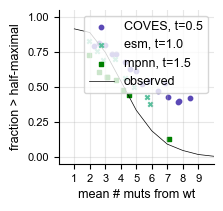

In [40]:
# this gives weirdly a different size
dot_size = 10
alpha_other = 0.5
fig=plt.figure(figsize=(2,2))
# col for coves: '#5B49B6'
# col for mpnn: green
# col for esm: '#59C09D'


# plotting for some representative temperatures and their scans
t=0.5
df_plot = df_coves_sampling_results_all.loc[df_coves_sampling_results_all.t==t]
plt.scatter(df_plot.average_wt_hamming,
            df_plot.frac_above_thresh, 
            label=f'COVES, t={t}', s=dot_size, c= '#5B49B6')

t=1.0
df_plot = df_result_esm_all.loc[df_result_esm_all.t==t]
plt.scatter(df_plot.average_wt_hamming,
            df_plot.frac_above_thresh, 
            label=f'esm, t={t}', s=dot_size, c='#59C09D', marker='x')
t=1.5   
df_plot = df_mpnn_all.loc[df_mpnn_all.t==t]
plt.scatter(df_plot.average_wt_hamming,
            df_plot.frac_above_thresh, 
            label=f'mpnn, t={t}', s=dot_size, c='green', marker='s')

'''
for t in [0.5, 1.0]:
    df_plot = df_coves_sampling_results_all.loc[df_coves_sampling_results_all.t==t]
    plt.scatter(df_plot.average_wt_hamming,
                df_plot.frac_above_thresh, 
                label=f'COVES, t={t}', s=dot_size)
'''

'''
#plot mpnn max pos scan
for t in [0.7, 1.0, 1.5]:
    df_plot = df_mpnn_all.loc[df_mpnn_all.t==t]
    plt.scatter(df_plot.average_wt_hamming,
                df_plot.frac_above_thresh, 
                label=f'mpnn, t={t}', s=dot_size)
'''
'''
#plot esm max pos scan
for t in [0.5, 0.75, 1.0]:
    df_plot = df_result_esm_all.loc[df_result_esm_all.t==t]
    plt.scatter(df_plot.average_wt_hamming,
                df_plot.frac_above_thresh, 
                label=f'esm, t={t}', s=dot_size)
'''
# plot observed function
plt.plot(list_hamming_obs,list_fraction_alive_obs, c='black', label='observed', lw=0.5)
plt.xticks(list(range(1,10)) ,size=8)
plt.yticks([0,0.25, 0.5, 0.75, 1],size=8)

plt.xlim([0,10])
plt.ylim([-0.05,1.05])
plt.xlabel('mean # muts from wt', fontsize=9)
plt.ylabel('fraction > half-maximal', fontsize=9)
plt.legend(loc='upper right',fontsize=9)
plt.grid(alpha=0.3)
fig.patch.set_visible(False)
#fig.tight_layout()

plt.savefig(dout + 'gfp_sample_eval_div_func_lowT_scan_mutPos.svg', format='svg')
plt.show()

# plotting sample eval with max_pos15 and different temperatures

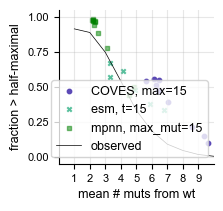

In [37]:
dot_size = 10
alpha_other = 0.5
plt.figure(figsize=(2,2))
df_plot = df_coves_sampling_results_all.loc[df_coves_sampling_results_all.max_mut ==15]
plt.scatter(df_plot.average_wt_hamming,
            df_plot.frac_above_thresh, 
            label='COVES, max=15', s=dot_size, c= '#5B49B6')

df_plot = df_result_esm_all.loc[df_result_esm_all.max_mut==15]
plt.scatter(df_plot.average_wt_hamming,
            df_plot.frac_above_thresh, 
            label=f'esm, t=15', s=dot_size, c='#59C09D', marker='x')

df_plot = df_mpnn_all.loc[df_mpnn_all.max_mut==15]
plt.scatter(df_plot.average_wt_hamming,
            df_plot.frac_above_thresh, 
            label=f'mpnn, max_mut=15', s=dot_size, c='green', marker='s', alpha=alpha_other)
# plot observed function
plt.plot(list_hamming_obs,list_fraction_alive_obs, c='black', label='observed', lw=0.5)
plt.xticks(list(range(1,10)),size=8)
plt.yticks([0,0.25, 0.5, 0.75, 1],size=8)

plt.xlim([0,10])
plt.ylim([-0.05,1.05])
plt.xlabel('mean # muts from wt', fontsize=9)
plt.ylabel('fraction > half-maximal', fontsize=9)
plt.legend(fontsize=9)
plt.grid(alpha=0.3)
fig.patch.set_visible(False)
#fig.tight_layout()
plt.savefig(dout + 'gfp_sample_eval_div_func_maxPos15_t_scan.svg', format='svg')
plt.show()

In [35]:
dout

'./res/out/'

# plotting results with max_pos10 and different temperatures

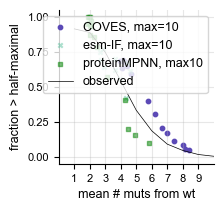

In [38]:

dot_size = 10
alpha_other = 0.5
plt.figure(figsize=(2,2))

plt.scatter(df_coves_sampling_results_all.loc[df_coves_sampling_results_all.max_mut ==10].average_wt_hamming,
            df_coves_sampling_results_all.loc[df_coves_sampling_results_all.max_mut ==10].frac_above_thresh, 
            label='COVES, max=10', s=dot_size, c= '#5B49B6')

df_plot = df_result_esm_all.loc[df_result_esm_all.max_mut ==10]
plt.scatter(df_plot.average_wt_hamming,
            df_plot.frac_above_thresh, 
            label='esm-IF, max=10', s=dot_size, alpha=alpha_other, c='#59C09D', marker='x')

df_plot = df_mpnn_all.loc[(df_mpnn_all.max_mut ==10)]
plt.scatter(df_plot.average_wt_hamming,
            df_plot.frac_above_thresh, 
            label='proteinMPNN, max10', s=dot_size, alpha=alpha_other, c='green', marker='s')

# plot observed function
plt.plot(list_hamming_obs,list_fraction_alive_obs, c='black', label='observed', lw=0.5)
plt.xticks(list(range(1,10)),size=8)
plt.yticks([0,0.25, 0.5, 0.75, 1],size=8)

plt.xlim([0,10])
plt.ylim([-0.05,1.05])
plt.xlabel('mean # muts from wt', fontsize=9)
plt.ylabel('fraction > half-maximal', fontsize=9)
plt.legend(loc='upper right',fontsize=9)
plt.grid(alpha=0.3)
fig.patch.set_visible(False)
#fig.tight_layout()

plt.savefig(dout + 'gfp_sample_eval_div_func_maxPos10_t_scan.svg', format='svg')

plt.show()

# misc

## old reading in proteinMPNN scripts

In [50]:
# reading the temperature scan in
# also read in the n1600 results in!

list_n_pos_mutate = [5,10]


df_gen_result_mpnn = pd.DataFrame(columns=['t', 'max_mut', 'average_wt_hamming', 'frac_above_thresh', 'n_muts_seen', 'n_muts_sampled'])
n_sample = 1600
#for t in [0.0001, 0.1, 0.15, 0.2, 0.25, 0.3, 0.5, 0.7, 1.0] + [2,3,4,5,10,20,40,70,100,1000]:
for t in [0.7, 1.0, 1.5,1.75, 2,2.25, 2.5,3,4,5,10,20,40,70,100]:
    for n_pos_mutate in list_n_pos_mutate:
        t=float(t)
        fin = mpnn_dout_samples + f'gfp_proteinMPNN_t{t}_n_pos_mutated{n_pos_mutate}_n{n_sample}.csv'
        df_gen_seqs = read_sampling_file_mpnn(fin)
        df_gen_seqs['mutkey_wrt_dms'] = df_gen_seqs.gen_seq.apply(lambda s: get_mutkey_from_mutseq(s, wt_gfp_seq_dms))
        df_gen_seqs['mutkey_wrt_pdb'] = df_gen_seqs.gen_seq.apply(lambda s: get_mutkey_from_mutseq(s, wt_gfp_seq))
        # these are only the mutants without the reference mutant changes.
        df_gen_seqs['mutkey'] = df_gen_seqs['mutkey_wrt_dms'].apply(lambda mks:':'.join([m for m in mks.split(':') if m not in list_muts_dms_exclude]))
        # filter sequences for the ones where the individual variants are seen.
        df_gen_seqs['all_seen'] = df_gen_seqs.mutkey.apply(lambda mk: not bool(sum([1 for m in mk.split(':') if m not in muts_seen_dms])))
        df_gen_seqs = df_gen_seqs.loc[df_gen_seqs.all_seen]
        print(f'number of combos for which ind. muts seen {len(df_gen_seqs)} out of {n_sample}, t{t}, n_pos_{n_pos_mutate}')
        #        display(df_gen_seqs)
        #
        # for T where there are no sequences that are seen
        if len(df_gen_seqs) >0:
            X_gen = np.stack(list(df_gen_seqs['oh'].values), axis=0)
            X_gen= np.c_[X_gen,np.ones(X_gen.shape[0])]
            print(X_gen.shape)

            # evaluate sampled sequences
            # filtered for mutations that predictions can be made about

            yhat_non_gen = model.predict(X_gen).flatten()

            frac_above_thresh = sum(yhat_non_gen>threshold)/len(yhat_non_gen)
            ham_dists_wt = [len(mk.split(':')) for mk in df_gen_seqs['mutkey']] # this has to change for the gfp.
            average_wt_hamming = np.mean(ham_dists_wt)

            dic_row_result = {'t':t, 
                              'max_mut':n_pos_mutate, 
                              'average_wt_hamming':average_wt_hamming, 
                              'frac_above_thresh':frac_above_thresh,
                              'n_muts_seen': X_gen.shape[0], 
                              'n_muts_sampled': n_sample}
            df_gen_result_mpnn = df_gen_result_mpnn.append(dic_row_result, ignore_index=True)

        '''
        fig, (ax1,ax2) = plt.subplots(1,2,figsize=(5,2))
        plt.title(f't:{t}, n_mut:{n_pos_mutate}')
        ax1.hist(yhat_non_gen)
        ax1.axvline(threshold)
        ax2.hist(ham_dists_wt)
        plt.show()
        '''

number of combos for which ind. muts seen 242 out of 1600, t0.7, n_pos_5
(242, 4999)


/tmp/ipykernel_27088/835724986.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_mpnn = df_gen_result_mpnn.append(dic_row_result, ignore_index=True)


number of combos for which ind. muts seen 291 out of 1600, t0.7, n_pos_10
(291, 4999)


/tmp/ipykernel_27088/835724986.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_mpnn = df_gen_result_mpnn.append(dic_row_result, ignore_index=True)


number of combos for which ind. muts seen 319 out of 1600, t1.0, n_pos_5
(319, 4999)


/tmp/ipykernel_27088/835724986.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_mpnn = df_gen_result_mpnn.append(dic_row_result, ignore_index=True)


number of combos for which ind. muts seen 254 out of 1600, t1.0, n_pos_10
(254, 4999)


/tmp/ipykernel_27088/835724986.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_mpnn = df_gen_result_mpnn.append(dic_row_result, ignore_index=True)


number of combos for which ind. muts seen 273 out of 1600, t1.5, n_pos_5
(273, 4999)


/tmp/ipykernel_27088/835724986.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_mpnn = df_gen_result_mpnn.append(dic_row_result, ignore_index=True)


number of combos for which ind. muts seen 58 out of 1600, t1.5, n_pos_10
(58, 4999)


/tmp/ipykernel_27088/835724986.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_mpnn = df_gen_result_mpnn.append(dic_row_result, ignore_index=True)


number of combos for which ind. muts seen 198 out of 1600, t1.75, n_pos_5
(198, 4999)


/tmp/ipykernel_27088/835724986.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_mpnn = df_gen_result_mpnn.append(dic_row_result, ignore_index=True)


number of combos for which ind. muts seen 32 out of 1600, t1.75, n_pos_10
(32, 4999)


/tmp/ipykernel_27088/835724986.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_mpnn = df_gen_result_mpnn.append(dic_row_result, ignore_index=True)


number of combos for which ind. muts seen 127 out of 1600, t2.0, n_pos_5
(127, 4999)


/tmp/ipykernel_27088/835724986.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_mpnn = df_gen_result_mpnn.append(dic_row_result, ignore_index=True)


number of combos for which ind. muts seen 15 out of 1600, t2.0, n_pos_10
(15, 4999)


/tmp/ipykernel_27088/835724986.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_mpnn = df_gen_result_mpnn.append(dic_row_result, ignore_index=True)


number of combos for which ind. muts seen 122 out of 1600, t2.25, n_pos_5
(122, 4999)


/tmp/ipykernel_27088/835724986.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_mpnn = df_gen_result_mpnn.append(dic_row_result, ignore_index=True)


number of combos for which ind. muts seen 19 out of 1600, t2.25, n_pos_10
(19, 4999)


/tmp/ipykernel_27088/835724986.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_mpnn = df_gen_result_mpnn.append(dic_row_result, ignore_index=True)


number of combos for which ind. muts seen 125 out of 1600, t2.5, n_pos_5
(125, 4999)


/tmp/ipykernel_27088/835724986.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_mpnn = df_gen_result_mpnn.append(dic_row_result, ignore_index=True)


number of combos for which ind. muts seen 10 out of 1600, t2.5, n_pos_10
(10, 4999)


/tmp/ipykernel_27088/835724986.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_mpnn = df_gen_result_mpnn.append(dic_row_result, ignore_index=True)


number of combos for which ind. muts seen 63 out of 1600, t3.0, n_pos_5
(63, 4999)


/tmp/ipykernel_27088/835724986.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_mpnn = df_gen_result_mpnn.append(dic_row_result, ignore_index=True)


number of combos for which ind. muts seen 4 out of 1600, t3.0, n_pos_10
(4, 4999)


/tmp/ipykernel_27088/835724986.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_mpnn = df_gen_result_mpnn.append(dic_row_result, ignore_index=True)


number of combos for which ind. muts seen 61 out of 1600, t4.0, n_pos_5
(61, 4999)


/tmp/ipykernel_27088/835724986.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_mpnn = df_gen_result_mpnn.append(dic_row_result, ignore_index=True)


number of combos for which ind. muts seen 0 out of 1600, t4.0, n_pos_10
number of combos for which ind. muts seen 42 out of 1600, t5.0, n_pos_5
(42, 4999)


/tmp/ipykernel_27088/835724986.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_mpnn = df_gen_result_mpnn.append(dic_row_result, ignore_index=True)


number of combos for which ind. muts seen 1 out of 1600, t5.0, n_pos_10
(1, 4999)


/tmp/ipykernel_27088/835724986.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_mpnn = df_gen_result_mpnn.append(dic_row_result, ignore_index=True)


number of combos for which ind. muts seen 33 out of 1600, t10.0, n_pos_5
(33, 4999)


/tmp/ipykernel_27088/835724986.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_mpnn = df_gen_result_mpnn.append(dic_row_result, ignore_index=True)


number of combos for which ind. muts seen 0 out of 1600, t10.0, n_pos_10
number of combos for which ind. muts seen 23 out of 1600, t20.0, n_pos_5
(23, 4999)


/tmp/ipykernel_27088/835724986.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_mpnn = df_gen_result_mpnn.append(dic_row_result, ignore_index=True)


number of combos for which ind. muts seen 0 out of 1600, t20.0, n_pos_10
number of combos for which ind. muts seen 25 out of 1600, t40.0, n_pos_5
(25, 4999)


/tmp/ipykernel_27088/835724986.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_mpnn = df_gen_result_mpnn.append(dic_row_result, ignore_index=True)


number of combos for which ind. muts seen 0 out of 1600, t40.0, n_pos_10
number of combos for which ind. muts seen 29 out of 1600, t70.0, n_pos_5
(29, 4999)


/tmp/ipykernel_27088/835724986.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_mpnn = df_gen_result_mpnn.append(dic_row_result, ignore_index=True)


number of combos for which ind. muts seen 0 out of 1600, t70.0, n_pos_10
number of combos for which ind. muts seen 27 out of 1600, t100.0, n_pos_5
(27, 4999)


/tmp/ipykernel_27088/835724986.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_mpnn = df_gen_result_mpnn.append(dic_row_result, ignore_index=True)


number of combos for which ind. muts seen 0 out of 1600, t100.0, n_pos_10


In [92]:
# reading the max_pos scan across a couple of low temperatures
# also read in the n1600 results in

list_n_pos_mutate = list(range(5,21,2))
t_range = [0.7, 1, 1.5]


df_gen_result_mpnn_max_pos_scan = pd.DataFrame(columns=['t', 'max_mut', 'average_wt_hamming', 'frac_above_thresh', 'n_muts_seen', 'n_muts_sampled'])
n_sample = 1600
for t in t_range:
    for n_pos_mutate in list_n_pos_mutate:
        t=float(t)

        f_name = f'gfp_proteinMPNN_t{t}_n_pos_mutated{n_pos_mutate}_n{n_sample}.csv'
        if f_name in listdir(mpnn_dout_samples):
            fin = mpnn_dout_samples + f_name
            df_gen_seqs = read_sampling_file_mpnn(fin)
            df_gen_seqs['mutkey_wrt_dms'] = df_gen_seqs.gen_seq.apply(lambda s: get_mutkey_from_mutseq(s, wt_gfp_seq_dms))
            df_gen_seqs['mutkey_wrt_pdb'] = df_gen_seqs.gen_seq.apply(lambda s: get_mutkey_from_mutseq(s, wt_gfp_seq))
            # these are only the mutants without the reference mutant changes.
            df_gen_seqs['mutkey'] = df_gen_seqs['mutkey_wrt_dms'].apply(lambda mks:':'.join([m for m in mks.split(':') if m not in list_muts_dms_exclude]))
            # filter sequences for the ones where the individual variants are seen.
            df_gen_seqs['all_seen'] = df_gen_seqs.mutkey.apply(lambda mk: not bool(sum([1 for m in mk.split(':') if m not in muts_seen_dms])))
            df_gen_seqs = df_gen_seqs.loc[df_gen_seqs.all_seen]
            print(f'number of combos for which ind. muts seen {len(df_gen_seqs)} out of {n_sample}, t{t}, n_pos_{n_pos_mutate}')
            #        display(df_gen_seqs)
            #
            # for T where there are no sequences that are seen

            # need to limit to the variants that have <10 mutations as seen in experiment (exp range up to 15, but )
            df_gen_seqs['hamming'] = df_gen_seqs['gen_seq'].apply(lambda s: hamming(wt_gfp_seq_dms,s))
            df_gen_seqs = df_gen_seqs.loc[df_gen_seqs.hamming <15]

            if len(df_gen_seqs) >0:
                X_gen = np.stack(list(df_gen_seqs['oh'].values), axis=0)
                X_gen= np.c_[X_gen,np.ones(X_gen.shape[0])]
                print(X_gen.shape)

                # evaluate sampled sequences
                # filtered for mutations that predictions can be made about

                yhat_non_gen = model.predict(X_gen).flatten()

                frac_above_thresh = sum(yhat_non_gen>threshold)/len(yhat_non_gen)
                ham_dists_wt = [len(mk.split(':')) for mk in df_gen_seqs['mutkey']] # this has to change for the gfp.
                average_wt_hamming = np.mean(ham_dists_wt)

                dic_row_result = {'t':t, 
                                  'max_mut':n_pos_mutate, 
                                  'average_wt_hamming':average_wt_hamming, 
                                  'frac_above_thresh':frac_above_thresh,
                                  'n_muts_seen': X_gen.shape[0], 
                                  'n_muts_sampled': n_sample}
                df_gen_result_mpnn_max_pos_scan = df_gen_result_mpnn_max_pos_scan.append(dic_row_result, ignore_index=True)


number of combos for which ind. muts seen 249 out of 1600, t0.7, n_pos_5
(249, 4999)


/tmp/ipykernel_27088/1144630869.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_mpnn_max_pos_scan = df_gen_result_mpnn_max_pos_scan.append(dic_row_result, ignore_index=True)


number of combos for which ind. muts seen 258 out of 1600, t0.7, n_pos_7
(258, 4999)


/tmp/ipykernel_27088/1144630869.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_mpnn_max_pos_scan = df_gen_result_mpnn_max_pos_scan.append(dic_row_result, ignore_index=True)


number of combos for which ind. muts seen 300 out of 1600, t0.7, n_pos_9
(300, 4999)


/tmp/ipykernel_27088/1144630869.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_mpnn_max_pos_scan = df_gen_result_mpnn_max_pos_scan.append(dic_row_result, ignore_index=True)


number of combos for which ind. muts seen 302 out of 1600, t0.7, n_pos_11
(302, 4999)


/tmp/ipykernel_27088/1144630869.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_mpnn_max_pos_scan = df_gen_result_mpnn_max_pos_scan.append(dic_row_result, ignore_index=True)


number of combos for which ind. muts seen 279 out of 1600, t0.7, n_pos_13
(279, 4999)


/tmp/ipykernel_27088/1144630869.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_mpnn_max_pos_scan = df_gen_result_mpnn_max_pos_scan.append(dic_row_result, ignore_index=True)


number of combos for which ind. muts seen 242 out of 1600, t0.7, n_pos_15
(242, 4999)


/tmp/ipykernel_27088/1144630869.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_mpnn_max_pos_scan = df_gen_result_mpnn_max_pos_scan.append(dic_row_result, ignore_index=True)


number of combos for which ind. muts seen 155 out of 1600, t0.7, n_pos_17
(155, 4999)


/tmp/ipykernel_27088/1144630869.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_mpnn_max_pos_scan = df_gen_result_mpnn_max_pos_scan.append(dic_row_result, ignore_index=True)


number of combos for which ind. muts seen 206 out of 1600, t0.7, n_pos_19
(206, 4999)


/tmp/ipykernel_27088/1144630869.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_mpnn_max_pos_scan = df_gen_result_mpnn_max_pos_scan.append(dic_row_result, ignore_index=True)


number of combos for which ind. muts seen 323 out of 1600, t1.0, n_pos_5
(323, 4999)


/tmp/ipykernel_27088/1144630869.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_mpnn_max_pos_scan = df_gen_result_mpnn_max_pos_scan.append(dic_row_result, ignore_index=True)


number of combos for which ind. muts seen 321 out of 1600, t1.0, n_pos_7
(321, 4999)


/tmp/ipykernel_27088/1144630869.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_mpnn_max_pos_scan = df_gen_result_mpnn_max_pos_scan.append(dic_row_result, ignore_index=True)


number of combos for which ind. muts seen 261 out of 1600, t1.0, n_pos_9
(261, 4999)


/tmp/ipykernel_27088/1144630869.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_mpnn_max_pos_scan = df_gen_result_mpnn_max_pos_scan.append(dic_row_result, ignore_index=True)


number of combos for which ind. muts seen 234 out of 1600, t1.0, n_pos_11
(234, 4999)


/tmp/ipykernel_27088/1144630869.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_mpnn_max_pos_scan = df_gen_result_mpnn_max_pos_scan.append(dic_row_result, ignore_index=True)


number of combos for which ind. muts seen 187 out of 1600, t1.0, n_pos_13
(187, 4999)


/tmp/ipykernel_27088/1144630869.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_mpnn_max_pos_scan = df_gen_result_mpnn_max_pos_scan.append(dic_row_result, ignore_index=True)


number of combos for which ind. muts seen 123 out of 1600, t1.0, n_pos_15
(123, 4999)


/tmp/ipykernel_27088/1144630869.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_mpnn_max_pos_scan = df_gen_result_mpnn_max_pos_scan.append(dic_row_result, ignore_index=True)


number of combos for which ind. muts seen 63 out of 1600, t1.0, n_pos_17
(63, 4999)


/tmp/ipykernel_27088/1144630869.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_mpnn_max_pos_scan = df_gen_result_mpnn_max_pos_scan.append(dic_row_result, ignore_index=True)


number of combos for which ind. muts seen 71 out of 1600, t1.0, n_pos_19
(71, 4999)


/tmp/ipykernel_27088/1144630869.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_mpnn_max_pos_scan = df_gen_result_mpnn_max_pos_scan.append(dic_row_result, ignore_index=True)


number of combos for which ind. muts seen 243 out of 1600, t1.5, n_pos_5
(243, 4999)


/tmp/ipykernel_27088/1144630869.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_mpnn_max_pos_scan = df_gen_result_mpnn_max_pos_scan.append(dic_row_result, ignore_index=True)


number of combos for which ind. muts seen 143 out of 1600, t1.5, n_pos_7
(143, 4999)


/tmp/ipykernel_27088/1144630869.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_mpnn_max_pos_scan = df_gen_result_mpnn_max_pos_scan.append(dic_row_result, ignore_index=True)


number of combos for which ind. muts seen 88 out of 1600, t1.5, n_pos_9
(88, 4999)


/tmp/ipykernel_27088/1144630869.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_mpnn_max_pos_scan = df_gen_result_mpnn_max_pos_scan.append(dic_row_result, ignore_index=True)


number of combos for which ind. muts seen 53 out of 1600, t1.5, n_pos_11
(53, 4999)


/tmp/ipykernel_27088/1144630869.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_mpnn_max_pos_scan = df_gen_result_mpnn_max_pos_scan.append(dic_row_result, ignore_index=True)


number of combos for which ind. muts seen 19 out of 1600, t1.5, n_pos_13
(19, 4999)


/tmp/ipykernel_27088/1144630869.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_mpnn_max_pos_scan = df_gen_result_mpnn_max_pos_scan.append(dic_row_result, ignore_index=True)


number of combos for which ind. muts seen 16 out of 1600, t1.5, n_pos_15
(16, 4999)


/tmp/ipykernel_27088/1144630869.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_mpnn_max_pos_scan = df_gen_result_mpnn_max_pos_scan.append(dic_row_result, ignore_index=True)


number of combos for which ind. muts seen 7 out of 1600, t1.5, n_pos_17
(7, 4999)


/tmp/ipykernel_27088/1144630869.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_mpnn_max_pos_scan = df_gen_result_mpnn_max_pos_scan.append(dic_row_result, ignore_index=True)


number of combos for which ind. muts seen 1 out of 1600, t1.5, n_pos_19
(1, 4999)


/tmp/ipykernel_27088/1144630869.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_mpnn_max_pos_scan = df_gen_result_mpnn_max_pos_scan.append(dic_row_result, ignore_index=True)


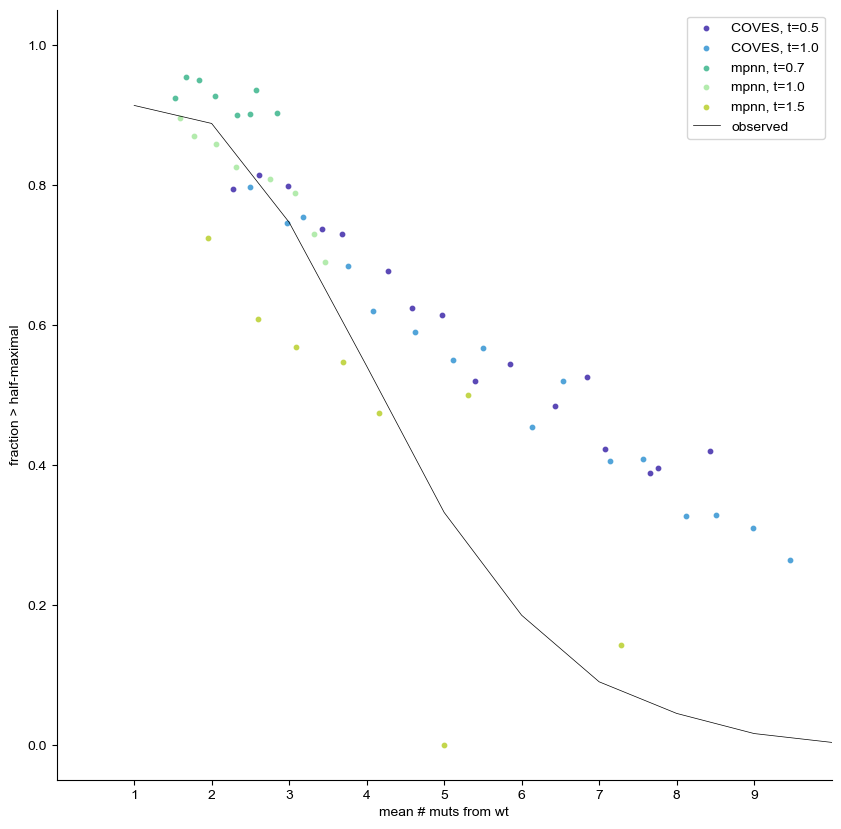

In [93]:

dot_size = 10
alpha_other = 0.5
plt.figure(figsize=(10,10))

for t in [0.5, 1.0]:
    df_plot = df_coves_sampling_results_all.loc[df_coves_sampling_results_all.t==t]
    plt.scatter(df_plot.average_wt_hamming,
                df_plot.frac_above_thresh, 
                label=f'COVES, t={t}', s=dot_size)
#plot mpnn max pos scan
for t in [0.7, 1.0, 1.5]:
    df_plot = df_gen_result_mpnn_max_pos_scan.loc[df_gen_result_mpnn_max_pos_scan.t==t]
    plt.scatter(df_plot.average_wt_hamming,
                df_plot.frac_above_thresh, 
                label=f'mpnn, t={t}', s=dot_size)

# plot observed function
plt.plot(list_hamming_obs,list_fraction_alive_obs, c='black', label='observed', lw=0.5)
plt.xticks(list(range(1,10)))
plt.xlim([0,10])
plt.ylim([-0.05,1.05])
plt.xlabel('mean # muts from wt')
plt.ylabel('fraction > half-maximal')
plt.legend()
plt.show()

## old esm reading scripts

In [ ]:
'''
n_sample = 400
df_gen_result_esm = pd.DataFrame(columns=['t', 'max_mut', 'average_wt_hamming', 'frac_above_thresh','n_muts_seen', 'n_muts_sampled'])
for t in [1e-3,1e-2,1e-1,0.5,0.75,1, 1.25, 1.5, 1.75, 2, 3, 4, 5, 10] + [20,30,40,70,80,100,200,1000]:
    for n_pos_mutate in list_n_pos_mutate:
        t=float(t)
        fin = esm_dout_samples + f'esm_t{t}_n{n_sample}_n_pos_mutate{n_pos_mutate}gen_seq_gfp.csv'
        df_gen_seqs = read_sampling_file_esm(fin)
        df_gen_seqs['mutkey_wrt_dms'] = df_gen_seqs.gen_seq.apply(lambda s: get_mutkey_from_mutseq(s, wt_gfp_seq_dms))
        df_gen_seqs['mutkey_wrt_pdb'] = df_gen_seqs.gen_seq.apply(lambda s: get_mutkey_from_mutseq(s, wt_gfp_seq))
        # these are only the mutants without the reference mutant changes.
        df_gen_seqs['mutkey'] = df_gen_seqs['mutkey_wrt_dms'].apply(lambda mks:':'.join([m for m in mks.split(':') if m not in list_muts_dms_exclude]))
        
        # filter sequences for the ones where the individual variants are seen.
        df_gen_seqs['all_seen'] = df_gen_seqs.mutkey.apply(lambda mk: not bool(sum([1 for m in mk.split(':') if m not in muts_seen_dms])))
        df_gen_seqs = df_gen_seqs.loc[df_gen_seqs.all_seen]
        print(f'number of combos for which ind. muts seen {len(df_gen_seqs)} out of {n_sample} for t{t}, npos_mutate{n_pos_mutate}')
        #        display(df_gen_seqs)
        
        #
        X_gen = np.stack(list(df_gen_seqs['oh'].values), axis=0)
        X_gen= np.c_[X_gen,np.ones(X_gen.shape[0])]
        print(X_gen.shape)

        # evaluate sampled sequences
        # filtered for mutations that predictions can be made about

        yhat_non_gen = model.predict(X_gen).flatten()

        frac_above_thresh = sum(yhat_non_gen>threshold)/len(yhat_non_gen)
        ham_dists_wt = [len(mk.split(':')) for mk in df_gen_seqs['mutkey']] # this has to change for the gfp.
        average_wt_hamming = np.mean(ham_dists_wt)

        dic_row_result = {'t':t, 
                          'max_mut':n_pos_mutate, 
                          'average_wt_hamming':average_wt_hamming, 
                          'frac_above_thresh':frac_above_thresh,
                         'n_muts_seen': X_gen.shape[0], 
                          'n_muts_sampled': n_sample}
        df_gen_result_esm = df_gen_result_esm.append(dic_row_result, ignore_index=True)

        # plotting these results
'''
        '''
        fig, (ax1,ax2) = plt.subplots(1,2,figsize=(5,2))
        plt.title(f't:{t}, n_mut:{n_pos_mutate}')
        ax1.hist(yhat_non_gen)
        ax1.axvline(threshold)
        ax2.hist(ham_dists_wt)
        plt.show()
        '''

## old coves reading in scripts

In [35]:
'''
# COVES sampled sequences with pre-filtered on the mutations that are allowed in experiment


## these sampled sequences are filtered for only the singles that are found in the DMS experiment at the sampling stage, enables getting higher mutation distance away.

#assayed_temps = [10**t_exp for t_exp in range(-100,0,10)] # these are all 103 muts away

# for various sampling temps with 4 positions mutated

n_sample = 300 # n_sample=100

df_gen_result = pd.DataFrame(columns=['t', 'max_mut', 'average_wt_hamming', 'frac_above_thresh','n_muts_seen', 'n_muts_sampled'])
for t in [ 0.1, 0.3,0.4, 0.5, 0.6, 0.7,1,2, 3, 4, 5, 8, 10, 20]:
    for n_pos_mutate in [5,10]:
        fin = sample_din + f'gvp_100_m_RES_1646945484_3030427_8_230519_gfp_samples_t{t}_n{n_sample}_downselect{n_pos_mutate}_230528.csv'
        df_gen_seqs = read_sampling_file_res(fin)

        #
        X_gen = np.stack(list(df_gen_seqs['oh'].values), axis=0)
        X_gen= np.c_[X_gen,np.ones(X_gen.shape[0])]
        print(X_gen.shape)

        # evaluate sampled sequences
        # filtered for mutations that predictions can be made about

        yhat_non_gen = model.predict(X_gen).flatten()

        frac_above_thresh = sum(yhat_non_gen>threshold)/len(yhat_non_gen)
        ham_dists_wt = [hamming(wt_gfp_seq_dms,mutseq) for mutseq in df_gen_seqs['gen_seq']]
        average_wt_hamming = np.mean(ham_dists_wt)

     
        dic_row_result = {'t':t, 
                          'max_mut':n_pos_mutate, 
                          'average_wt_hamming':average_wt_hamming, 
                          'frac_above_thresh':frac_above_thresh,
                          'n_muts_seen': X_gen.shape[0], 
                          'n_muts_sampled': n_sample}
        df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)

'''
        '''

        fig, (ax1,ax2) = plt.subplots(1,2,figsize=(5,2))
        plt.title(f't:{t}, n_mut:{n_pos_mutate}')
        ax1.hist(yhat_non_gen)
        ax1.axvline(threshold)
        ax2.hist(ham_dists_wt)
        plt.show()
        '''

282
282
(264, 4999)
292
292


/tmp/ipykernel_27088/4005064097.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


(291, 4999)
285
285


/tmp/ipykernel_27088/4005064097.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


(256, 4999)
277
277


/tmp/ipykernel_27088/4005064097.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


(276, 4999)
284
284


/tmp/ipykernel_27088/4005064097.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


(263, 4999)
290
290


/tmp/ipykernel_27088/4005064097.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


(287, 4999)
283
283


/tmp/ipykernel_27088/4005064097.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


(269, 4999)
286
286


/tmp/ipykernel_27088/4005064097.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


(286, 4999)
281
281


/tmp/ipykernel_27088/4005064097.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


(265, 4999)
285
285


/tmp/ipykernel_27088/4005064097.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


(284, 4999)
287
287


/tmp/ipykernel_27088/4005064097.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


(271, 4999)
288
288


/tmp/ipykernel_27088/4005064097.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


(287, 4999)
280
280


/tmp/ipykernel_27088/4005064097.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


(273, 4999)
283
283


/tmp/ipykernel_27088/4005064097.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


(283, 4999)
282
282


/tmp/ipykernel_27088/4005064097.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


(281, 4999)
286
286


/tmp/ipykernel_27088/4005064097.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


(286, 4999)
276
276


/tmp/ipykernel_27088/4005064097.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


(276, 4999)
283
283


/tmp/ipykernel_27088/4005064097.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


(283, 4999)
281
281


/tmp/ipykernel_27088/4005064097.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


(279, 4999)
284
284


/tmp/ipykernel_27088/4005064097.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


(284, 4999)
291
291


/tmp/ipykernel_27088/4005064097.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


(291, 4999)
288
288


/tmp/ipykernel_27088/4005064097.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


(288, 4999)
288
288


/tmp/ipykernel_27088/4005064097.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


(288, 4999)
288
288


/tmp/ipykernel_27088/4005064097.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


(288, 4999)
287
287


/tmp/ipykernel_27088/4005064097.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


(287, 4999)
282
282


/tmp/ipykernel_27088/4005064097.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


(282, 4999)
287
287


/tmp/ipykernel_27088/4005064097.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


(287, 4999)
288
288


/tmp/ipykernel_27088/4005064097.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


(288, 4999)


/tmp/ipykernel_27088/4005064097.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


In [56]:
'''
# 15 position allowed to mutate
# considering only mutations that are seen within expt. 
# the suffix in the sampling files _all_gvp_pred is wrong

##### to change the name of these files
n_sample = 300
n_pos_mutate = 15
for t in [ 0.1, 0.3,0.4, 0.5, 0.6, 0.7,1,2, 3, 4, 5, 8, 10, 20]:
    my_cmd = f'mv {sample_din}gvp_100_m_RES_1646945484_3030427_8_230519_gfp_samples_t{t}_n{n_sample}_downselect{n_pos_mutate}_230528_all_gvp_pred.csv {sample_din}gvp_100_m_RES_1646945484_3030427_8_230519_gfp_samples_t{t}_n{n_sample}_downselect{n_pos_mutate}_230528.csv'
    os.system(my_cmd)

n_sample = 300 # n_sample=100
n_pos_mutate = 15
df_gen_result_coves_p15 = pd.DataFrame(columns=['t', 'max_mut', 'average_wt_hamming', 'frac_above_thresh', 'n_muts_seen', 'n_muts_sampled'])
for t in [ 0.1, 0.3,0.4, 0.5, 0.6, 0.7,1,2, 3, 4, 5, 8, 10, 20]:
    # make a list of sequences 
    #mutkeys = read_sampled_mut_key(
    #    sample_din + f'gvp_100_m_RES_1646945484_3030427_8_230519_gfp_samples_t{t}_n100.csv')

    fin = sample_din + f'gvp_100_m_RES_1646945484_3030427_8_230519_gfp_samples_t{t}_n{n_sample}_downselect{n_pos_mutate}_230528_all_gvp_pred.csv'
    df_gen_seqs = read_sampling_file_res(fin)
    df_gen_seqs['all_seen'] = df_gen_seqs.mutkey.apply(lambda mk: not bool(sum([1 for m in mk.split(':') if m not in muts_seen_dms])))
    df_gen_seqs = df_gen_seqs.loc[df_gen_seqs.all_seen]

    if len(df_gen_seqs) >0:
        #
        X_gen = np.stack(list(df_gen_seqs['oh'].values), axis=0)
        X_gen= np.c_[X_gen,np.ones(X_gen.shape[0])]
        print(X_gen.shape)

        # evaluate sampled sequences
        # filtered for mutations that predictions can be made about

        yhat_non_gen = model.predict(X_gen).flatten()

        frac_above_thresh = sum(yhat_non_gen>threshold)/len(yhat_non_gen)
        ham_dists_wt = [hamming(wt_gfp_seq_dms,mutseq) for mutseq in df_gen_seqs['gen_seq']]
        average_wt_hamming = np.mean(ham_dists_wt)

        dic_row_result = {'t':t, 
                          'max_mut':n_pos_mutate, 
                          'average_wt_hamming':average_wt_hamming, 
                          'frac_above_thresh':frac_above_thresh, 
                         'n_muts_seen': len(df_gen_seqs),
                         'n_muts_sampled': n_sample}
        df_gen_result_coves_p15 = df_gen_result_coves_p15.append(dic_row_result, ignore_index=True)
'''

280
280
(280, 4999)
289
289


/tmp/ipykernel_27088/1027932684.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_coves_p15 = df_gen_result_coves_p15.append(dic_row_result, ignore_index=True)


(288, 4999)
281
281


/tmp/ipykernel_27088/1027932684.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_coves_p15 = df_gen_result_coves_p15.append(dic_row_result, ignore_index=True)


(281, 4999)
280
280


/tmp/ipykernel_27088/1027932684.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_coves_p15 = df_gen_result_coves_p15.append(dic_row_result, ignore_index=True)


(280, 4999)
277
277


/tmp/ipykernel_27088/1027932684.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_coves_p15 = df_gen_result_coves_p15.append(dic_row_result, ignore_index=True)


(277, 4999)
282
282


/tmp/ipykernel_27088/1027932684.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_coves_p15 = df_gen_result_coves_p15.append(dic_row_result, ignore_index=True)


(282, 4999)
280
280


/tmp/ipykernel_27088/1027932684.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_coves_p15 = df_gen_result_coves_p15.append(dic_row_result, ignore_index=True)


(280, 4999)
282
282


/tmp/ipykernel_27088/1027932684.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_coves_p15 = df_gen_result_coves_p15.append(dic_row_result, ignore_index=True)


(282, 4999)
283
283


/tmp/ipykernel_27088/1027932684.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_coves_p15 = df_gen_result_coves_p15.append(dic_row_result, ignore_index=True)


(283, 4999)
284
284


/tmp/ipykernel_27088/1027932684.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_coves_p15 = df_gen_result_coves_p15.append(dic_row_result, ignore_index=True)


(284, 4999)
285
285


/tmp/ipykernel_27088/1027932684.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_coves_p15 = df_gen_result_coves_p15.append(dic_row_result, ignore_index=True)


(285, 4999)
278
278


/tmp/ipykernel_27088/1027932684.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_coves_p15 = df_gen_result_coves_p15.append(dic_row_result, ignore_index=True)


(278, 4999)
285
285


/tmp/ipykernel_27088/1027932684.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_coves_p15 = df_gen_result_coves_p15.append(dic_row_result, ignore_index=True)


(285, 4999)
278
278


/tmp/ipykernel_27088/1027932684.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_coves_p15 = df_gen_result_coves_p15.append(dic_row_result, ignore_index=True)


(278, 4999)


/tmp/ipykernel_27088/1027932684.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_coves_p15 = df_gen_result_coves_p15.append(dic_row_result, ignore_index=True)


In [76]:
'''
# range of positions allowed to mutate and a few low temperatures

n_sample = 300 # n_sample=100
#n_pos_mutate = 15

df_gen_result_coves_p_range = pd.DataFrame(columns=['t', 'max_mut', 'average_wt_hamming', 'frac_above_thresh', 'n_muts_seen', 'n_muts_sampled'])

#n_pos_mutate_range = [5,6,7,8,9,10,11,12,13,14,15]
#t_range = [0.5, 1,2,2.5,3]

n_pos_mutate_range = [5,6,7,8,9,10,11,12,13,14,15, 16, 17, 18, 19, 20]
t_range = [0.5, 1]
for t in t_range:
    for n_pos_mutate in n_pos_mutate_range:
        # make a list of sequences 
        #mutkeys = read_sampled_mut_key(
        #    sample_din + f'gvp_100_m_RES_1646945484_3030427_8_230519_gfp_samples_t{t}_n100.csv')

        fin = sample_din + f'gvp_100_m_RES_1646945484_3030427_8_230519_gfp_samples_t{t}_n{n_sample}_downselect{n_pos_mutate}_230528.csv'
        df_gen_seqs = read_sampling_file_res(fin)
        df_gen_seqs['all_seen'] = df_gen_seqs.mutkey.apply(lambda mk: not bool(sum([1 for m in mk.split(':') if m not in muts_seen_dms])))
        
        # need to limit to the variants that have <10 mutations as seen in experiment (exp range up to 15, but )
        df_gen_seqs['hamming'] = df_gen_seqs['gen_seq'].apply(lambda s: hamming(wt_gfp_seq_dms,s))
        df_gen_seqs = df_gen_seqs.loc[df_gen_seqs.hamming <15]
        
        df_gen_seqs = df_gen_seqs.loc[df_gen_seqs.all_seen]

        if len(df_gen_seqs) >0:
            #
            X_gen = np.stack(list(df_gen_seqs['oh'].values), axis=0)
            X_gen= np.c_[X_gen,np.ones(X_gen.shape[0])]
            print(X_gen.shape)

            # evaluate sampled sequences
            # filtered for mutations that predictions can be made about

            yhat_non_gen = model.predict(X_gen).flatten()

            frac_above_thresh = sum(yhat_non_gen>threshold)/len(yhat_non_gen)
            ham_dists_wt = [hamming(wt_gfp_seq_dms,mutseq) for mutseq in df_gen_seqs['gen_seq']]
            average_wt_hamming = np.mean(ham_dists_wt)

            dic_row_result = {'t':t, 
                              'max_mut':n_pos_mutate, 
                              'average_wt_hamming':average_wt_hamming, 
                              'frac_above_thresh':frac_above_thresh, 
                             'n_muts_seen': len(df_gen_seqs),
                             'n_muts_sampled': n_sample}
            df_gen_result_coves_p_range = df_gen_result_coves_p_range.append(dic_row_result, ignore_index=True)
'''

284
284
(267, 4999)
284
284


/tmp/ipykernel_27088/4140271855.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_coves_p_range = df_gen_result_coves_p_range.append(dic_row_result, ignore_index=True)


(273, 4999)
285
285


/tmp/ipykernel_27088/4140271855.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_coves_p_range = df_gen_result_coves_p_range.append(dic_row_result, ignore_index=True)


(278, 4999)
280
280


/tmp/ipykernel_27088/4140271855.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_coves_p_range = df_gen_result_coves_p_range.append(dic_row_result, ignore_index=True)


(274, 4999)
282
282


/tmp/ipykernel_27088/4140271855.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_coves_p_range = df_gen_result_coves_p_range.append(dic_row_result, ignore_index=True)


(278, 4999)
285
285


/tmp/ipykernel_27088/4140271855.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_coves_p_range = df_gen_result_coves_p_range.append(dic_row_result, ignore_index=True)


(284, 4999)
286
286


/tmp/ipykernel_27088/4140271855.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_coves_p_range = df_gen_result_coves_p_range.append(dic_row_result, ignore_index=True)


(284, 4999)
283
283


/tmp/ipykernel_27088/4140271855.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_coves_p_range = df_gen_result_coves_p_range.append(dic_row_result, ignore_index=True)


(282, 4999)
271
271


/tmp/ipykernel_27088/4140271855.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_coves_p_range = df_gen_result_coves_p_range.append(dic_row_result, ignore_index=True)


(271, 4999)
283
283


/tmp/ipykernel_27088/4140271855.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_coves_p_range = df_gen_result_coves_p_range.append(dic_row_result, ignore_index=True)


(283, 4999)
283
283


/tmp/ipykernel_27088/4140271855.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_coves_p_range = df_gen_result_coves_p_range.append(dic_row_result, ignore_index=True)


(283, 4999)
282
282


/tmp/ipykernel_27088/4140271855.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_coves_p_range = df_gen_result_coves_p_range.append(dic_row_result, ignore_index=True)


(282, 4999)
286
286


/tmp/ipykernel_27088/4140271855.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_coves_p_range = df_gen_result_coves_p_range.append(dic_row_result, ignore_index=True)


(286, 4999)
283
283


/tmp/ipykernel_27088/4140271855.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_coves_p_range = df_gen_result_coves_p_range.append(dic_row_result, ignore_index=True)


(283, 4999)
288
288


/tmp/ipykernel_27088/4140271855.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_coves_p_range = df_gen_result_coves_p_range.append(dic_row_result, ignore_index=True)


(288, 4999)
284
284


/tmp/ipykernel_27088/4140271855.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_coves_p_range = df_gen_result_coves_p_range.append(dic_row_result, ignore_index=True)


(284, 4999)
287
287


/tmp/ipykernel_27088/4140271855.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_coves_p_range = df_gen_result_coves_p_range.append(dic_row_result, ignore_index=True)


(276, 4999)
287
287


/tmp/ipykernel_27088/4140271855.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_coves_p_range = df_gen_result_coves_p_range.append(dic_row_result, ignore_index=True)


(279, 4999)
283
283


/tmp/ipykernel_27088/4140271855.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_coves_p_range = df_gen_result_coves_p_range.append(dic_row_result, ignore_index=True)


(280, 4999)
286
286


/tmp/ipykernel_27088/4140271855.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_coves_p_range = df_gen_result_coves_p_range.append(dic_row_result, ignore_index=True)


(282, 4999)
288
288


/tmp/ipykernel_27088/4140271855.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_coves_p_range = df_gen_result_coves_p_range.append(dic_row_result, ignore_index=True)


(287, 4999)
288
288


/tmp/ipykernel_27088/4140271855.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_coves_p_range = df_gen_result_coves_p_range.append(dic_row_result, ignore_index=True)


(288, 4999)
287
287


/tmp/ipykernel_27088/4140271855.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_coves_p_range = df_gen_result_coves_p_range.append(dic_row_result, ignore_index=True)


(286, 4999)
282
282


/tmp/ipykernel_27088/4140271855.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_coves_p_range = df_gen_result_coves_p_range.append(dic_row_result, ignore_index=True)


(282, 4999)
289
289


/tmp/ipykernel_27088/4140271855.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_coves_p_range = df_gen_result_coves_p_range.append(dic_row_result, ignore_index=True)


(289, 4999)
278
278


/tmp/ipykernel_27088/4140271855.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_coves_p_range = df_gen_result_coves_p_range.append(dic_row_result, ignore_index=True)


(277, 4999)
286
286


/tmp/ipykernel_27088/4140271855.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_coves_p_range = df_gen_result_coves_p_range.append(dic_row_result, ignore_index=True)


(286, 4999)
284
284


/tmp/ipykernel_27088/4140271855.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_coves_p_range = df_gen_result_coves_p_range.append(dic_row_result, ignore_index=True)


(284, 4999)
285
285


/tmp/ipykernel_27088/4140271855.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_coves_p_range = df_gen_result_coves_p_range.append(dic_row_result, ignore_index=True)


(285, 4999)
287
287


/tmp/ipykernel_27088/4140271855.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_coves_p_range = df_gen_result_coves_p_range.append(dic_row_result, ignore_index=True)


(287, 4999)
285
285


/tmp/ipykernel_27088/4140271855.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_coves_p_range = df_gen_result_coves_p_range.append(dic_row_result, ignore_index=True)


(284, 4999)
287
287


/tmp/ipykernel_27088/4140271855.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_coves_p_range = df_gen_result_coves_p_range.append(dic_row_result, ignore_index=True)


(284, 4999)


/tmp/ipykernel_27088/4140271855.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_coves_p_range = df_gen_result_coves_p_range.append(dic_row_result, ignore_index=True)


In [51]:
# COVES samples without pre-limiting generation to residues that are seen in experiment
# to try and reflect bias from other methods. --> this just gives more variance, but trend is similar.

n_sample = 1000 # n_sample=100
n_pos_mutate = 10
df_gen_result_res_all = pd.DataFrame(columns=['t', 'max_mut', 'average_wt_hamming', 'frac_above_thresh', 'n_muts_seen', 'n_muts_sampled'])
for t in [ 0.1, 0.3,0.4, 0.5, 0.6, 0.7,1,2, 3, 4, 5, 8, 10, 20]:
    # make a list of sequences 
    #mutkeys = read_sampled_mut_key(
    #    sample_din + f'gvp_100_m_RES_1646945484_3030427_8_230519_gfp_samples_t{t}_n100.csv')

    fin = sample_din + f'gvp_100_m_RES_1646945484_3030427_8_230519_gfp_samples_t{t}_n{n_sample}_downselect{n_pos_mutate}_230528_all_gvp_pred.csv'
    df_gen_seqs = read_sampling_file_res(fin)
    df_gen_seqs['all_seen'] = df_gen_seqs.mutkey.apply(lambda mk: not bool(sum([1 for m in mk.split(':') if m not in muts_seen_dms])))
    df_gen_seqs = df_gen_seqs.loc[df_gen_seqs.all_seen]

    if len(df_gen_seqs) >0:
        #
        X_gen = np.stack(list(df_gen_seqs['oh'].values), axis=0)
        X_gen= np.c_[X_gen,np.ones(X_gen.shape[0])]
        print(X_gen.shape)

        # evaluate sampled sequences
        # filtered for mutations that predictions can be made about

        yhat_non_gen = model.predict(X_gen).flatten()

        frac_above_thresh = sum(yhat_non_gen>threshold)/len(yhat_non_gen)
        ham_dists_wt = [hamming(wt_gfp_seq_dms,mutseq) for mutseq in df_gen_seqs['gen_seq']]
        average_wt_hamming = np.mean(ham_dists_wt)

        dic_row_result = {'t':t, 
                          'max_mut':n_pos_mutate, 
                          'average_wt_hamming':average_wt_hamming, 
                          'frac_above_thresh':frac_above_thresh, 
                         'n_muts_seen': len(df_gen_seqs),
                         'n_muts_sampled': n_sample}
        df_gen_result_res_all = df_gen_result_res_all.append(dic_row_result, ignore_index=True)


952
952
(96, 4999)
954
954


/tmp/ipykernel_27088/191089703.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_res_all = df_gen_result_res_all.append(dic_row_result, ignore_index=True)


(86, 4999)
962
962


/tmp/ipykernel_27088/191089703.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_res_all = df_gen_result_res_all.append(dic_row_result, ignore_index=True)


(109, 4999)
946
946


/tmp/ipykernel_27088/191089703.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_res_all = df_gen_result_res_all.append(dic_row_result, ignore_index=True)


(91, 4999)
944
944


/tmp/ipykernel_27088/191089703.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_res_all = df_gen_result_res_all.append(dic_row_result, ignore_index=True)


(76, 4999)
951
951


/tmp/ipykernel_27088/191089703.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_res_all = df_gen_result_res_all.append(dic_row_result, ignore_index=True)


(89, 4999)
941
941


/tmp/ipykernel_27088/191089703.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_res_all = df_gen_result_res_all.append(dic_row_result, ignore_index=True)


(67, 4999)
949
949


/tmp/ipykernel_27088/191089703.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_res_all = df_gen_result_res_all.append(dic_row_result, ignore_index=True)


(17, 4999)
956
956


/tmp/ipykernel_27088/191089703.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_res_all = df_gen_result_res_all.append(dic_row_result, ignore_index=True)


(6, 4999)
949
949


/tmp/ipykernel_27088/191089703.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_res_all = df_gen_result_res_all.append(dic_row_result, ignore_index=True)


(3, 4999)
951
951


/tmp/ipykernel_27088/191089703.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_res_all = df_gen_result_res_all.append(dic_row_result, ignore_index=True)


(2, 4999)
966
966


/tmp/ipykernel_27088/191089703.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_res_all = df_gen_result_res_all.append(dic_row_result, ignore_index=True)


(1, 4999)
957
957


/tmp/ipykernel_27088/191089703.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_res_all = df_gen_result_res_all.append(dic_row_result, ignore_index=True)


(1, 4999)
952
952


/tmp/ipykernel_27088/191089703.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_res_all = df_gen_result_res_all.append(dic_row_result, ignore_index=True)


38
32
(32, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


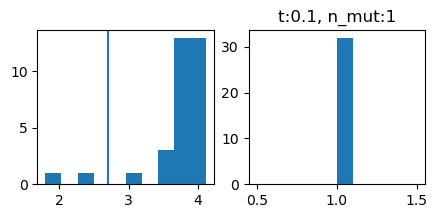

95
95
(95, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


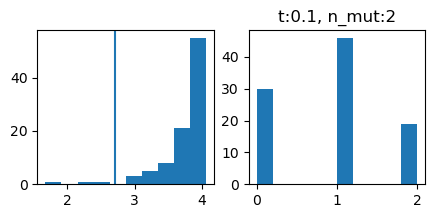

94
94
(94, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


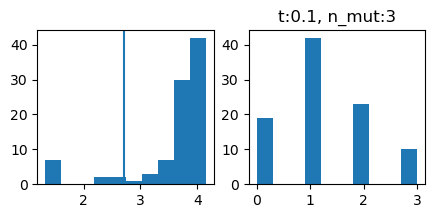

89
89
(89, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


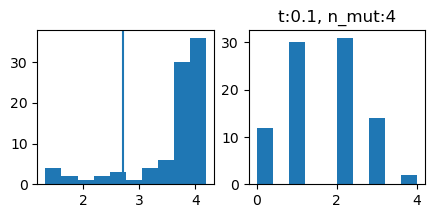

96
96
(96, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


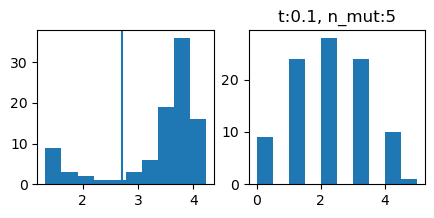

89
89
(89, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


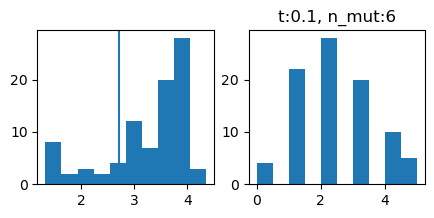

94
94
(94, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


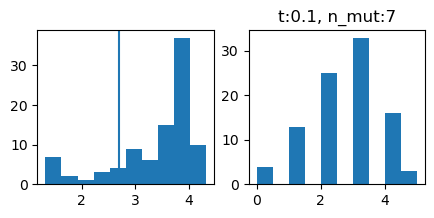

91
91
(91, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


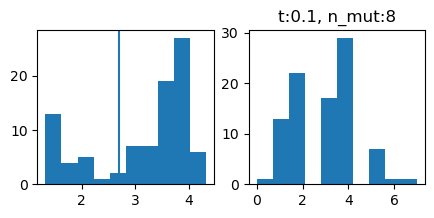

94
94
(94, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


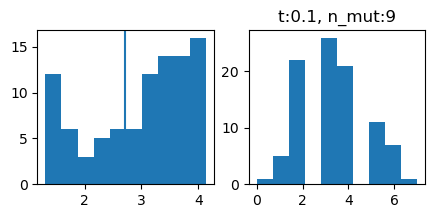

95
95
(95, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


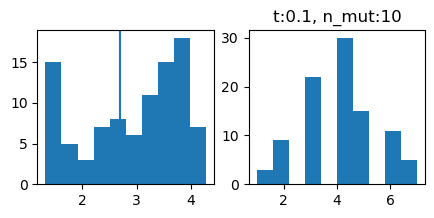

94
94
(94, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


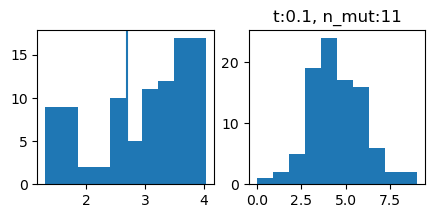

90
90
(90, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


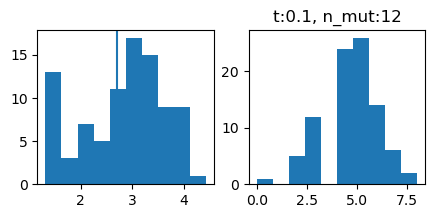

43
42
(42, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


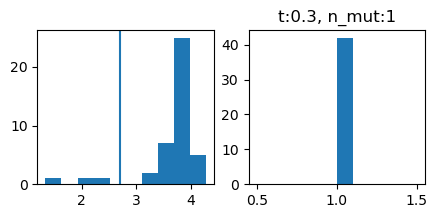

93
93
(93, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


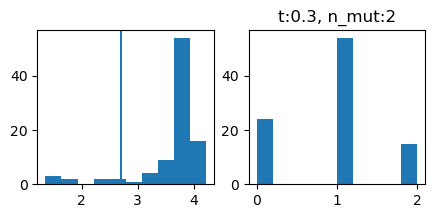

88
88
(88, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


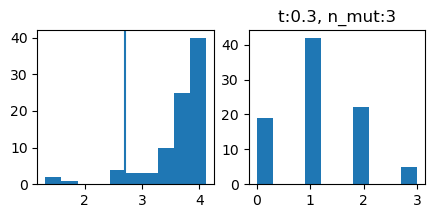

96
96
(96, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


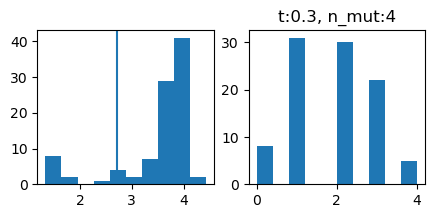

90
90
(90, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


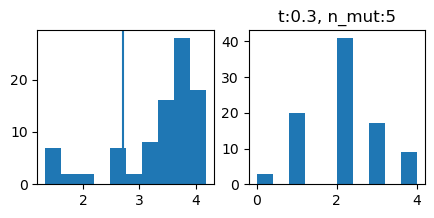

91
91
(91, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


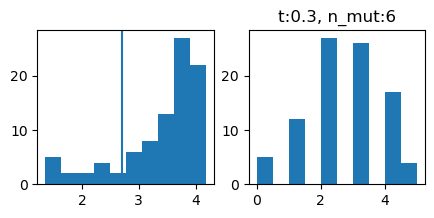

96
96
(96, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


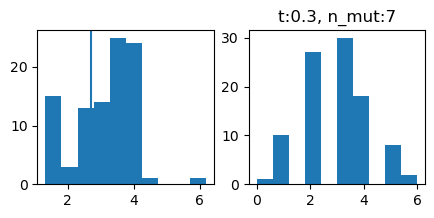

95
95
(95, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


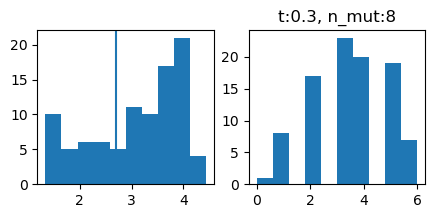

94
94
(94, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


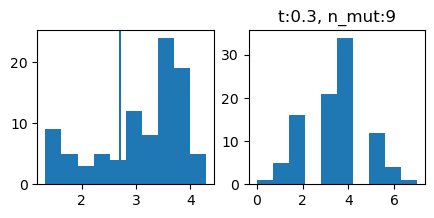

96
96
(96, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


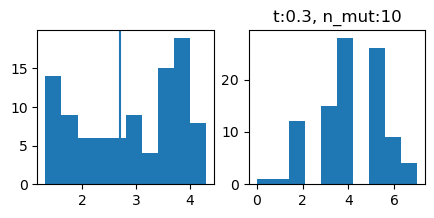

99
99
(99, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


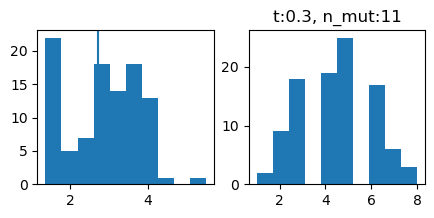

96
96
(96, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


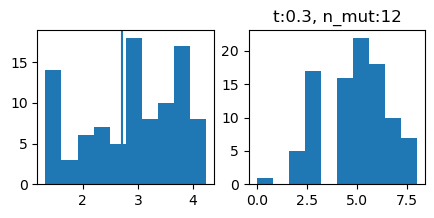

48
41
(41, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


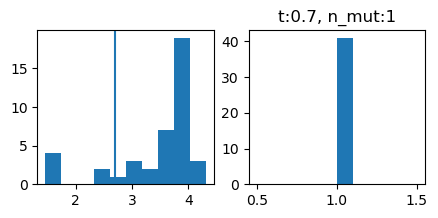

93
93
(93, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


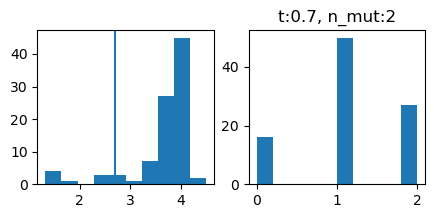

97
97
(97, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


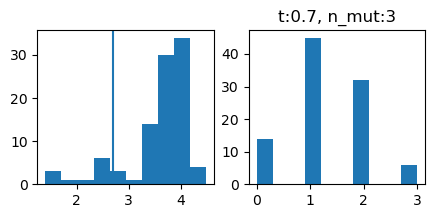

97
97
(97, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


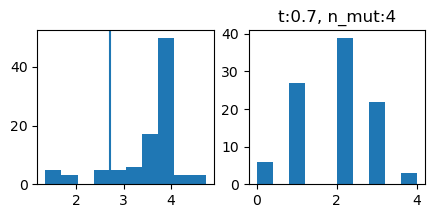

94
94
(94, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


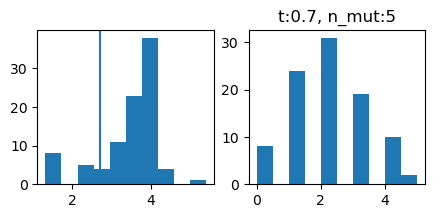

92
92
(92, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


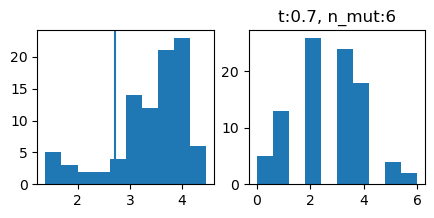

94
94
(94, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


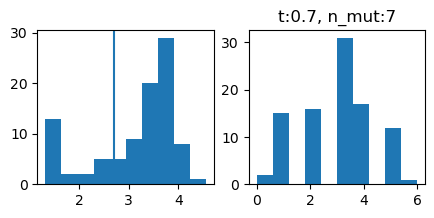

96
96
(96, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


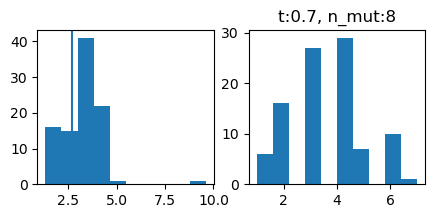

92
92
(92, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


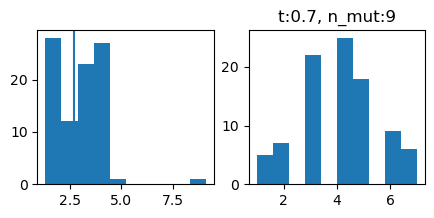

94
94
(94, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


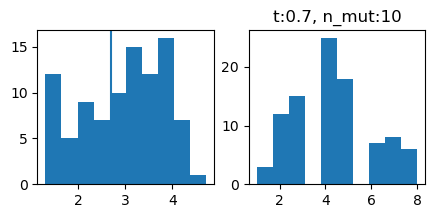

96
96
(96, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


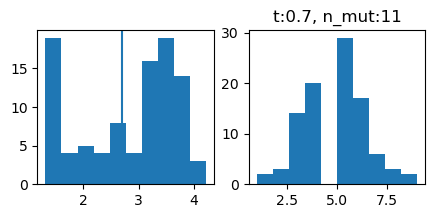

94
94
(94, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


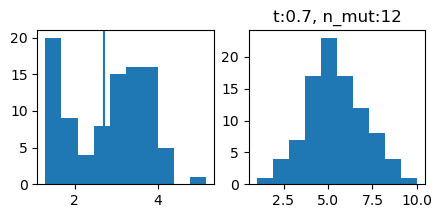

51
48
(48, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


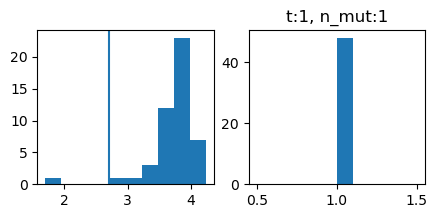

94
94
(94, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


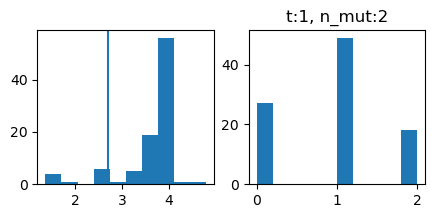

96
96
(96, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


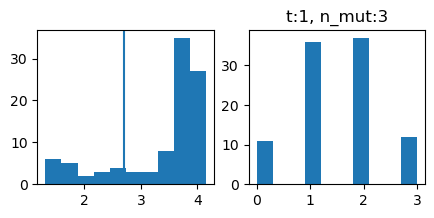

95
95
(95, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


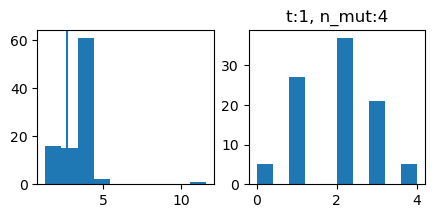

92
92
(92, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


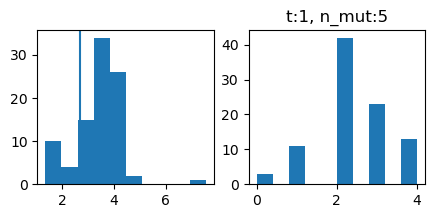

98
98
(98, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


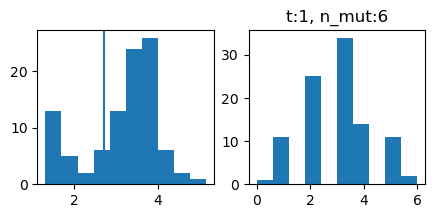

95
95
(95, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


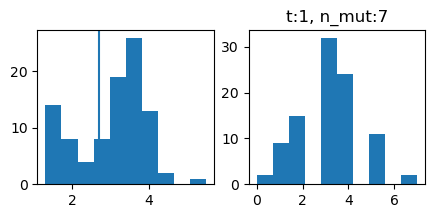

92
92
(92, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


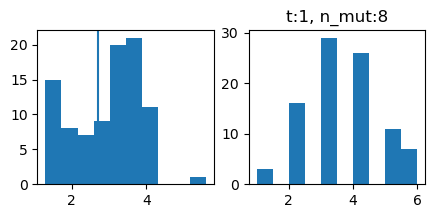

98
98
(98, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


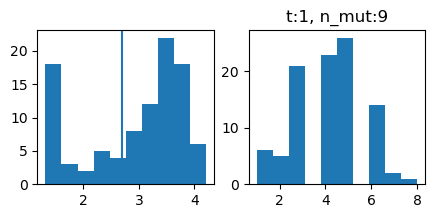

95
95
(95, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


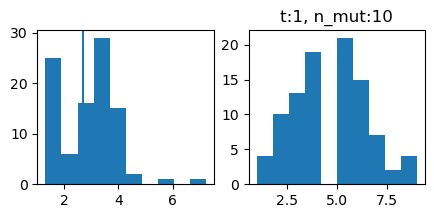

94
94
(94, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


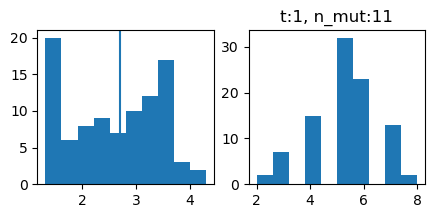

95
95
(95, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


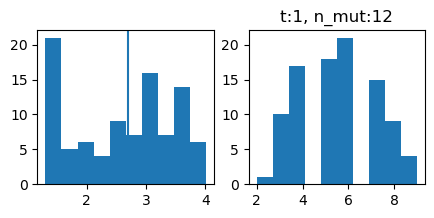

47
46
(46, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


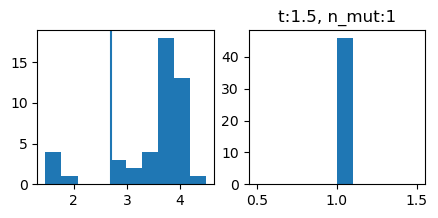

96
96
(96, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


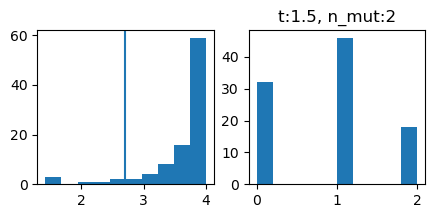

93
93
(93, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


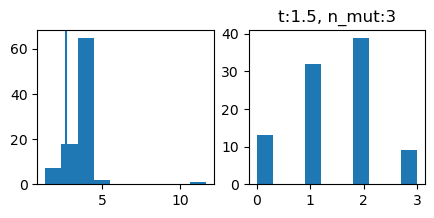

93
93
(93, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


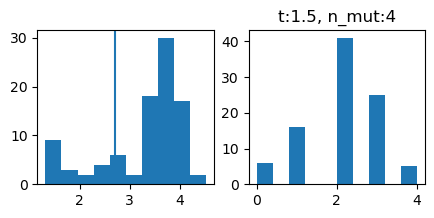

95
95
(95, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


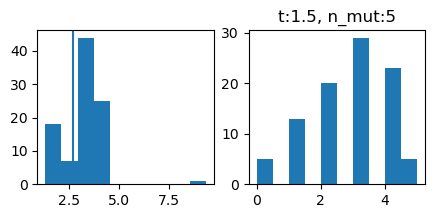

96
96
(96, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


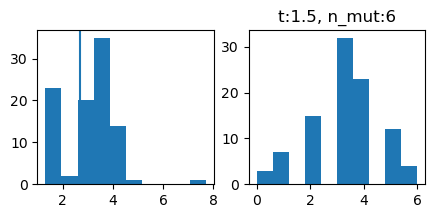

96
96
(96, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


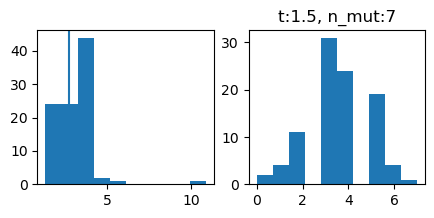

95
95
(95, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


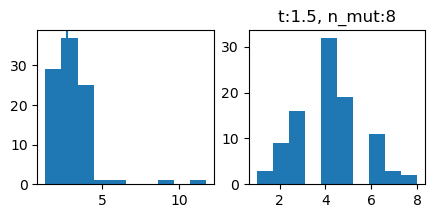

95
95
(95, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


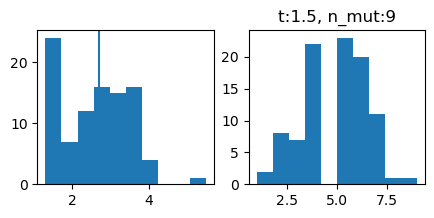

89
89
(89, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


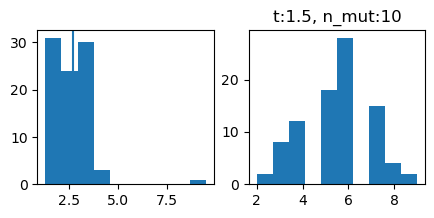

92
92
(92, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


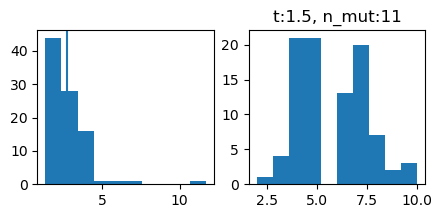

94
94
(94, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


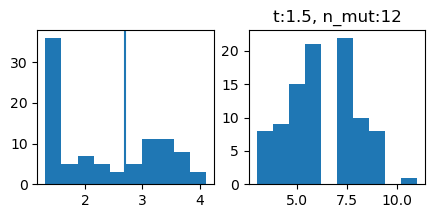

63
60
(60, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


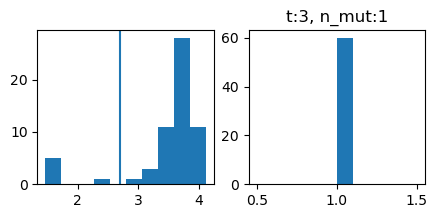

91
91
(91, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


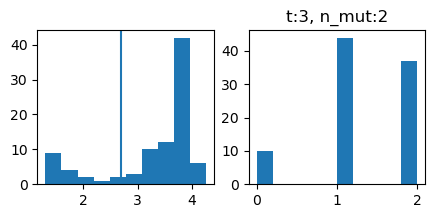

95
95
(95, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


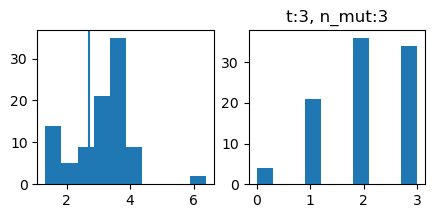

94
94
(94, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


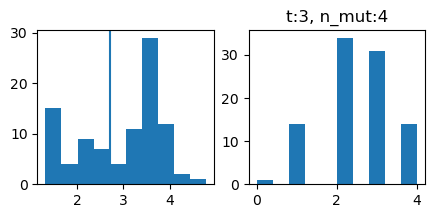

93
93
(93, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


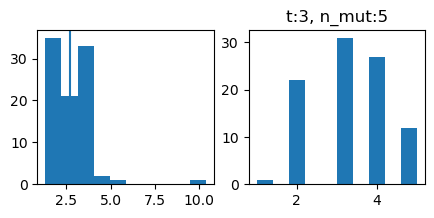

94
94
(94, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


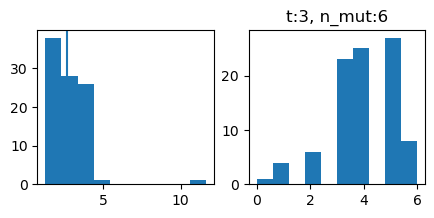

97
97
(97, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


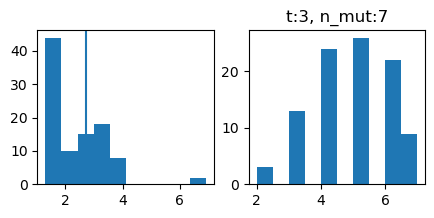

96
96
(96, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


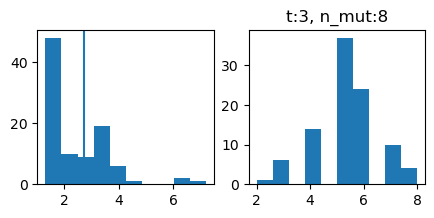

94
94
(94, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


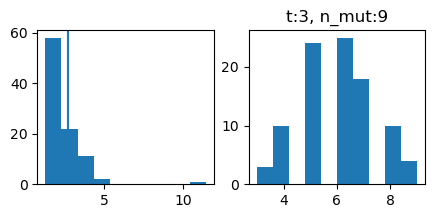

95
95
(95, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


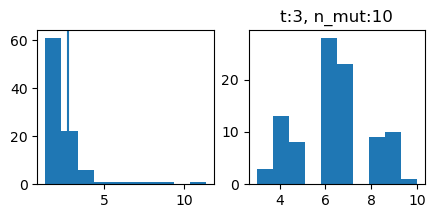

97
97
(97, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


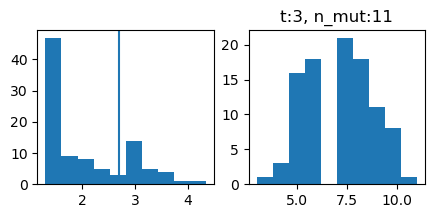

96
96
(96, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


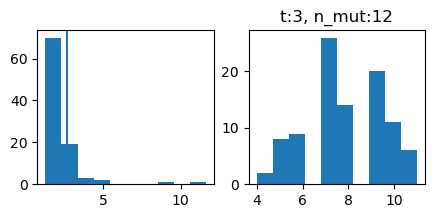

74
69
(69, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


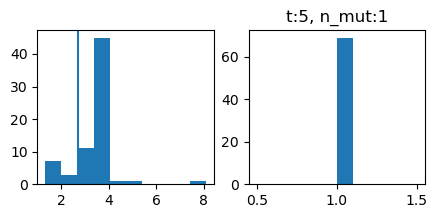

98
98
(98, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


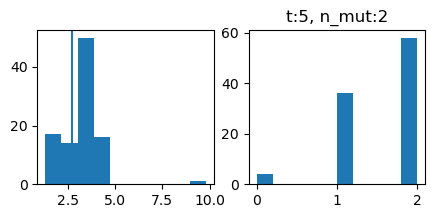

95
95
(95, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


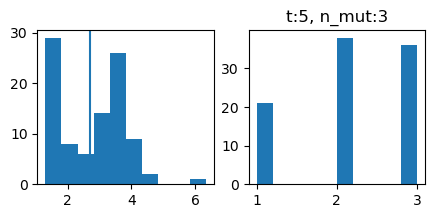

90
90
(90, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


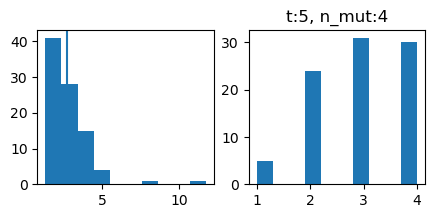

94
94
(94, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


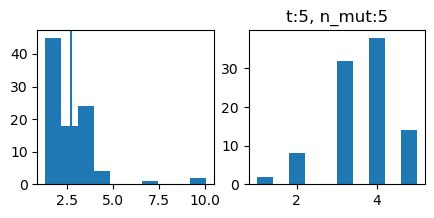

96
96
(96, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


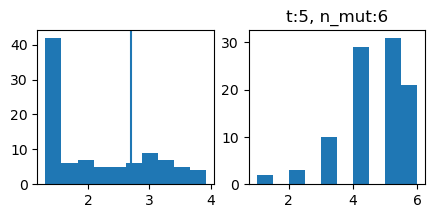

92
92
(92, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


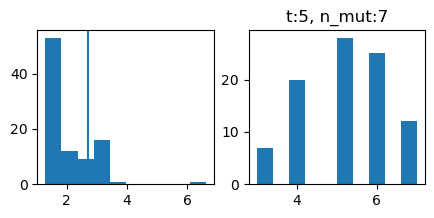

96
96
(96, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


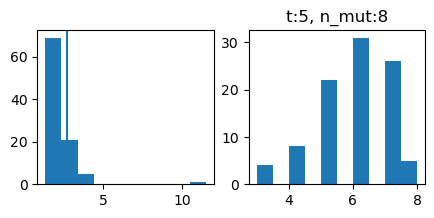

92
92
(92, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


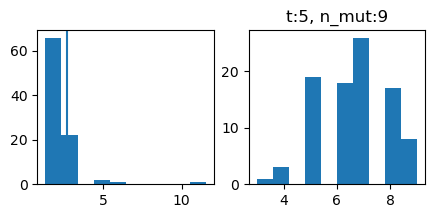

99
99
(99, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


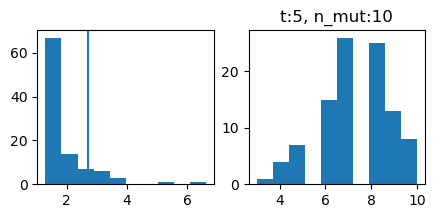

94
94
(94, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


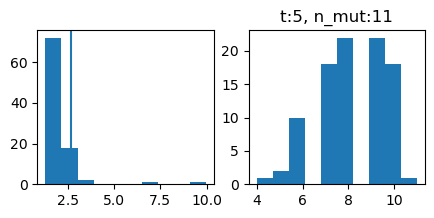

95
95
(95, 4999)


/tmp/ipykernel_27242/3727743066.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)


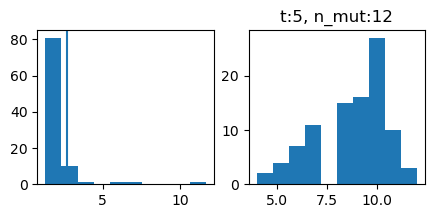

In [15]:
#varying max num mutations but T-0.5
# load and parse samples sequences

sample_din = './gvp_samples/gfp_samples/'
#print(listdir(sample_din))


#assayed_temps = [10**t_exp for t_exp in range(-100,0,10)] # these are all 103 muts away

# for various sampling temps with 4 positions mutated

t = 0.5
n_sample = 100 # n_sample=100
n_pos_mutate_range = 13

df_gen_result = pd.DataFrame(columns=['t', 'max_mut', 'average_wt_hamming', 'frac_above_thresh'])
for t in [0.1, 0.3, 0.7, 1,1.5, 3, 5]:
    for n_pos_mutate in range(1, n_pos_mutate_range):
        # make a list of sequences 
        #mutkeys = read_sampled_mut_key(
        #    sample_din + f'gvp_100_m_RES_1646945484_3030427_8_230519_gfp_samples_t{t}_n100.csv')
        mutkeys = read_sampled_mut_key(
            sample_din + f'gvp_100_m_RES_1646945484_3030427_8_230519_gfp_samples_t{t}_n{n_sample}_downselect{n_pos_mutate}.csv')
        print(len(mutkeys))
        unique_mutkeys_gen = list(set(mutkeys))
        print(len(unique_mutkeys_gen))



        unique_mutseq_gen = [get_mutseq_from_mutkey(mk, wt_gfp_seq, offset=-1) for mk in unique_mutkeys_gen]

        df_gen_seqs = pd.DataFrame({'gen_seq': unique_mutseq_gen, 'mutkey': unique_mutkeys_gen})
        df_gen_seqs['oh'] = df_gen_seqs.apply(lambda r: seq_to_oh(r.gen_seq, d_aa_to_oh_pos), axis=1)

        # filtered for seen mutants in generation script.
        #df_gen_seqs['all_muts_seen_in_exp'] = df_gen_seqs.apply(
        #    lambda r: not bool(sum([(m not in muts_seen_dms) for m in r.mutkey.split(':')])), axis=1)
        #display(df_gen_seqs)

        #df_gen_seqs_seen = df_gen_seqs.loc[df_gen_seqs.all_muts_seen_in_exp]
        #n_gen_seqs_seen = len(df_gen_seqs_seen)
        #print('n generated samples seen in exp:', n_gen_seqs_seen)

        #if n_gen_seqs_seen >0:
        X_gen = np.stack(list(df_gen_seqs['oh'].values), axis=0)
        X_gen= np.c_[X_gen,np.ones(X_gen.shape[0])]
        print(X_gen.shape)

        # evaluate sampled sequences
        # filtered for mutations that predictions can be made about

        yhat_non_gen = model.predict(X_gen).flatten()

        frac_above_thresh = sum(yhat_non_gen>threshold)/len(yhat_non_gen)
        ham_dists_wt = [hamming(wt_gfp_seq,mutseq) for mutseq in df_gen_seqs['gen_seq']]
        average_wt_hamming = np.mean(ham_dists_wt)

        dic_row_result = {'t':t, 
                          'max_mut':n_pos_mutate, 
                          'average_wt_hamming':average_wt_hamming, 
                          'frac_above_thresh':frac_above_thresh}
        df_gen_result = df_gen_result.append(dic_row_result, ignore_index=True)

        fig, (ax1,ax2) = plt.subplots(1,2,figsize=(5,2))

        plt.title(f't:{t}, n_mut:{n_pos_mutate}')
        ax1.hist(yhat_non_gen)
        ax1.axvline(threshold)
        ax2.hist(ham_dists_wt)
        plt.show()

0.3
0.7
1.0
1.5
3.0
5.0


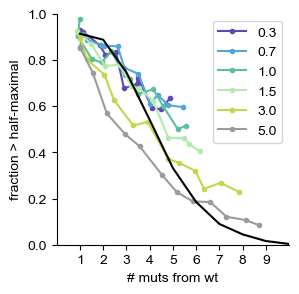

In [81]:
df_gen_result

plt.figure(figsize=(3,3))

# plot generation results
for t in sorted(list(set(df_gen_result.t))):
    if t not in [0.1,]:
        print(t)
        df_t = df_gen_result.loc[df_gen_result.t==t]
        plt.plot(df_t.average_wt_hamming, df_t.frac_above_thresh, 
                 label=t, 
                marker= '.')
# plot observed function
plt.plot(list_hamming_obs,list_fraction_alive_obs, c='black')
plt.xticks(list(range(1,10)))
plt.xlim([0,10])
plt.ylim([0,1])
plt.xlabel('# muts from wt')
plt.ylabel('fraction > half-maximal')
plt.legend()
plt.show()

# try sampling only the top N positions according to the RES model

43
42
(42, 4999)


/tmp/ipykernel_27242/1571711385.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_top_n = df_gen_result_top_n.append(dic_row_result, ignore_index=True)


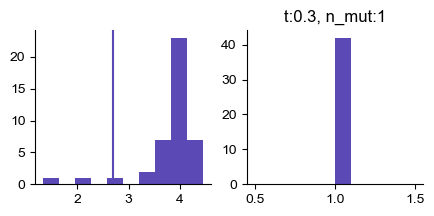

93
93
(93, 4999)


/tmp/ipykernel_27242/1571711385.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_top_n = df_gen_result_top_n.append(dic_row_result, ignore_index=True)


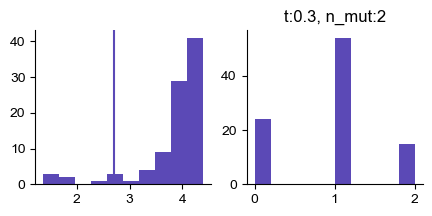

88
88
(88, 4999)


/tmp/ipykernel_27242/1571711385.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_top_n = df_gen_result_top_n.append(dic_row_result, ignore_index=True)


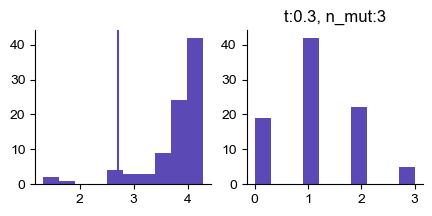

96
96
(96, 4999)


/tmp/ipykernel_27242/1571711385.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_top_n = df_gen_result_top_n.append(dic_row_result, ignore_index=True)


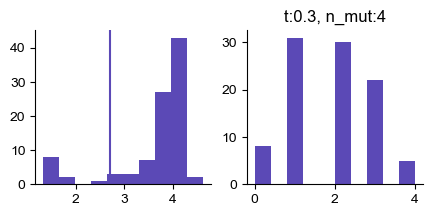

90
90
(90, 4999)


/tmp/ipykernel_27242/1571711385.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_top_n = df_gen_result_top_n.append(dic_row_result, ignore_index=True)


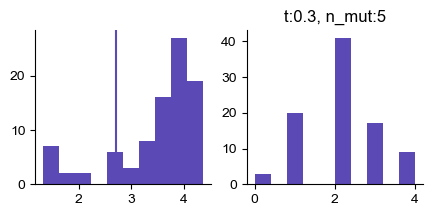

91
91
(91, 4999)


/tmp/ipykernel_27242/1571711385.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_top_n = df_gen_result_top_n.append(dic_row_result, ignore_index=True)


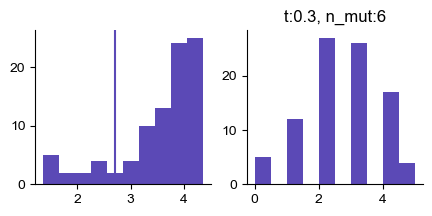

96
96
(96, 4999)


/tmp/ipykernel_27242/1571711385.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_top_n = df_gen_result_top_n.append(dic_row_result, ignore_index=True)


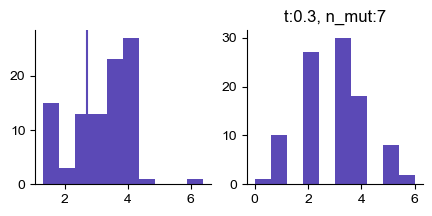

95
95
(95, 4999)


/tmp/ipykernel_27242/1571711385.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_top_n = df_gen_result_top_n.append(dic_row_result, ignore_index=True)


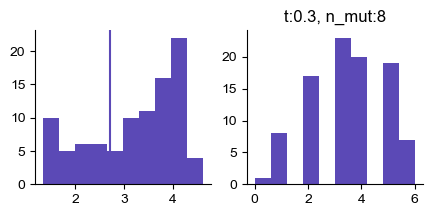

94
94
(94, 4999)


/tmp/ipykernel_27242/1571711385.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_top_n = df_gen_result_top_n.append(dic_row_result, ignore_index=True)


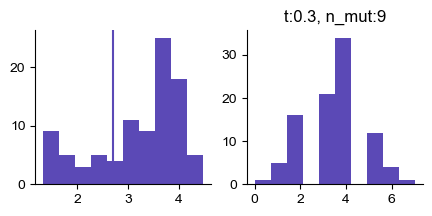

48
41
(41, 4999)


/tmp/ipykernel_27242/1571711385.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_top_n = df_gen_result_top_n.append(dic_row_result, ignore_index=True)


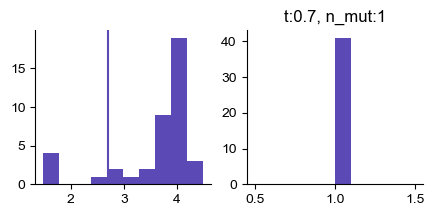

93
93
(93, 4999)


/tmp/ipykernel_27242/1571711385.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_top_n = df_gen_result_top_n.append(dic_row_result, ignore_index=True)


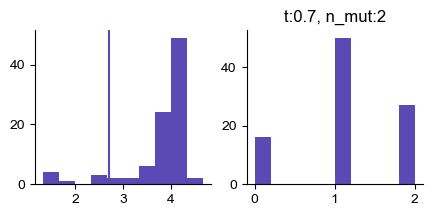

97
97
(97, 4999)


/tmp/ipykernel_27242/1571711385.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_top_n = df_gen_result_top_n.append(dic_row_result, ignore_index=True)


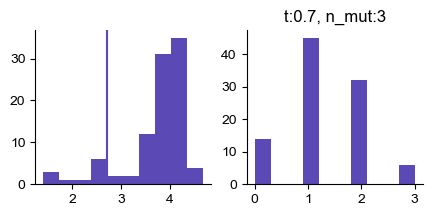

97
97
(97, 4999)


/tmp/ipykernel_27242/1571711385.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_top_n = df_gen_result_top_n.append(dic_row_result, ignore_index=True)


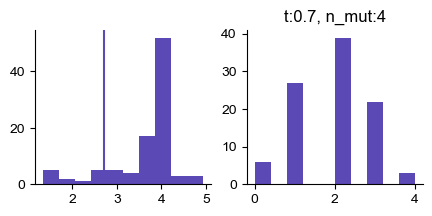

94
94
(94, 4999)


/tmp/ipykernel_27242/1571711385.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_top_n = df_gen_result_top_n.append(dic_row_result, ignore_index=True)


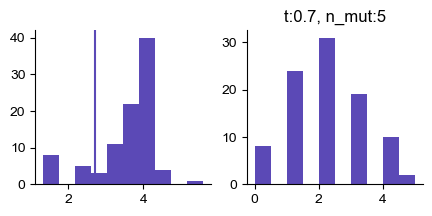

92
92
(92, 4999)


/tmp/ipykernel_27242/1571711385.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_top_n = df_gen_result_top_n.append(dic_row_result, ignore_index=True)


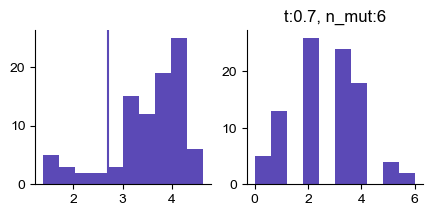

94
94
(94, 4999)


/tmp/ipykernel_27242/1571711385.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_top_n = df_gen_result_top_n.append(dic_row_result, ignore_index=True)


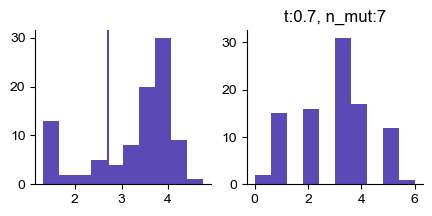

96
96
(96, 4999)


/tmp/ipykernel_27242/1571711385.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_top_n = df_gen_result_top_n.append(dic_row_result, ignore_index=True)


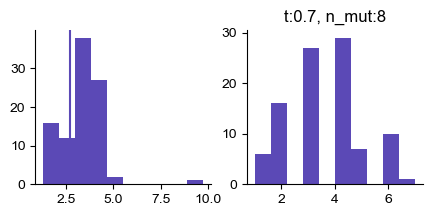

92
92
(92, 4999)


/tmp/ipykernel_27242/1571711385.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_top_n = df_gen_result_top_n.append(dic_row_result, ignore_index=True)


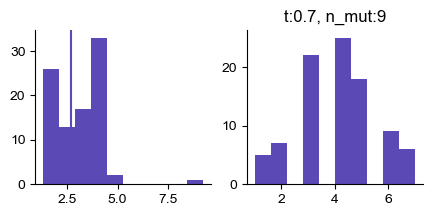

51
48
(48, 4999)


/tmp/ipykernel_27242/1571711385.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_top_n = df_gen_result_top_n.append(dic_row_result, ignore_index=True)


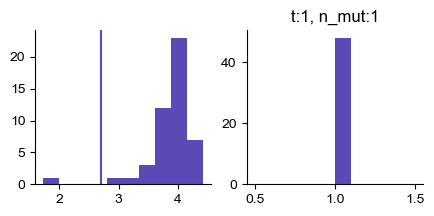

94
94
(94, 4999)


/tmp/ipykernel_27242/1571711385.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_top_n = df_gen_result_top_n.append(dic_row_result, ignore_index=True)


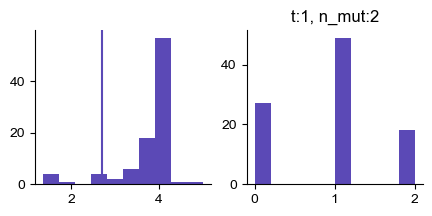

96
96
(96, 4999)


/tmp/ipykernel_27242/1571711385.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_top_n = df_gen_result_top_n.append(dic_row_result, ignore_index=True)


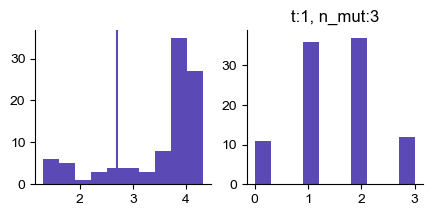

95
95
(95, 4999)


/tmp/ipykernel_27242/1571711385.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_top_n = df_gen_result_top_n.append(dic_row_result, ignore_index=True)


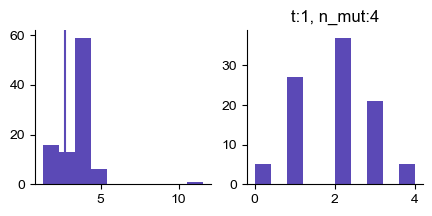

92
92
(92, 4999)


/tmp/ipykernel_27242/1571711385.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_top_n = df_gen_result_top_n.append(dic_row_result, ignore_index=True)


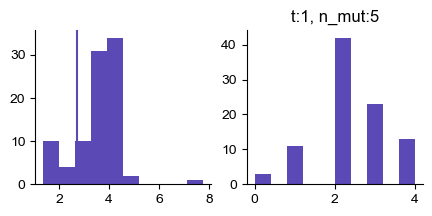

98
98
(98, 4999)


/tmp/ipykernel_27242/1571711385.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_top_n = df_gen_result_top_n.append(dic_row_result, ignore_index=True)


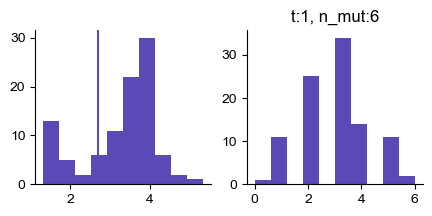

95
95
(95, 4999)


/tmp/ipykernel_27242/1571711385.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_top_n = df_gen_result_top_n.append(dic_row_result, ignore_index=True)


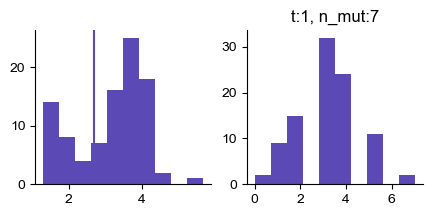

92
92
(92, 4999)


/tmp/ipykernel_27242/1571711385.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_top_n = df_gen_result_top_n.append(dic_row_result, ignore_index=True)


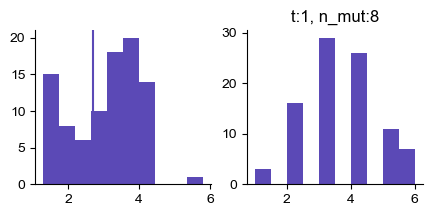

98
98
(98, 4999)


/tmp/ipykernel_27242/1571711385.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_top_n = df_gen_result_top_n.append(dic_row_result, ignore_index=True)


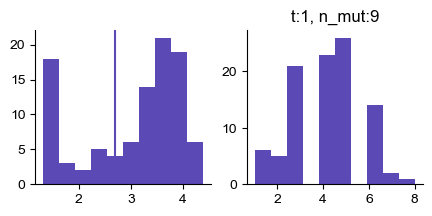

47
46
(46, 4999)


/tmp/ipykernel_27242/1571711385.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_top_n = df_gen_result_top_n.append(dic_row_result, ignore_index=True)


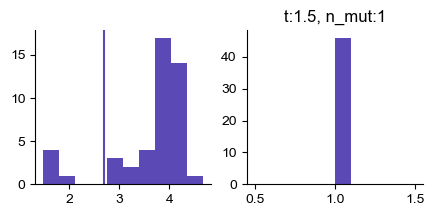

96
96
(96, 4999)


/tmp/ipykernel_27242/1571711385.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_top_n = df_gen_result_top_n.append(dic_row_result, ignore_index=True)


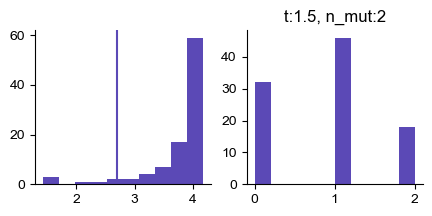

93
93
(93, 4999)


/tmp/ipykernel_27242/1571711385.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_top_n = df_gen_result_top_n.append(dic_row_result, ignore_index=True)


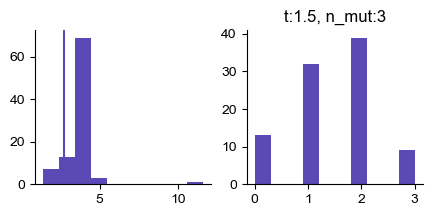

93
93
(93, 4999)


/tmp/ipykernel_27242/1571711385.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_top_n = df_gen_result_top_n.append(dic_row_result, ignore_index=True)


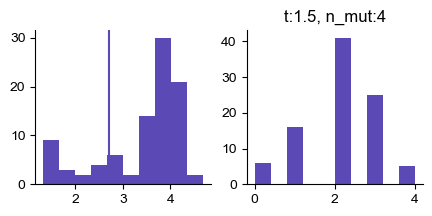

95
95
(95, 4999)


/tmp/ipykernel_27242/1571711385.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_top_n = df_gen_result_top_n.append(dic_row_result, ignore_index=True)


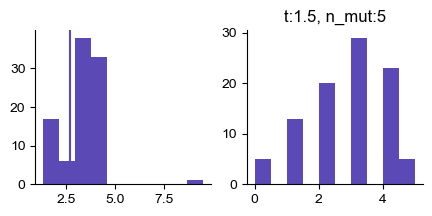

96
96
(96, 4999)


/tmp/ipykernel_27242/1571711385.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_top_n = df_gen_result_top_n.append(dic_row_result, ignore_index=True)


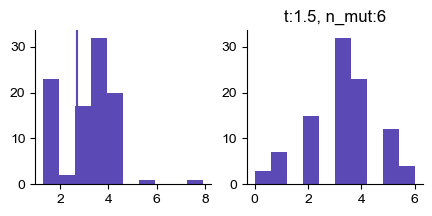

96
96
(96, 4999)


/tmp/ipykernel_27242/1571711385.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_top_n = df_gen_result_top_n.append(dic_row_result, ignore_index=True)


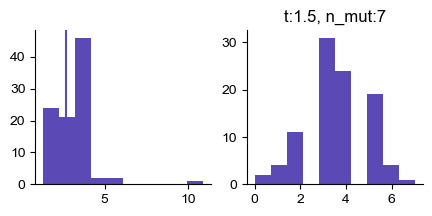

95
95
(95, 4999)


/tmp/ipykernel_27242/1571711385.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_top_n = df_gen_result_top_n.append(dic_row_result, ignore_index=True)


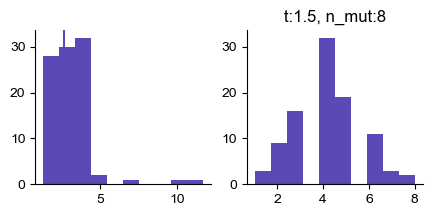

95
95
(95, 4999)


/tmp/ipykernel_27242/1571711385.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_top_n = df_gen_result_top_n.append(dic_row_result, ignore_index=True)


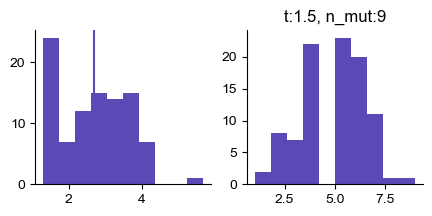

63
60
(60, 4999)


/tmp/ipykernel_27242/1571711385.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_top_n = df_gen_result_top_n.append(dic_row_result, ignore_index=True)


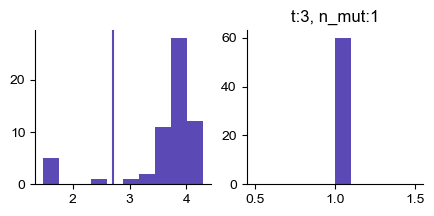

91
91
(91, 4999)


/tmp/ipykernel_27242/1571711385.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_top_n = df_gen_result_top_n.append(dic_row_result, ignore_index=True)


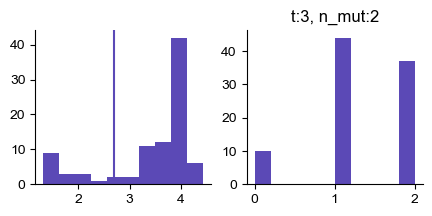

95
95
(95, 4999)


/tmp/ipykernel_27242/1571711385.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_top_n = df_gen_result_top_n.append(dic_row_result, ignore_index=True)


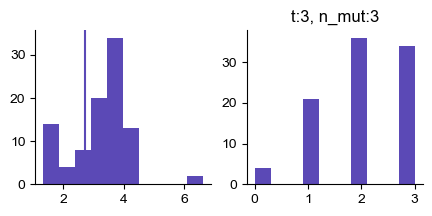

94
94
(94, 4999)


/tmp/ipykernel_27242/1571711385.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_top_n = df_gen_result_top_n.append(dic_row_result, ignore_index=True)


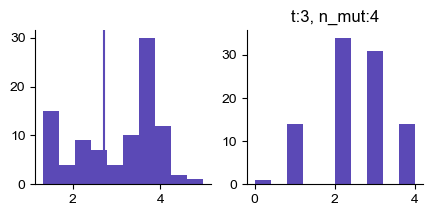

93
93
(93, 4999)


/tmp/ipykernel_27242/1571711385.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_top_n = df_gen_result_top_n.append(dic_row_result, ignore_index=True)


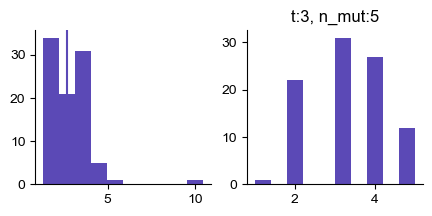

94
94
(94, 4999)


/tmp/ipykernel_27242/1571711385.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_top_n = df_gen_result_top_n.append(dic_row_result, ignore_index=True)


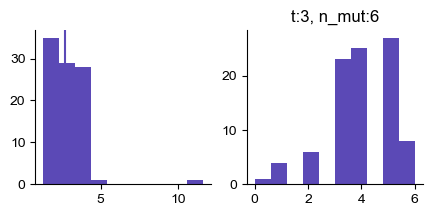

97
97
(97, 4999)


/tmp/ipykernel_27242/1571711385.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_top_n = df_gen_result_top_n.append(dic_row_result, ignore_index=True)


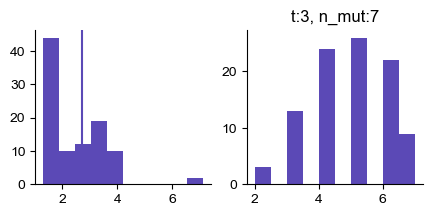

96
96
(96, 4999)


/tmp/ipykernel_27242/1571711385.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_top_n = df_gen_result_top_n.append(dic_row_result, ignore_index=True)


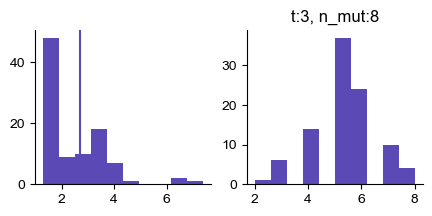

94
94
(94, 4999)


/tmp/ipykernel_27242/1571711385.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_top_n = df_gen_result_top_n.append(dic_row_result, ignore_index=True)


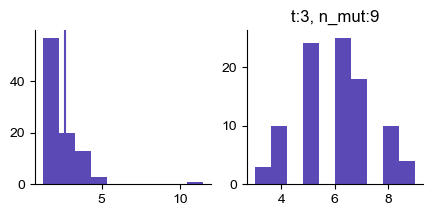

74
69
(69, 4999)


/tmp/ipykernel_27242/1571711385.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_top_n = df_gen_result_top_n.append(dic_row_result, ignore_index=True)


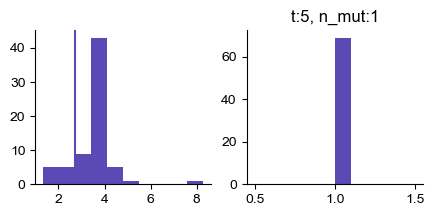

98
98
(98, 4999)


/tmp/ipykernel_27242/1571711385.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_top_n = df_gen_result_top_n.append(dic_row_result, ignore_index=True)


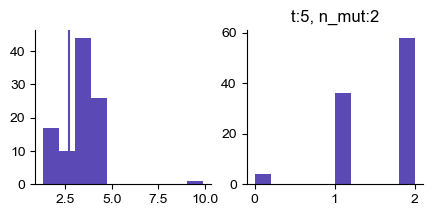

95
95
(95, 4999)


/tmp/ipykernel_27242/1571711385.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_top_n = df_gen_result_top_n.append(dic_row_result, ignore_index=True)


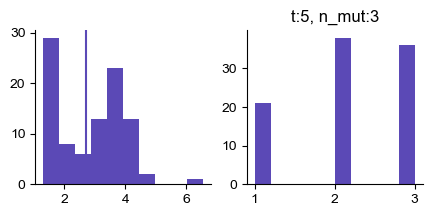

90
90
(90, 4999)


/tmp/ipykernel_27242/1571711385.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_top_n = df_gen_result_top_n.append(dic_row_result, ignore_index=True)


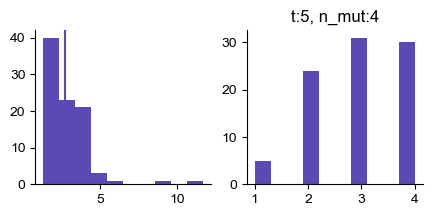

94
94
(94, 4999)


/tmp/ipykernel_27242/1571711385.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_top_n = df_gen_result_top_n.append(dic_row_result, ignore_index=True)


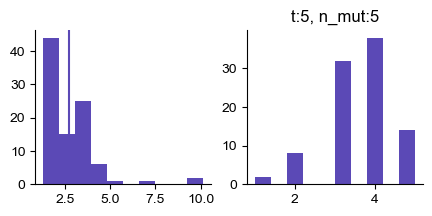

96
96
(96, 4999)


/tmp/ipykernel_27242/1571711385.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_top_n = df_gen_result_top_n.append(dic_row_result, ignore_index=True)


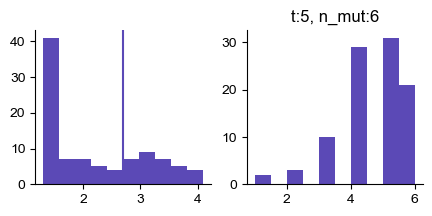

92
92
(92, 4999)


/tmp/ipykernel_27242/1571711385.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_top_n = df_gen_result_top_n.append(dic_row_result, ignore_index=True)


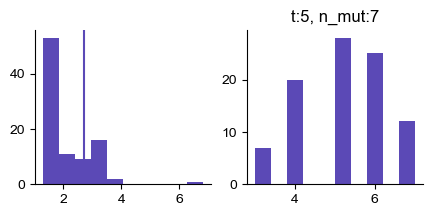

96
96
(96, 4999)


/tmp/ipykernel_27242/1571711385.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_top_n = df_gen_result_top_n.append(dic_row_result, ignore_index=True)


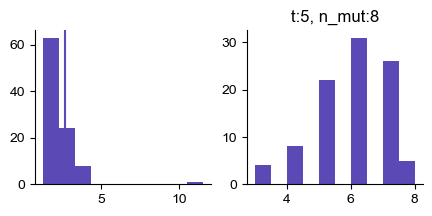

92
92
(92, 4999)


/tmp/ipykernel_27242/1571711385.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gen_result_top_n = df_gen_result_top_n.append(dic_row_result, ignore_index=True)


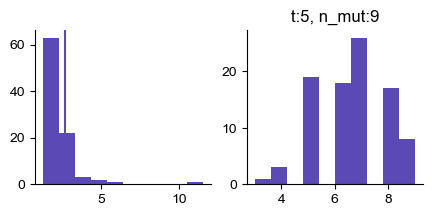

In [82]:

n_sample = 100 # n_sample=100
n_pos_mutate_range = 10

df_gen_result_top_n = pd.DataFrame(columns=['t', 'max_mut', 'average_wt_hamming', 'frac_above_thresh'])
for t in [0.3, 0.7, 1,1.5, 3, 5]:
    for n_pos_mutate in range(1, n_pos_mutate_range):
        # make a list of sequences 
        #mutkeys = read_sampled_mut_key(
        #    sample_din + f'gvp_100_m_RES_1646945484_3030427_8_230519_gfp_samples_t{t}_n100.csv')
        mutkeys = read_sampled_mut_key(
            sample_din + f'gvp_100_m_RES_1646945484_3030427_8_230519_gfp_samples_t{t}_n{n_sample}_downselect{n_pos_mutate}.csv')
        print(len(mutkeys))
        unique_mutkeys_gen = list(set(mutkeys))
        print(len(unique_mutkeys_gen))

        unique_mutseq_gen = [get_mutseq_from_mutkey(mk, wt_gfp_seq, offset=-1) for mk in unique_mutkeys_gen]

        df_gen_seqs = pd.DataFrame({'gen_seq': unique_mutseq_gen, 'mutkey': unique_mutkeys_gen})
        df_gen_seqs['oh'] = df_gen_seqs.apply(lambda r: seq_to_oh(r.gen_seq, d_aa_to_oh_pos), axis=1)

        # filtered for seen mutants in generation script.
        #df_gen_seqs['all_muts_seen_in_exp'] = df_gen_seqs.apply(
        #    lambda r: not bool(sum([(m not in muts_seen_dms) for m in r.mutkey.split(':')])), axis=1)
        #display(df_gen_seqs)

        #df_gen_seqs_seen = df_gen_seqs.loc[df_gen_seqs.all_muts_seen_in_exp]
        #n_gen_seqs_seen = len(df_gen_seqs_seen)
        #print('n generated samples seen in exp:', n_gen_seqs_seen)

        #if n_gen_seqs_seen >0:
        X_gen = np.stack(list(df_gen_seqs['oh'].values), axis=0)
        X_gen= np.c_[X_gen,np.ones(X_gen.shape[0])]
        print(X_gen.shape)

        # evaluate sampled sequences
        # filtered for mutations that predictions can be made about

        yhat_non_gen = model.predict(X_gen).flatten()

        frac_above_thresh = sum(yhat_non_gen>threshold)/len(yhat_non_gen)
        ham_dists_wt = [hamming(wt_gfp_seq,mutseq) for mutseq in df_gen_seqs['gen_seq']]
        average_wt_hamming = np.mean(ham_dists_wt)

        dic_row_result = {'t':t, 
                          'max_mut':n_pos_mutate, 
                          'average_wt_hamming':average_wt_hamming, 
                          'frac_above_thresh':frac_above_thresh}
        df_gen_result_top_n = df_gen_result_top_n.append(dic_row_result, ignore_index=True)

        fig, (ax1,ax2) = plt.subplots(1,2,figsize=(5,2))

        plt.title(f't:{t}, n_mut:{n_pos_mutate}')
        ax1.hist(yhat_non_gen)
        ax1.axvline(threshold)
        ax2.hist(ham_dists_wt)
        plt.show()

0.3
0.7
1.0
1.5
3.0
5.0


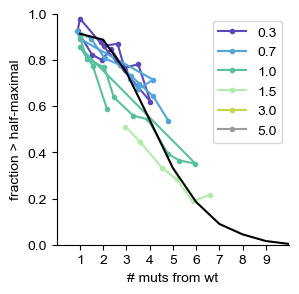

In [83]:

plt.figure(figsize=(3,3))

# plot generation results
for t in sorted(list(set(df_gen_result.t))):
    if t not in [0.1,]:
        print(t)
        df_t = df_gen_result_top_n.loc[df_gen_result.t==t]
        plt.plot(df_t.average_wt_hamming, df_t.frac_above_thresh, 
                 label=t, 
                marker= '.')
# plot observed function
plt.plot(list_hamming_obs,list_fraction_alive_obs, c='black')
plt.xticks(list(range(1,10)))
plt.xlim([0,10])
plt.ylim([0,1])
plt.xlabel('# muts from wt')
plt.ylabel('fraction > half-maximal')
plt.legend()
plt.show()

## misc

['gvp_100_m_RES_1646945484_3030427_8_230519_gfp_samples_t0.7_n100.csv', 'gvp_100_m_RES_1646945484_3030427_8_230519_gfp_samples_t1e-90_n100_downselect4.csv', 'gvp_100_m_RES_1646945484_3030427_8_230519_gfp_samples_t0.05_n100.csv', 'gvp_100_m_RES_1646945484_3030427_8_230519_gfp_samples_t1e-50_n100.csv', 'gvp_100_m_RES_1646945484_3030427_8_230519_gfp_samples_t1e-60_n100.csv', 'gvp_100_m_RES_1646945484_3030427_8_230519_gfp_samples_t1e-40_n100.csv', 'gvp_100_m_RES_1646945484_3030427_8_230519_gfp_samples_t1.8048513878454153e-35_n100.csv', 'gvp_100_m_RES_1646945484_3030427_8_230519_gfp_samples_t4_n100.csv', 'gvp_100_m_RES_1646945484_3030427_8_230519_gfp_samples_t1e-20_n100_downselect4.csv', 'gvp_100_m_RES_1646945484_3030427_8_230519_gfp_samples_t1e-05_n100.csv', 'gvp_100_m_RES_1646945484_3030427_8_230519_gfp_samples_t0.05_n100_downselect4.csv', 'gvp_100_m_RES_1646945484_3030427_8_230519_gfp_samples_t0.03_n100_downselect4.csv', 'gvp_100_m_RES_1646945484_3030427_8_230519_gfp_samples_t10_n100.csv

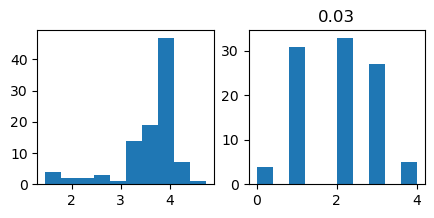

100
100
(100, 4999)


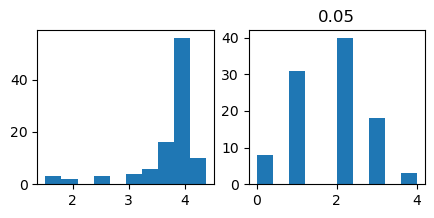

100
100
(100, 4999)


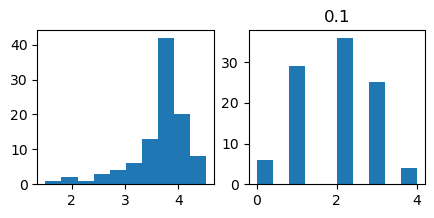

100
100
(100, 4999)


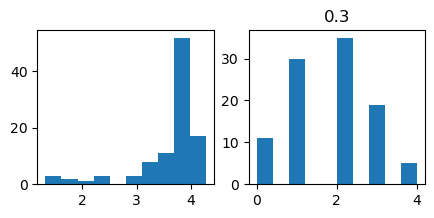

100
100
(100, 4999)


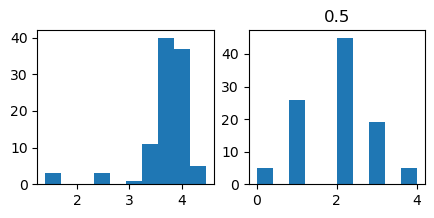

100
100
(100, 4999)


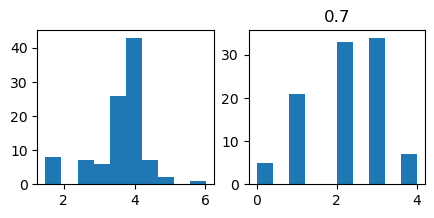

100
100
(100, 4999)


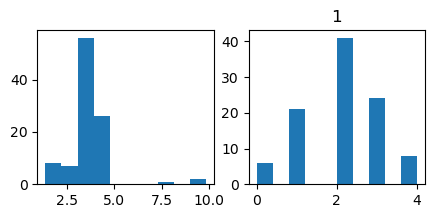

100
100
(100, 4999)


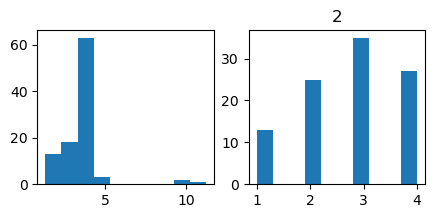

100
100
(100, 4999)


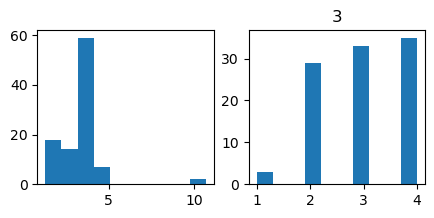

100
100
(100, 4999)


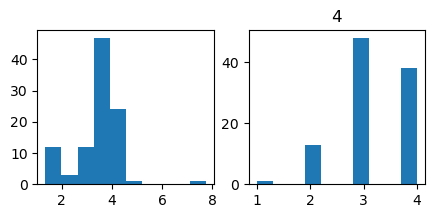

100
100
(100, 4999)


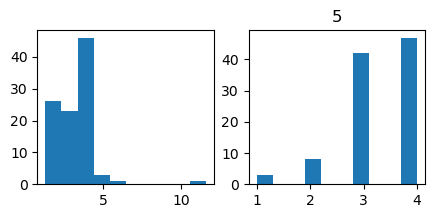

100
100
(100, 4999)


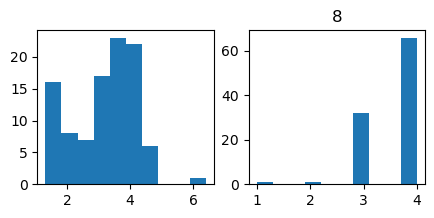

100
100
(100, 4999)


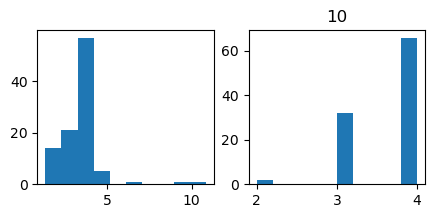

100
100
(100, 4999)


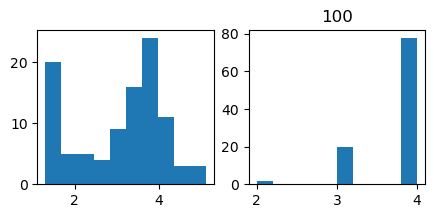

100
100
(100, 4999)


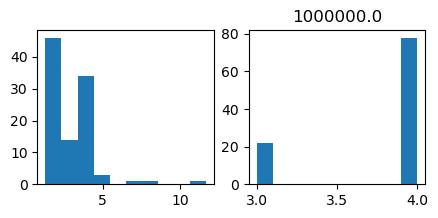

In [69]:
# varying temperature and with max of 4 mutations
# load and parse samples sequences

sample_din = './gvp_samples/gfp_samples/'
print(listdir(sample_din))


#assayed_temps = [10**t_exp for t_exp in range(-100,0,10)] # these are all 103 muts away

# for various sampling temps with 4 positions mutated
assayed_temps = [0.03,0.05, 0.1, 0.3, 0.5,0.7,1,2, 3, 4, 5, 8, 10, 100, 1e6]
n_sample = 100
n_pos_mutate = 4

for t in assayed_temps:
    # make a list of sequences 
    #mutkeys = read_sampled_mut_key(
    #    sample_din + f'gvp_100_m_RES_1646945484_3030427_8_230519_gfp_samples_t{t}_n100.csv')
    mutkeys = read_sampled_mut_key(
        sample_din + f'gvp_100_m_RES_1646945484_3030427_8_230519_gfp_samples_t{t}_n{n_sample}_downselect{n_pos_mutate}.csv')
    print(len(mutkeys))
    unique_mutkeys_gen = list(set(mutkeys))
    print(len(unique_mutkeys_gen))

    unique_mutseq_gen = [get_mutseq_from_mutkey(mk, wt_gfp_seq, offset=-1) for mk in unique_mutkeys_gen]

    df_gen_seqs = pd.DataFrame({'gen_seq': unique_mutseq_gen, 'mutkey': unique_mutkeys_gen})
    df_gen_seqs['oh'] = df_gen_seqs.apply(lambda r: seq_to_oh(r.gen_seq, d_aa_to_oh_pos), axis=1)


    X_gen = np.stack(list(df_gen_seqs['oh'].values), axis=0)
    X_gen= np.c_[X_gen,np.ones(X_gen.shape[0])]
    print(X_gen.shape)

    # evaluate sampled sequences
    # filtered for mutations that predictions can be made about

    yhat_non_gen = model.predict(X_gen).flatten()
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(5,2))
    
    plt.title(t)
    ax1.hist(yhat_non_gen)
    ax2.hist([hamming(wt_gfp_seq,mutseq) for mutseq in df_gen_seqs['gen_seq']])
    plt.show()

# check that indexing between generated seqs and dms experiments is the same

In [104]:
print(list(muts_seen_dms)[:10]) # these are also M1 indexed
wt_gfp_seq[112]
wt_gfp_seq[43]
wt_gfp_seq[195]

['K113V', 'L44S', 'P196A', 'G51D', 'F46I', 'P211H', 'I171F', 'V16L', 'V55M', 'G33D']


'P'

In [100]:
# generated mutkeys: R168K', F84C', so these are in M1 indexing
print(wt_gfp_seq[167])
print(wt_gfp_seq[83])

R
F


# training nonlinear model on mutseq generated from mutant column, rather than the supplied mutsequence 
- same result, it's just the 4 positions differ between df_gfp wt seq reference and the pdb wt sequence

In [10]:
def mutkey_from_mutseq(mutseq, wt_seq, offset=1):
    list_mk = []
    for i, (m, wt) in enumerate(zip(mutseq, wt_seq)):
        if m != wt:
            list_mk.append(wt + str(i+offset) + m) # add offset to be in M1 indexing
    return ':'.join(list_mk)
df_gfp['mutant_from_mutseq'] = df_gfp.mutated_sequence.apply(lambda x: mutkey_from_mutseq(x, wt_gfp_seq))

In [7]:

df_gfp['oh_code'] = df_gfp.apply(lambda r: seq_to_oh(r.mutseq_from_mutant, d_aa_to_oh_pos), axis=1)

X = np.stack(list(df_gfp['oh_code'].values), axis=0)
X= np.c_[X,np.ones(X.shape[0])]
print(X.shape)
Y = df_gfp.DMS_score.values

AttributeError: 'Series' object has no attribute 'mutseq_from_mutant'

(4999, 1)
layer0 weights set to:  [[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
beta_hat [0. 0. 0. 0. 0.]


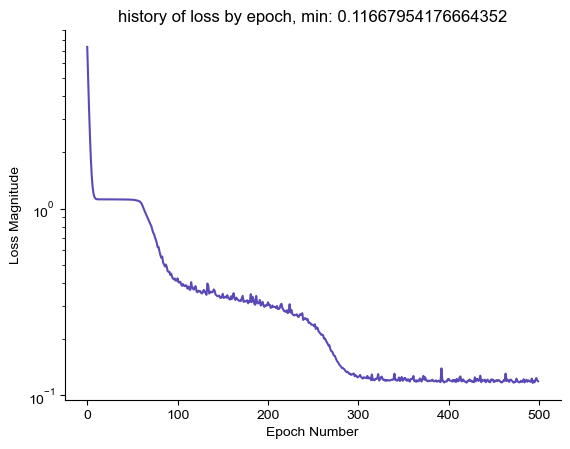

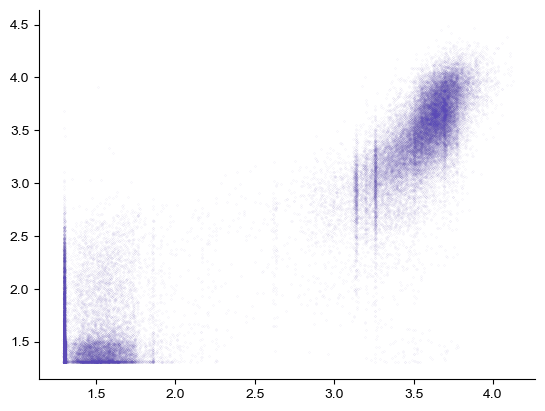

In [65]:
adam_lr = 0.005
model, history, callbacks =fit_log_model(X, Y, 
                                        my_layer=log_layer_scale_shift(1, reg_strength=0),
                                        adam_lr =adam_lr,
                                         epochs=500,
                                         batch_size=1000, 
                                         rand_seed=3)

Yhat_non_from_mutant= model.predict(X).flatten()
df_gfp['nonlinear_predict_from_mutant'] = Yhat_non_from_mutant

plt.figure()
plt.scatter(Y, Yhat_non_from_mutant, s=0.001)
plt.show()

# check correlation of log reg PWM and RES PWM

- not too shabby actually for a bunch of them

# inspect a generated sequence and why it's predictions are so high?
- most likely just because the nonlinearity goes to high up and there is some noise estimating fitness efx.

286
286
(286, 4999)


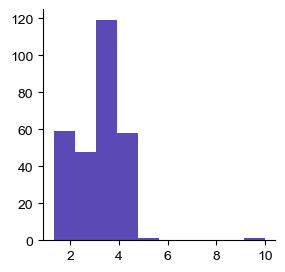

,gen_seq,mutkey,oh,yhat_non
158,MSKGEELFTGVVPIRVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,L15R:K107S:N144K,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",9.990806


In [36]:
# check why the predictions of some mutants is soo fucking high at 10, which is off the charts.
fin = sample_din + f'gvp_100_m_RES_1646945484_3030427_8_230519_gfp_samples_t{0.5}_n{300}_downselect{10}_230528.csv'
df_gen_seqs = read_sampling_file_res(fin)


X_gen = np.stack(list(df_gen_seqs['oh'].values), axis=0)
X_gen= np.c_[X_gen,np.ones(X_gen.shape[0])]
print(X_gen.shape)

# evaluate sampled sequences
# filtered for mutations that predictions can be made about

yhat_non_gen = model.predict(X_gen).flatten()

df_gen_seqs['yhat_non'] = yhat_non_gen
plt.figure(figsize=(3,3))
plt.hist(df_gen_seqs.yhat_non)
plt.show()

df_gen_seqs.loc[df_gen_seqs.yhat_non > 8]

In [38]:
'L15R' in muts_seen_dms

True

In [39]:
'K107S' in muts_seen_dms

True

In [40]:
'N144K' in muts_seen_dms

True